In [1]:
random_state = 2

# Data Preprocessing

## Load Data

In [14]:
import os
import torch
import pickle
from pathlib import Path

# Define the base path based on the random state
base_path = Path(f'data/generated-data/cube_samples/random_seed_{random_state}')

# Load the encoded data
all_encoded_cubes = torch.load(os.path.join(base_path, 'vqgan_encoded_96.pt'))

# Load the sampled data from the directory specified by the random state
sampled_points_multi_organ_labels = torch.load(base_path / 'sample_point_ground_truths.pt')
sampled_points_coordinates = torch.load(base_path / 'sample_coordinates.pt')

# Load the list of patient IDs
with open(base_path / 'filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)

# Print and check the shapes and lengths
print(all_encoded_cubes.shape)
print(len(all_filtered_ids))
assert len(all_encoded_cubes) == len(all_filtered_ids)
assert len(sampled_points_multi_organ_labels) == len(all_filtered_ids)

torch.Size([43, 55, 8, 24, 24, 24])
43


In [15]:
len(all_filtered_ids)

43

In [16]:
pancreas_vs_background_labels = sampled_points_multi_organ_labels == 8

print(pancreas_vs_background_labels.shape)

torch.Size([43, 55])


## Helper functions

Flattening & Extracting Middle Vector, etc.

In [30]:
import torch
from typing import Optional, Tuple

import torch

def flatten_features(features: torch.Tensor) -> torch.Tensor:
    """
    Flatten the input features while keeping the dimension of 8 intact if it exists.

    Parameters:
        features (torch.Tensor): 
            - Original features of shape (n_samples, 55, 8, 24, 24, 24) or
            - Original features of shape (n_samples, 55, 24, 24, 24).

    Returns:
        torch.Tensor: 
            - If input is (n_samples, 55, 8, 24, 24, 24), returns (n_samples * 55 * 24 * 24 * 24, 8).
            - If input is (n_samples, 55, 24, 24, 24), returns (n_samples * 55 * 24 * 24 * 24, 1).
    """
    if not isinstance(features, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")

    shape = features.shape
    num_dims = features.dim()

    if num_dims == 6:
        # Input shape: (n_samples, 55, 8, 24, 24, 24)
        n_samples, _, dim_8, *rest = shape
        if dim_8 != 8:
            raise ValueError("The third dimension must be 8 for 6D input tensors.")
        
        # Permute to bring the '8' dimension to the second position
        # New shape after permute: (n_samples, 8, 55, 24, 24, 24)
        permuted = features.permute(0, 2, 1, 3, 4, 5)
        
        # Reshape to (n_samples * 55 * 24 * 24 * 24, 8)
        flattened = permuted.contiguous().view(-1, 8)
    
    elif num_dims == 5:
        # Input shape: (n_samples, 55, 24, 24, 24)
        # Reshape to (n_samples * 55 * 24 * 24 * 24, 1)
        flattened = features.view(-1, 1)
    
    else:
        raise ValueError("Input features must have either 5 or 6 dimensions.")

    return flattened


def unflatten_features(flattened: torch.Tensor, n_samples: int, n_points_per_sample: int = 55, num_channels: int = 8, dim_size: int = 24) -> torch.Tensor:
    """
    Un-flatten the input features back to their original shape.

    Parameters:
        flattened (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.
        n_points_per_sample (int): Number of points per sample.

    Returns:
        torch.Tensor: Original features of shape (n_samples, 55, 8, 24, 24, 24).
    """
    if not isinstance(flattened, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")
    
    # Define the expected dimensions
    num_items = n_points_per_sample
    
    # Calculate the expected size of the first dimension
    expected_first_dim = n_samples * num_items * dim_size * dim_size * dim_size
    
    if flattened.shape[0] != expected_first_dim:
        raise ValueError(
            f"First dimension of flattened tensor should be {expected_first_dim} "
            f"(n_samples * 55 * 24 * 24 * 24), but got {flattened.shape[0]}."
        )
    
    if flattened.shape[1] != num_channels:
        raise ValueError(
            f"The last dimension of flattened tensor should be {num_channels}, "
            f"but got {flattened.shape[1]}."
        )
    
    # Reshape to (n_samples, 55, 24, 24, 24, 8)
    reshaped = flattened.view(n_samples, num_items, dim_size, dim_size, dim_size, num_channels)
    
    # Permute to (n_samples, 55, 8, 24, 24, 24)
    original = reshaped.permute(0, 1, 5, 2, 3, 4).contiguous()
    
    return original


def extract_middle_vectors(flattened_features: torch.Tensor,
                           n_samples: int = all_encoded_cubes.shape[0],
                           n_j: int = 55,
                           n_x: int = 24,
                           n_y: int = 24,
                           n_z: int = 24,
                           middle_x: int = 12,
                           middle_y: int = 12,
                           middle_z: int = 12) -> (torch.Tensor, torch.Tensor):
    """
    Extract the middle vectors at position (i, j, 12, 12, 12, :) from the flattened tensor
    and return their corresponding indices.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples (e.g., 50).
        n_j (int): Size of the second dimension (e.g., 55).
        n_x (int): Size of the third dimension (e.g., 24).
        n_y (int): Size of the fourth dimension (e.g., 24).
        n_z (int): Size of the fifth dimension (e.g., 24).
        middle_x (int): Middle index along the x-axis (e.g., 12).
        middle_y (int): Middle index along the y-axis (e.g., 12).
        middle_z (int): Middle index along the z-axis (e.g., 12).

    Returns:
        middle_vectors (torch.Tensor): Middle vectors of shape (n_samples * n_j, 8).
        indices (torch.Tensor): Indices of the middle vectors in the flattened tensor, shape (n_samples * n_j,).
    """
    def compute_middle_indices(n_samples: int, n_j: int, n_x: int, n_y: int, n_z: int,
                              middle_x: int, middle_y: int, middle_z: int) -> torch.Tensor:
        # Create tensors for i and j indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides based on the permutation and flattening
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Compute the flattened indices using the formula:
        # index = i * (55 * 24 * 24 * 24) + j * (24 * 24 * 24) + 12 * (24 * 24) + 12 * 24 + 12
        indices = (i_indices * (n_j * stride_j) +
                   j_indices * stride_j +
                   middle_x * stride_x +
                   middle_y * stride_y +
                   middle_z * stride_z).view(-1)  # Shape: (n_samples * n_j,)

        return indices

    # Compute the indices for the middle vectors
    indices = compute_middle_indices(n_samples, n_j, n_x, n_y, n_z, middle_x, middle_y, middle_z)

    # Ensure that the indices are within the bounds of the flattened tensor
    if torch.any(indices >= flattened_features.shape[0]):
        raise IndexError("Computed indices are out of bounds.")

    # Extract the middle vectors using the computed indices
    middle_vectors = flattened_features[indices]  # Shape: (n_samples * n_j, 8)

    return middle_vectors, indices



import torch
from typing import Tuple

def extract_stencil_vectors(flattened_features: torch.Tensor,
                            n_samples: int,
                            n_j: int = 55,
                            n_x: int = 24,
                            n_y: int = 24,
                            n_z: int = 24,
                            middle_x: int = 12,
                            middle_y: int = 12,
                            middle_z: int = 12,
                            distance: int = 4) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Extract the center vector and vectors at positions ±distance along each axis.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.
        n_j (int): Number of points per sample.
        distance (int): Distance from the center to extract vectors (e.g., 4, 8, 12).

    Returns:
        vectors_flat (torch.Tensor): Flattened vectors of shape (n_samples * n_j, 8 * 7).
        indices_stacked (torch.Tensor): Indices of the extracted vectors, shape (n_samples * n_j, 7).
    """
    def compute_stencil_indices():
        # Create tensors for sample and point indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Define offsets
        offsets = [
            (0, 0, 0),  # center
            (-distance, 0, 0),
            (distance, 0, 0),
            (0, -distance, 0),
            (0, distance, 0),
            (0, 0, -distance),
            (0, 0, distance),
        ]

        indices_list = []
        for dx, dy, dz in offsets:
            x = middle_x + dx
            y = middle_y + dy
            z = middle_z + dz

            # Ensure indices are within bounds
            if not (0 <= x < n_x and 0 <= y < n_y and 0 <= z < n_z):
                raise IndexError(f"Computed index ({x}, {y}, {z}) is out of bounds.")

            # Compute the flattened indices
            indices = (i_indices * (n_j * stride_j) +
                       j_indices * stride_j +
                       x * stride_x +
                       y * stride_y +
                       z * stride_z).view(-1)

            indices_list.append(indices)

        # Stack indices
        indices_stacked = torch.stack(indices_list, dim=1)  # Shape: (n_samples * n_j, 7)
        return indices_stacked

    indices_stacked = compute_stencil_indices()

    # Extract the vectors
    vectors = flattened_features[indices_stacked]  # Shape: (n_samples * n_j, 7, 8)

    # Flatten the last two dimensions
    vectors_flat = vectors.view(n_samples * n_j, -1)  # Shape: (n_samples * n_j, 8 * 7)

    return vectors_flat, indices_stacked


import torch
import torch.nn.functional as F

def compute_neighbor_similarity(features: torch.Tensor) -> torch.Tensor:
    """
    Compute the gradient magnitude of the vector field.

    Parameters:
        features (torch.Tensor): Tensor of shape (8, 24, 24, 24).

    Returns:
        grad_magnitude (torch.Tensor): Tensor of shape (24, 24, 24).
    """
    # Ensure features are in the correct shape
    assert features.shape == (8, 24, 24, 24), "Expected input shape (8, 24, 24, 24)"

    # Initialize gradient tensors
    grad_x = torch.zeros_like(features)
    grad_y = torch.zeros_like(features)
    grad_z = torch.zeros_like(features)

    # Compute gradients along each axis (forward differences)
    grad_x[:, :-1, :, :] = features[:, 1:, :, :] - features[:, :-1, :, :]
    grad_y[:, :, :-1, :] = features[:, :, 1:, :] - features[:, :, :-1, :]
    grad_z[:, :, :, :-1] = features[:, :, :, 1:] - features[:, :, :, :-1]

    # Compute the magnitude of gradients and sum over channels
    grad_mag = torch.sqrt(grad_x.pow(2) + grad_y.pow(2) + grad_z.pow(2)).sum(dim=0)

    import matplotlib.pyplot as plt

    # Visualize the central slice
    plt.imshow(grad_mag[:, :, 12].cpu().numpy(), cmap='hot')
    plt.title('Gradient Magnitude at Central Slice')
    plt.colorbar()
    plt.show()

    return grad_mag  # Shape: (24, 24, 24)


def extract_sequence_vectors(flattened_features: torch.Tensor,
                             n_samples: int,
                             n_j: int = 55,
                             n_x: int = 24,
                             n_y: int = 24,
                             n_z: int = 24,
                             middle_x: int = 12,
                             middle_y: int = 12,
                             middle_z: int = 12,
                             n_extra: int = 3) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Extract the center vector and the n closest vectors from the center.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.
        n_extra (int): Number of extra closest points to extract.

    Returns:
        vectors_flat (torch.Tensor): Flattened vectors of shape (n_samples * n_j, 8 * (n_extra + 1)).
        indices_stacked (torch.Tensor): Indices of the extracted vectors, shape (n_samples * n_j, n_extra + 1).
    """
    def get_n_closest_offsets(n):
        offsets = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                for dz in range(-1, 2):
                    if dx == 0 and dy == 0 and dz == 0:
                        continue
                    offsets.append((dx, dy, dz))
        # Sort offsets based on Euclidean distance
        offsets = sorted(offsets, key=lambda x: dx*dx + dy*dy + dz*dz)
        return offsets[:n]

    def compute_sequence_indices():
        # Create tensors for sample and point indices
        i_indices = torch.arange(n_samples).unsqueeze(1)
        j_indices = torch.arange(n_j).unsqueeze(0)

        # Calculate strides
        stride_j = n_x * n_y * n_z
        stride_x = n_y * n_z
        stride_y = n_z
        stride_z = 1

        # Get offsets
        offsets = [(0, 0, 0)] + get_n_closest_offsets(n_extra)

        indices_list = []
        for dx, dy, dz in offsets:
            x = middle_x + dx
            y = middle_y + dy
            z = middle_z + dz

            # Ensure indices are within bounds
            if not (0 <= x < n_x and 0 <= y < n_y and 0 <= z < n_z):
                continue

            # Compute flattened indices
            indices = (i_indices * (n_j * stride_j) +
                       j_indices * stride_j +
                       x * stride_x +
                       y * stride_y +
                       z * stride_z).view(-1)
            indices_list.append(indices)

        indices_stacked = torch.stack(indices_list, dim=1)
        return indices_stacked

    indices_stacked = compute_sequence_indices()

    # Extract the vectors
    vectors = flattened_features[indices_stacked]
    vectors_flat = vectors.view(n_samples * n_j, -1)

    return vectors_flat, indices_stacked


import xml.etree.ElementTree as ET
import os

def save_clusters_as_itk_snap_annotations(points, clusters, base_dir="results/itk-snap-annotations", filename='annotations.annot', slice_range=10, image_size=512):
    """
    Saves 3D points as annotations on multiple slices in an .annot file for ITK-SNAP.

    Parameters:
    - points (np.ndarray): Array of shape (n_points, 3) containing x, y, z coordinates.
    - clusters (np.ndarray): Array of shape (n_points,) containing cluster labels (integers).
    - filename (str): Output filename for the .annot file.
    - slice_range (int): Number of slices above and below the point to create annotations.
    - image_size (int or tuple): Size of the image (assumed cubic if int, or specify (x_size, y_size, z_size)).
    """
    clusters = np.array(clusters)
    points = np.array(points)

    if points.shape[0] != clusters.shape[0]:
        raise ValueError("Number of points and clusters must be the same.")

    n_points = points.shape[0]

    # Define fixed red color for all annotations
    color = "1 0 0"  # Fully red

    # Initialize XML structure
    registry = ET.Element('registry')

    # Add header entries
    ET.SubElement(registry, 'entry', key="Format", value="ITK-SNAP Annotation File")
    ET.SubElement(registry, 'entry', key="FormatDate", value="20241014")  # FormatDate as YYYYMMDD

    # Annotations folder
    annotations_folder = ET.SubElement(registry, 'folder', key="Annotations")
    element_counter = 0  # To keep track of Element[n] keys

    # Determine image dimensions
    if isinstance(image_size, int):
        x_max = y_max = z_max = image_size
    elif isinstance(image_size, tuple) and len(image_size) == 3:
        x_max, y_max, z_max = image_size
    else:
        raise ValueError("image_size must be an int or a tuple of three ints.")

    for i in range(n_points):
        x, y, z = points[i]
        cluster = clusters[i]

        # For each plane
        for plane in range(3):
            if plane == 0:  # Sagittal plane (X axis)
                coord = int(round(x))
                coord_min = max(0, coord - slice_range)
                coord_max = min(x_max - 1, coord + slice_range)
            elif plane == 1:  # Coronal plane (Y axis)
                coord = int(round(y))
                coord_min = max(0, coord - slice_range)
                coord_max = min(y_max - 1, coord + slice_range)
            elif plane == 2:  # Axial plane (Z axis)
                coord = int(round(z))
                coord_min = max(0, coord - slice_range)
                coord_max = min(z_max - 1, coord + slice_range)

            # Loop over the coordinate range
            for c in range(coord_min, coord_max + 1):
                element_key = f"Element[{element_counter}]"
                element_folder = ET.SubElement(annotations_folder, 'folder', key=element_key)

                # Position adjusted for the current slice
                if plane == 0:
                    pos = f"{float(c)} {float(y)} {float(z)}"
                elif plane == 1:
                    pos = f"{float(x)} {float(c)} {float(z)}"
                elif plane == 2:
                    pos = f"{float(x)} {float(y)} {float(c)}"

                # Define entries for LandmarkAnnotation
                ET.SubElement(element_folder, 'entry', key="Color", value=color)
                ET.SubElement(element_folder, 'entry', key="Offset", value="0 0")  # No offset
                ET.SubElement(element_folder, 'entry', key="Plane", value=str(plane))
                ET.SubElement(element_folder, 'entry', key="Pos", value=pos)
                ET.SubElement(element_folder, 'entry', key="Selected", value="0")
                ET.SubElement(element_folder, 'entry', key="Tags", value="")
                ET.SubElement(element_folder, 'entry', key="Text", value=str(cluster))  # Removed "Cluster"
                ET.SubElement(element_folder, 'entry', key="Type", value="LandmarkAnnotation")
                ET.SubElement(element_folder, 'entry', key="VisibleInAllPlanes", value="1")  # Visible in all planes
                ET.SubElement(element_folder, 'entry', key="VisibleInAllSlices", value="0")  # Visible only on this slice

                element_counter += 1

    # Update ArraySize to reflect the actual number of elements
    ET.SubElement(annotations_folder, 'entry', key="ArraySize", value=str(element_counter))

    # Create the DOCTYPE declaration
    doctype = '''<!DOCTYPE registry [
<!ELEMENT registry (entry*,folder*)>
<!ELEMENT folder (entry*,folder*)>
<!ELEMENT entry EMPTY>
<!ATTLIST folder key CDATA #REQUIRED>
<!ATTLIST entry key CDATA #REQUIRED>
<!ATTLIST entry value CDATA #REQUIRED>
]>'''

    # Generate the XML tree
    tree = ET.ElementTree(registry)

    # Write to file with XML declaration and DOCTYPE
    with open(os.path.join(base_dir, filename), 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8" ?>\n')
        f.write(doctype + '\n')
        tree.write(f, encoding='unicode')

    total_annotations = element_counter
    print(f"Successfully saved {total_annotations} LandmarkAnnotations to '{os.path.join(base_dir, filename)}'.")



# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans

def save_to_projector_tensorflow_tsv(embedding, cluster_assignments, labels, save_name=""):
    # Prepare data for TSV files
    # Create a DataFrame for the embedding
    embedding_df = pd.DataFrame(embedding)

    # Add cluster assignments and true labels
    embedding_df['Cluster'] = cluster_assignments
    embedding_df['Label'] = labels  # Ensure 'labels' is an array-like object

    feature_save_name = os.path.join("tsv_projections", f'features_{save_name}.tsv')
    metadata_save_name = os.path.join("tsv_projections", f'metadata_{save_name}.tsv')

    # Save the embedding vectors (without Cluster and Label columns)
    embedding_df.drop(columns=['Cluster', 'Label']).to_csv(feature_save_name, sep='\t', index=False, header=False)
    print(f"Embedding vectors saved to {feature_save_name}")

    # Save the metadata (Cluster assignments and Labels)
    metadata_df = embedding_df[['Cluster', 'Label']]
    metadata_df.to_csv(metadata_save_name, sep='\t', index=False)
    print(f"Metadata saved to {metadata_save_name}")

In [18]:
all_encoded_cubes.shape

torch.Size([43, 55, 8, 24, 24, 24])

In [19]:
# Flatten the features
flattened_features = flatten_features(all_encoded_cubes)
print(flattened_features.shape)

torch.Size([32693760, 8])


In [20]:
50*55*24*24*24

38016000

In [21]:
# import pandas as pd

# pd.DataFrame(flattened_features).describe()

Data is pretty much mean 0, but variance is slightly too high. Let's normalize

In [22]:
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# scaled_data_df = pd.DataFrame(StandardScaler().fit_transform(flattened_features))

# # scaled_data_df.describe()

# EDA

Explained Variance, Gradient Magnitudes

## PCA w/o Reducing # Components

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Damn, before I forgot to Scale data before PCA

full_data_df = scaled_data_df

In [ ]:
full_pca = PCA().fit(full_data_df)

full_pca.explained_variance_

array([4.64519913, 1.2181456 , 0.65612521, 0.43537812, 0.33119798,
       0.27083076, 0.23415268, 0.20897076])

In [ ]:
full_pca_data = full_pca.transform(full_data_df)

In [ ]:
df_pca = pd.DataFrame(full_pca_data, columns=[f'PC{i+1}' for i in range(8)])
df_pca

PC1       PC2       PC3       PC4       PC5       PC6  \
0        -0.267547 -0.308790  0.019580 -0.617890 -0.344070  0.086075   
1         0.982799  1.469655 -1.193258  0.864773 -0.300773  0.517403   
2        -0.029032 -0.572382  0.085609 -0.549441  0.885513  0.462545   
3        -1.727269  0.324963 -0.035515  0.349522 -0.832652 -0.560454   
4         2.061812  0.696570 -0.522672  0.491265 -0.032892 -0.348057   
...            ...       ...       ...       ...       ...       ...   
34214395  2.988548  0.134074  0.140053  0.041616 -0.063025 -0.054615   
34214396  2.901108  0.060911  0.228756 -0.036654  0.105145 -0.033055   
34214397  2.166107 -0.734769 -0.317151 -0.334578 -0.046035  0.083639   
34214398  3.024576  0.085439  0.178833  0.057468 -0.088700 -0.054769   
34214399  2.962562  0.083146  0.335114  0.102501  0.000135 -0.008290   

               PC7       PC8  
0        -0.159989 -0.062842  
1         1.017684  0.330861  
2        -0.680497  0.184213  
3         0.195242 -0.129524  
4         0.404487 -0.403938  
...            ...       ...  
34214395 -0.006783  0.006507  
34214396  0.042436 -0.021297  
34214397 -0.011395 -0.024780  
34214398 -0.020796  0.021347  
34214399  0.055459  0.010592  

[34214400 rows x 8 columns]

In [ ]:
# df_pca = df_pca.reset_index(drop=True)

# df_pca.reset_index(drop=True)['Labels'] = labels

### Explained Variance Plot

Text(0.5, 1.0, 'Explained Variance Ratio by Components')

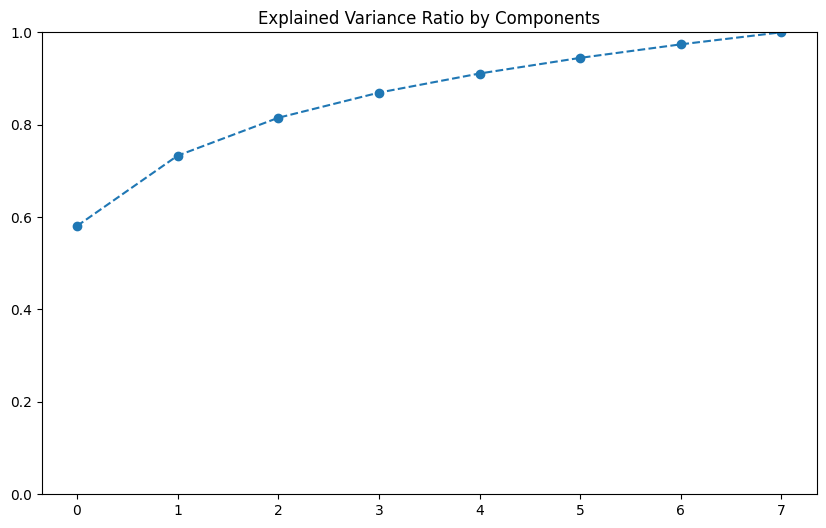

In [ ]:
# plot that as scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(full_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.ylim(0, 1)

plt.title('Explained Variance Ratio by Components')

In [ ]:
full_pca_data.shape

(34214400, 8)

In [ ]:
middle_vectors_full_pca, _ = extract_middle_vectors(torch.Tensor(full_pca_data))

middle_vectors_full_pca.shape

torch.Size([2365, 8])

## Within-encoding vector similarity

In [ ]:
all_encoded_cubes.shape

torch.Size([43, 55, 8, 24, 24, 24])

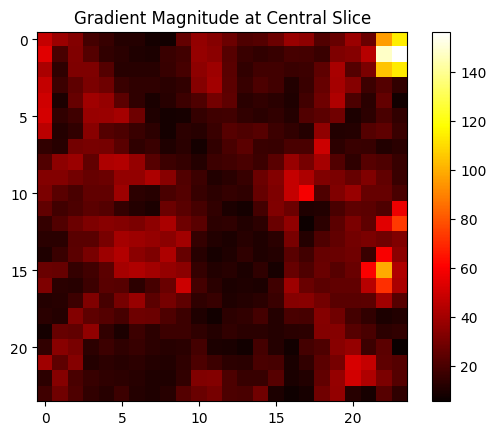

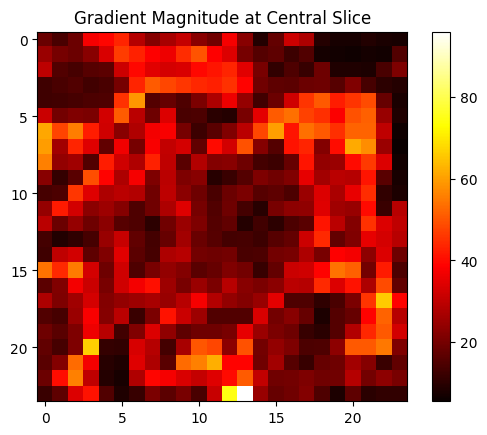

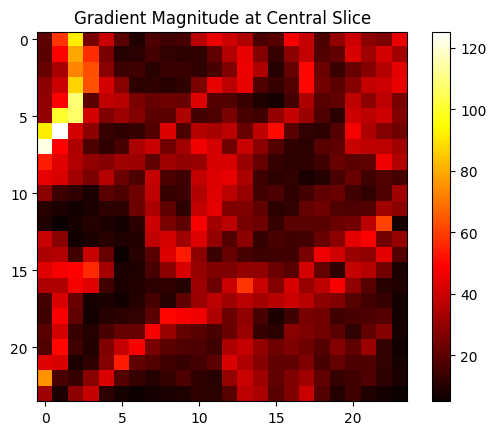

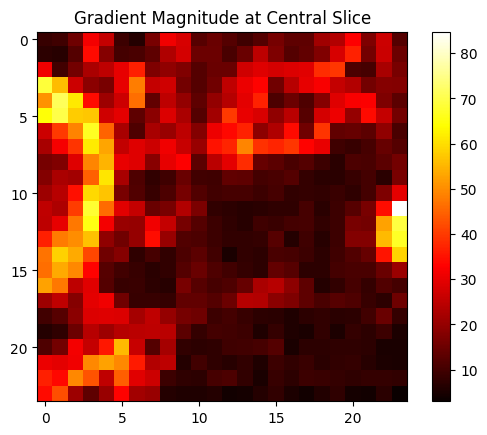

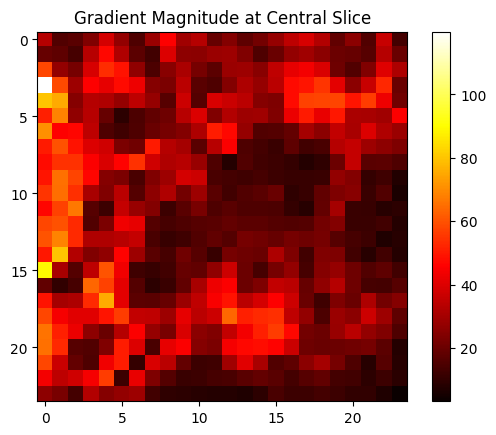

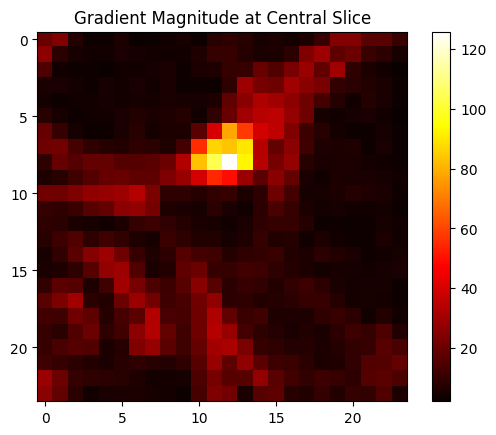

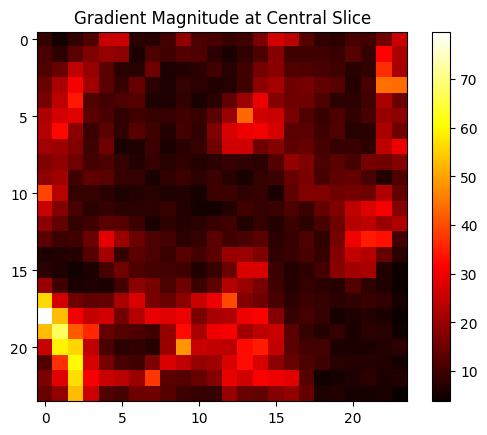

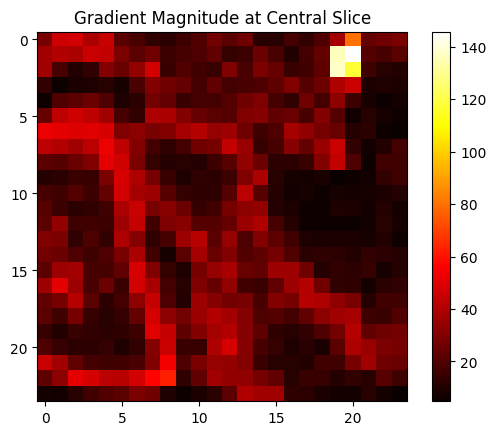

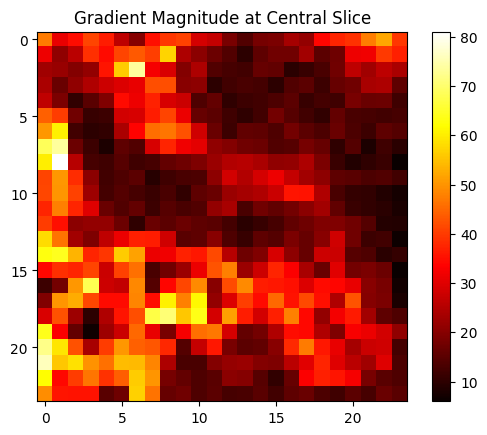

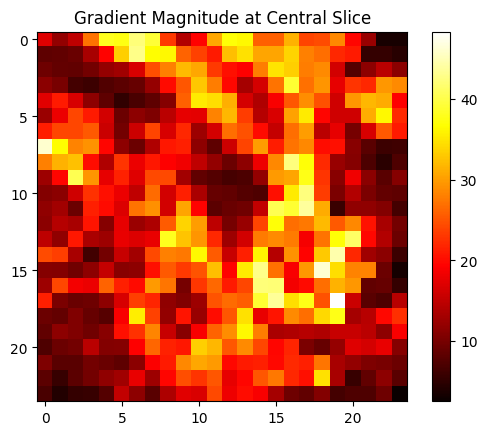

In [ ]:
for i in range(10):
    _ = compute_neighbor_similarity(all_encoded_cubes[i,0])

# Cluster

### Function Definitions 📚

In [49]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the organs dictionary
organs_dict = {
    'background/unlabeled': 0,  # For multi-class use case
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

# Define a fixed label order
default_label_order = [
    'background/unlabeled',
    'aorta',
    'gall_bladder',
    'spleen',
    'stomach',
    'kidney_right',
    'kidney_left',
    'liver',
    'pancreas',
    'postcava'
]

# Create a reverse mapping from label numbers to organ names
default_label_mapping = {v: k for k, v in organs_dict.items()}

def calculate_purities(data, labels, algorithms, plot=True, normalize_bars=True, label_mapping=None, label_order=None):
    # Default binary label mapping
    binary_label_mapping = {0: 'background/unlabeled', 1: 'pancreas'}

    # Determine the label mapping
    if label_mapping is None:
        unique_labels = sorted(pd.unique(labels))
        if unique_labels == [0, 1]:
            label_mapping = binary_label_mapping
        else:
            label_mapping = default_label_mapping

    if label_order is None:
        # Use default label order if label_mapping is default
        if label_mapping == default_label_mapping:
            label_order = default_label_order
        else:
            # Default label order based on the provided label mapping
            label_order = [label_mapping.get(lbl, lbl) for lbl in sorted(pd.unique(labels))]

    results = []

    # Clustering and purity calculation
    for name, estimator in tqdm(algorithms, desc="Clustering Algorithms", unit="alg"):
        estimator.fit(data)
        if hasattr(estimator, 'labels_'):
            cluster_labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            cluster_labels = estimator.predict(data)
        else:
            raise AttributeError(f"The estimator {name} does not have 'labels_' or 'predict' method.")

        df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[1])])
        df = df.reset_index(drop=True)
        df['Cluster'] = cluster_labels
        df['Labels'] = labels

        df_dd = dd.from_pandas(df, npartitions=4)
        df_dd['Cluster'] = df_dd['Cluster'].astype('category')
        df_dd['Labels'] = df_dd['Labels'].astype('category')
        df_dd = df_dd.persist()

        counts = df_dd.groupby(['Cluster', 'Labels']).size()
        counts_pd = counts.compute()
        cluster_label_counts = counts_pd.unstack(fill_value=0)
        cluster_label_ratio = cluster_label_counts.div(cluster_label_counts.sum(axis=1), axis=0)

        # Calculate total points per cluster
        cluster_sizes = cluster_label_counts.sum(axis=1)

        # Keep counts and ratios with prefixes to avoid naming conflicts
        count_cols = [f"Count_{label_mapping.get(col, col)}" for col in cluster_label_counts.columns]
        ratio_cols = [f"Ratio_{label_mapping.get(col, col)}" for col in cluster_label_ratio.columns]

        cluster_label_counts.columns = count_cols
        cluster_label_ratio.columns = ratio_cols

        purity_df = pd.concat([cluster_label_counts, cluster_label_ratio], axis=1).reset_index()
        purity_df['Algorithm'] = name

        if hasattr(estimator, 'n_clusters'):
            purity_df['n_clusters'] = estimator.n_clusters
        else:
            purity_df['n_clusters'] = None

        # Add cluster sizes to the DataFrame
        purity_df['Cluster_Size'] = cluster_sizes.values

        results.append(purity_df)

    final_df = pd.concat(results, ignore_index=True)

    # Plotting
    if plot:
        # Plotting the stacked bar chart
        for algo in final_df['Algorithm'].unique():
            algo_df = final_df[final_df['Algorithm'] == algo].copy()
            algo_df.set_index('Cluster', inplace=True)

            # Ensure the 'Cluster' index is of integer type and sorted
            algo_df.index = algo_df.index.astype(int)
            algo_df.sort_index(inplace=True)

            # Identify ratio and count columns
            ratio_cols = [col for col in algo_df.columns if col.startswith('Ratio_')]
            count_cols = [col for col in algo_df.columns if col.startswith('Count_')]

            # Get labels
            ratio_labels = [col.replace('Ratio_', '') for col in ratio_cols]
            count_labels = [col.replace('Count_', '') for col in count_cols]

            # Create mapping from labels to columns
            ratio_col_map = dict(zip(ratio_labels, ratio_cols))
            count_col_map = dict(zip(count_labels, count_cols))

            # Ensure labels are in consistent order
            labels_in_data = [label for label in label_order if label in ratio_labels or label in count_labels]

            if normalize_bars:
                # Use purity ratios for plotting (bars of height 1)
                columns_to_plot = [ratio_col_map[label] for label in labels_in_data]
                algo_df_plot = algo_df[columns_to_plot]
            else:
                # Use counts for plotting (bars of varying heights based on cluster sizes)
                columns_to_plot = [count_col_map[label] for label in labels_in_data]
                algo_df_plot = algo_df[columns_to_plot]

            # Rename columns to labels for plotting
            algo_df_plot.columns = labels_in_data

            # Generate colors based on the fixed label order
            n_labels_total = len(label_order)
            colors_palette = sns.color_palette("tab10", n_labels_total)
            label_to_color = dict(zip(label_order, colors_palette))
            colors = [label_to_color.get(label, 'grey') for label in labels_in_data]

            # Plotting the stacked bar chart
            fig, ax = plt.subplots(figsize=(12, 8))

            algo_df_plot.plot(
                kind='bar',
                stacked=True,
                edgecolor='black',
                color=colors,
                ax=ax
            )

            # Adding labels and title
            ax.set_xlabel('Cluster', fontsize=14)
            y_label = 'Purity Ratio' if normalize_bars else 'Number of Points'
            ax.set_ylabel(y_label, fontsize=14)
            title_suffix = ' (Normalized)' if normalize_bars else ' (By Cluster Size)'
            ax.set_title(f'Purity Ratios per Cluster for {algo}{title_suffix}', fontsize=16)

            # Adding cluster size annotations above each bar
            for idx, row in enumerate(algo_df.itertuples()):
                total_height = algo_df_plot.iloc[idx].sum()
                ax.text(
                    idx,
                    total_height + ax.get_ylim()[1]*0.01,
                    f"{int(row.Cluster_Size):,}",
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    rotation=90
                )

            # Adjusting legend
            handles, labels_ = ax.get_legend_handles_labels()
            ax.legend(handles, labels_in_data, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

            algo_df.reset_index(inplace=True)

    return final_df

def cluster_and_plot_purities(data, labels, cluster_range=range(2, 51, 2), plot=True, random_state=42, normalize_bars=True, label_mapping=None, label_order=None):
    import warnings

    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
    )

    algorithms = []

    for n_clusters in cluster_range:
        mbk_name = f'MiniBatchKMeans_n{n_clusters}'
        mbk = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            batch_size=10000,
            init='k-means++',
            n_init='auto'
        )
        algorithms.append((mbk_name, mbk))

    purity_results = calculate_purities(
        data=data,
        labels=labels,
        algorithms=algorithms,
        plot=plot,
        normalize_bars=normalize_bars,
        label_mapping=label_mapping,
        label_order=label_order
    )

    return purity_results, algorithms

def plot_prior_distribution(labels, label_mapping=None, label_order=None):
    """
    Plot the prior distribution of the original labels as a bar chart.

    Parameters:
    - labels: array-like, shape (n_samples,)
        The true labels.
    - label_mapping: dict, optional
        Dictionary mapping label numbers to organ names.
    - label_order: list, optional
        List defining the order of labels for consistent plotting.
    """
    # Calculate the label distribution (counts and proportions)
    label_counts = pd.Series(labels).value_counts().sort_index()
    label_proportions = label_counts / label_counts.sum()

    # Use provided label mapping or default
    if label_mapping is None:
        label_mapping = default_label_mapping

    # Map label numbers to names
    label_names = [label_mapping.get(lbl, lbl) for lbl in label_counts.index]

    # Create a DataFrame for plotting
    label_df = pd.DataFrame({
        'Label': label_names,
        'Count': label_counts.values,
        'Proportion': label_proportions.values
    })

    # If label_order is not provided, infer it from label_mapping
    if label_order is None:
        label_order = [label_mapping.get(lbl, lbl) for lbl in sorted(label_mapping.keys())]

    # Ensure the DataFrame is ordered according to label_order
    label_df.set_index('Label', inplace=True)

    # Only include labels that are present in the data
    labels_in_data = [label for label in label_order if label in label_df.index]
    label_df = label_df.loc[labels_in_data].reset_index()

    # Generate colors based on labels present
    n_labels_total = len(label_order)
    colors_palette = sns.color_palette("tab10", n_labels_total)
    label_to_color = dict(zip(label_order, colors_palette))
    colors = [label_to_color.get(label, 'grey') for label in labels_in_data]

    # Plotting the bar chart for the prior distribution
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(label_df['Label'], label_df['Proportion'], color=colors, edgecolor='black')

    # Adding labels and title
    ax.set_xlabel('Tissue Type', fontsize=14)
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_title('Prior Distribution of Tissue Types', fontsize=16)

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [24]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

# Labels: AbdomenAtlas Multi-Organ Segmentations

## 1-away Stencil vectors + Center

Sampled Cubes Random State 2 results not interesting

In [52]:
flat_enc_cts = flatten_features(all_encoded_cubes)
stencil_vecs_1, _ = extract_stencil_vectors(flat_enc_cts, n_samples=all_encoded_cubes.shape[0], distance=1)

In [53]:
labels = sampled_points_multi_organ_labels.flatten().numpy()

In [ ]:
data = stencil_vecs_1.numpy()
cluster_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=range(2,51,2))

## 2-away stencil

Sampled Cubes Random State 2 results not interesting - omitted to keep notebook size reasonable. Rerun as neccesaary.

In [48]:
flat_enc_cts = flatten_features(all_encoded_cubes)
stencil_vecs_2, _ = extract_stencil_vectors(flat_enc_cts, n_samples=all_encoded_cubes.shape[0], distance=2)#.unsqueeze(0))#(0))[0]

In [49]:
stencil_vecs_2.shape

torch.Size([2365, 56])

In [50]:

labels = sampled_points_multi_organ_labels.flatten().numpy()

In [ ]:
data = stencil_vecs_2.numpy()
cluster_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=range(2,51,2))

## 4-away Stencil vectors + Center

In [39]:
all_encoded_cubes[0,0].shape

torch.Size([8, 24, 24, 24])

In [40]:
flat_enc_cts = flatten_features(all_encoded_cubes)
stencil_vecs, _ = extract_stencil_vectors(flat_enc_cts, n_samples=all_encoded_cubes.shape[0])#.unsqueeze(0))#(0))[0]

In [41]:
stencil_vecs.shape

torch.Size([2365, 56])

In [42]:
data = stencil_vecs.numpy()
labels = sampled_points_multi_organ_labels.flatten().numpy()

Clustering Algorithms: 100%|██████████| 49/49 [00:35<00:00,  1.37alg/s]


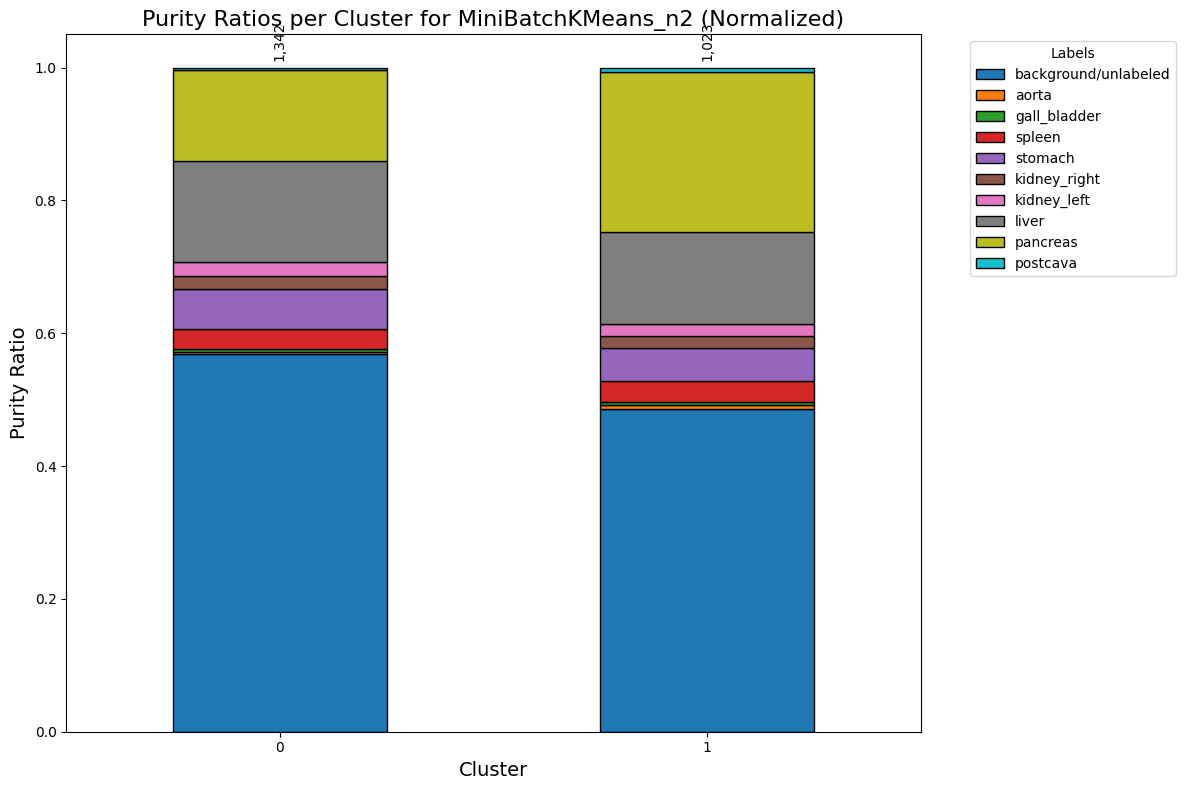

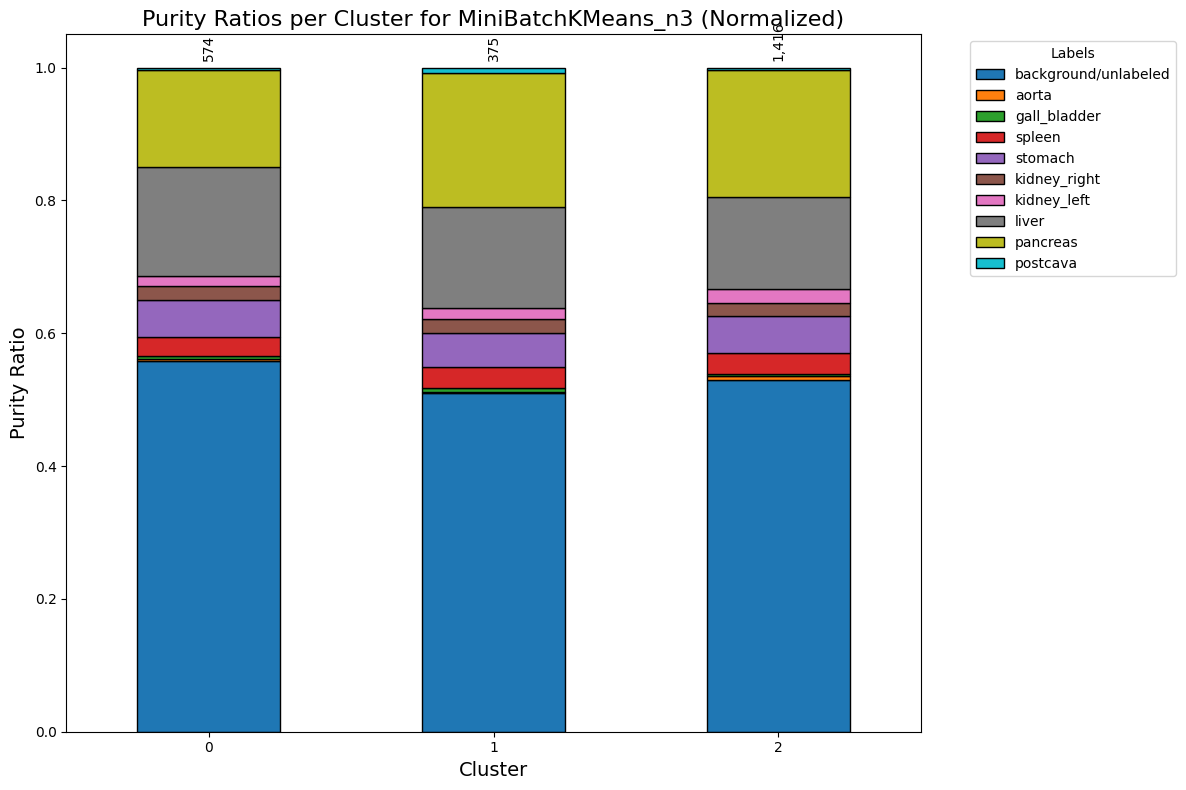

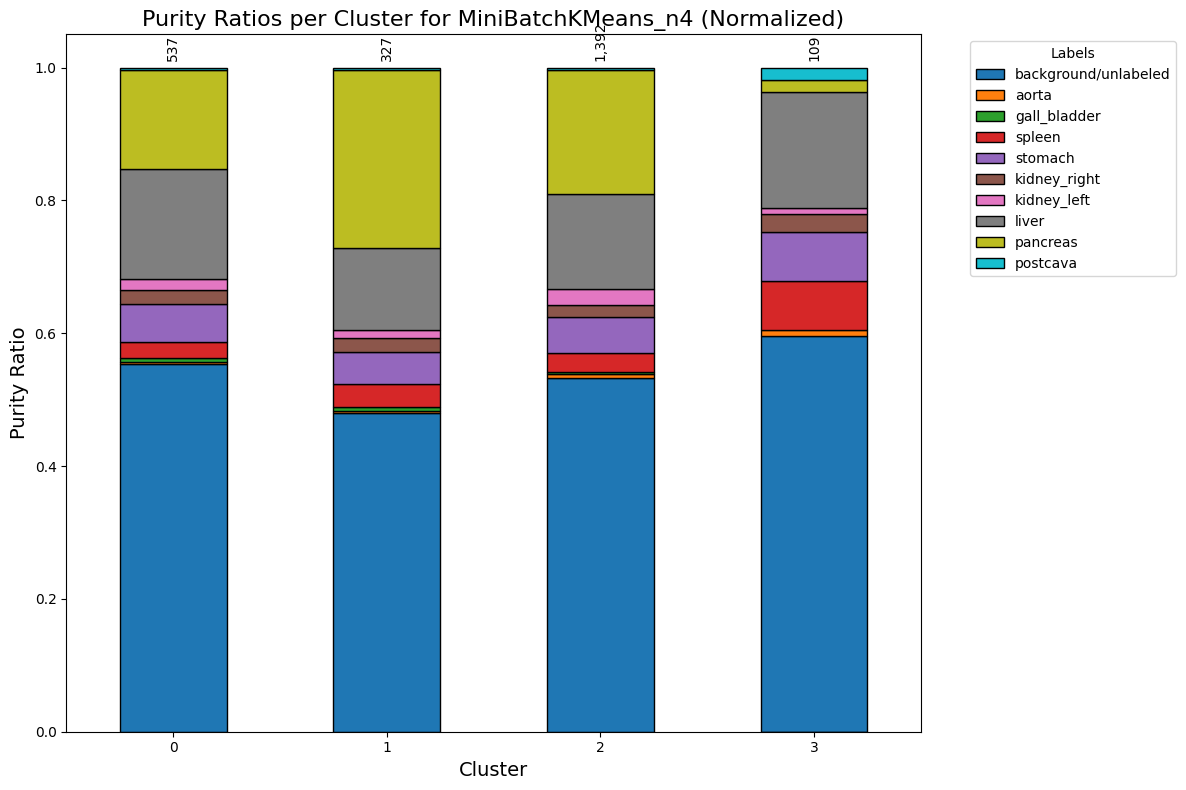

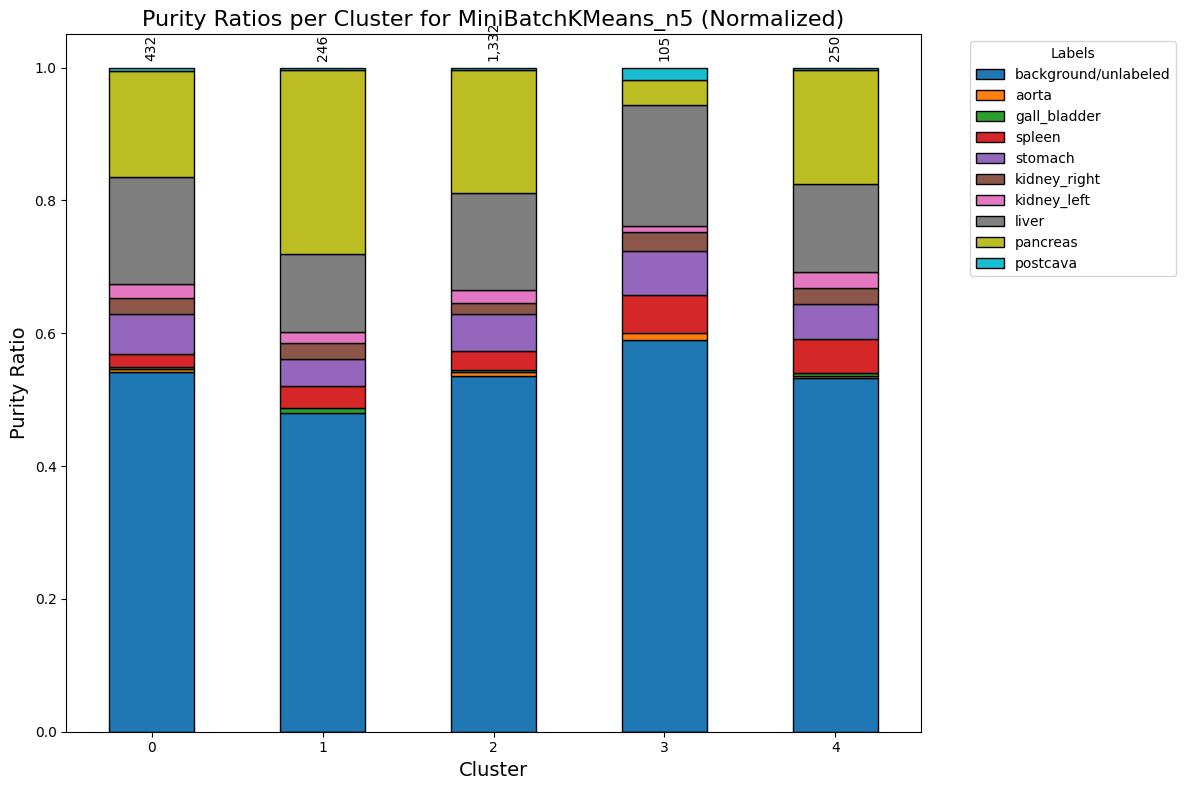

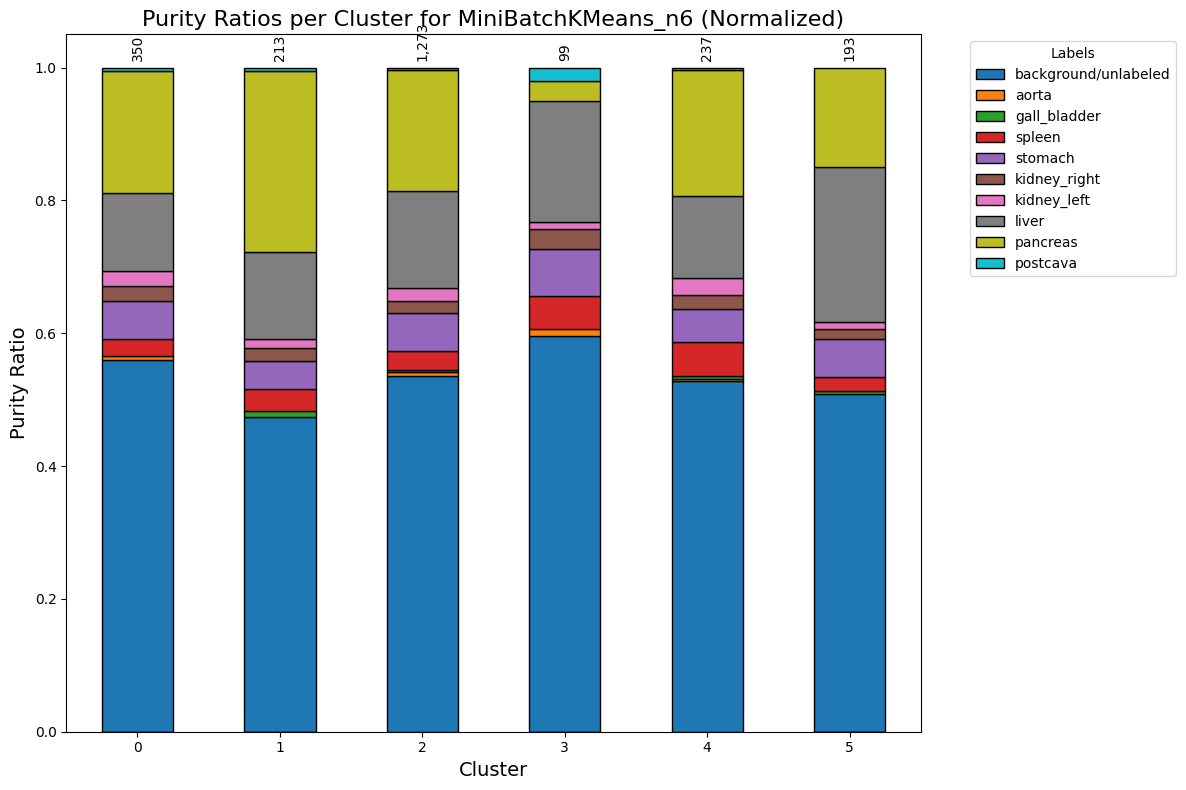

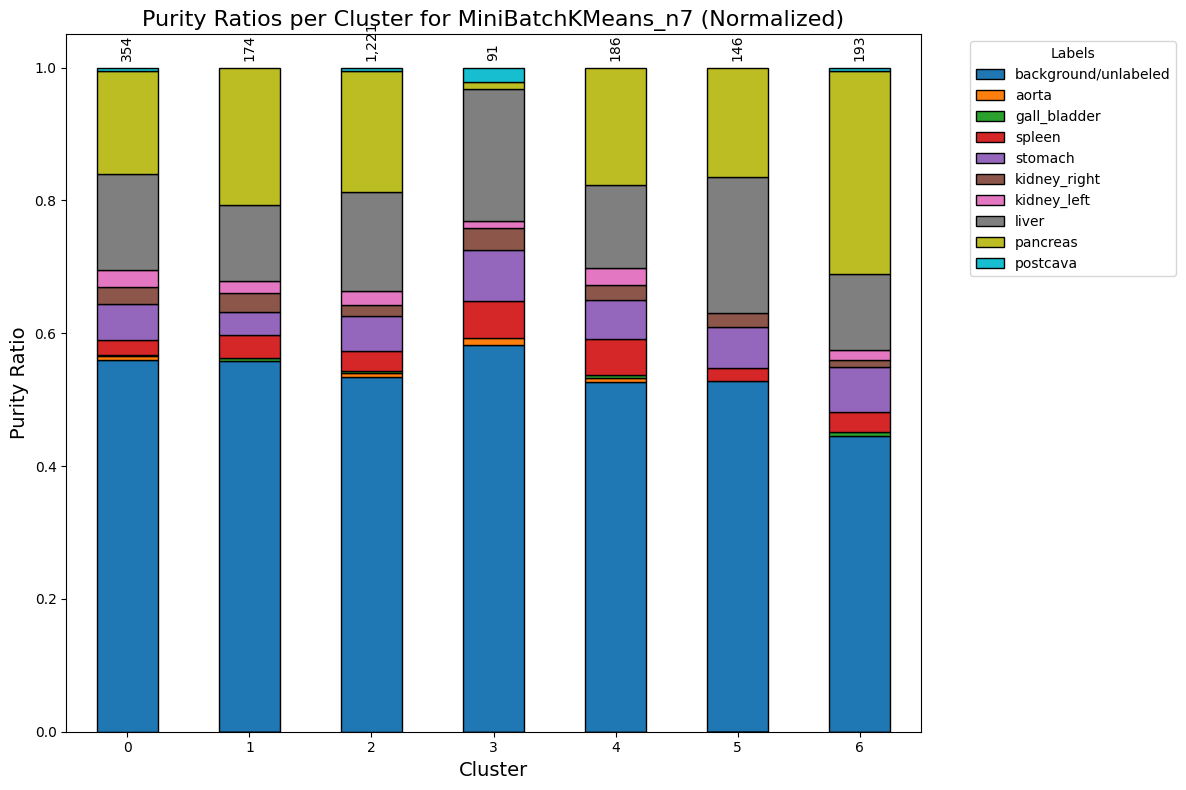

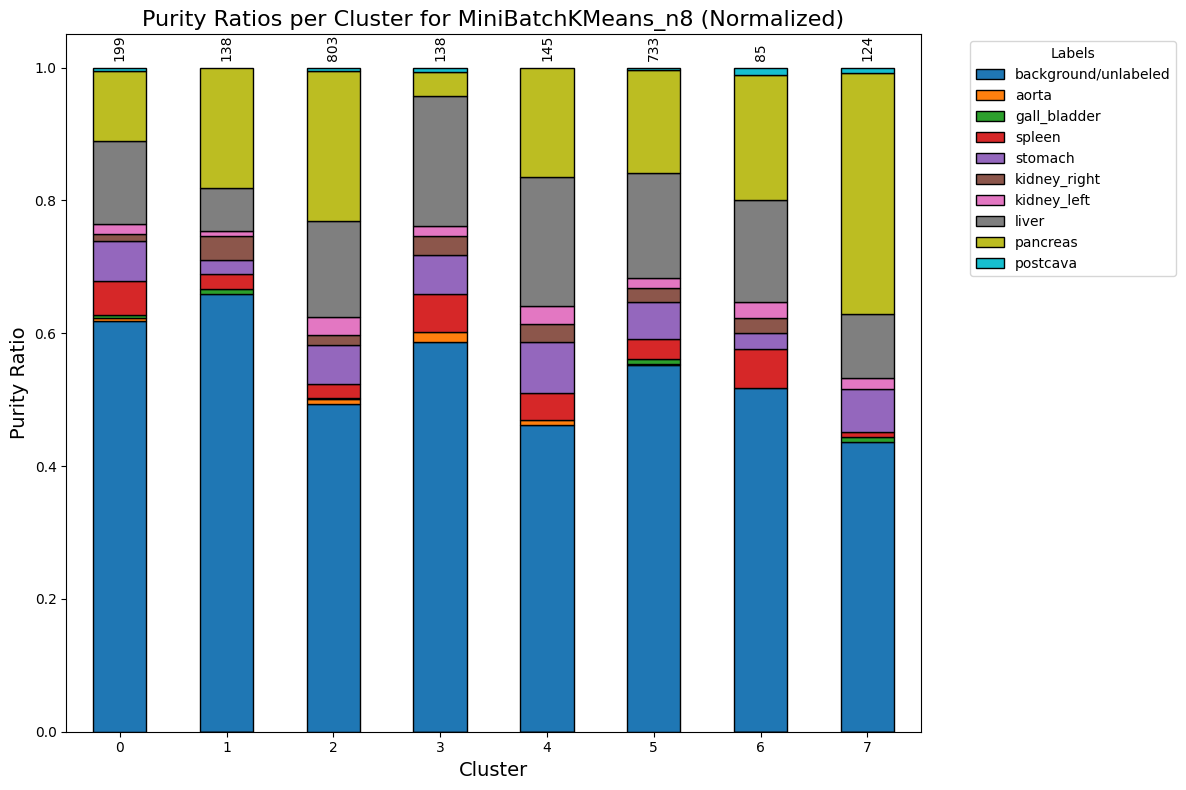

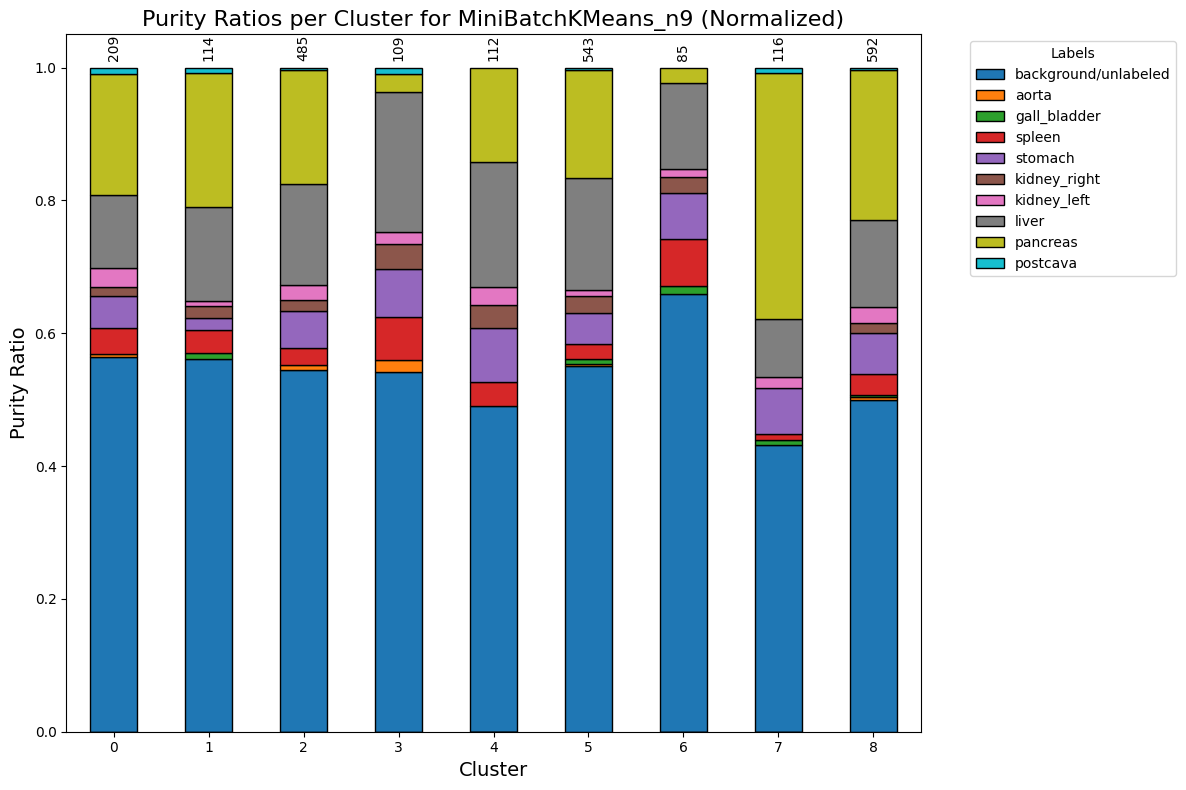

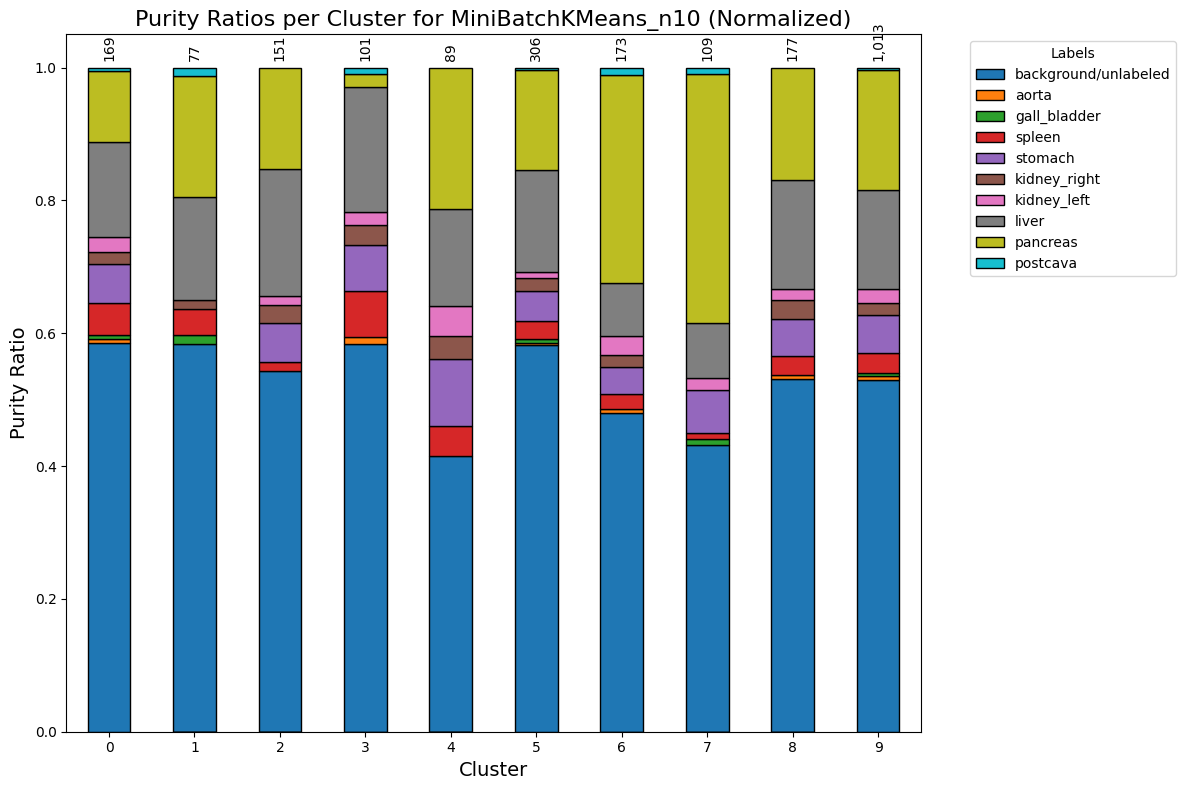

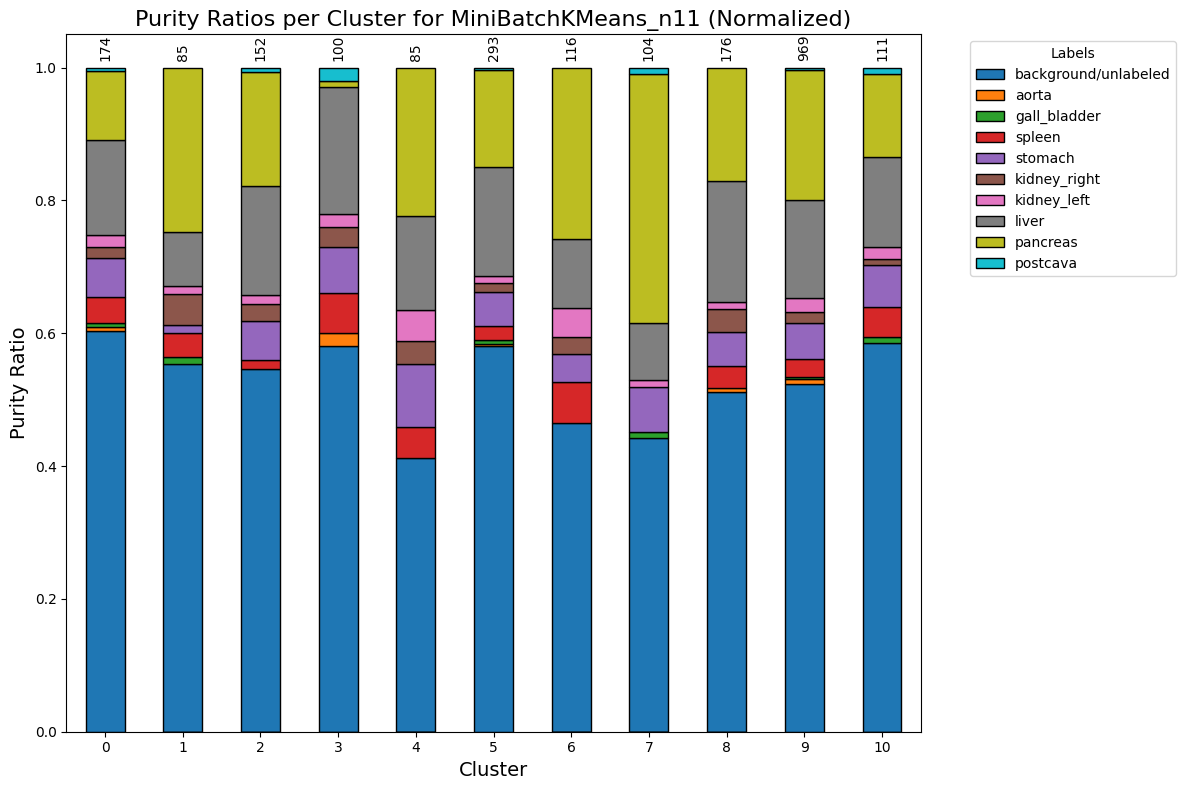

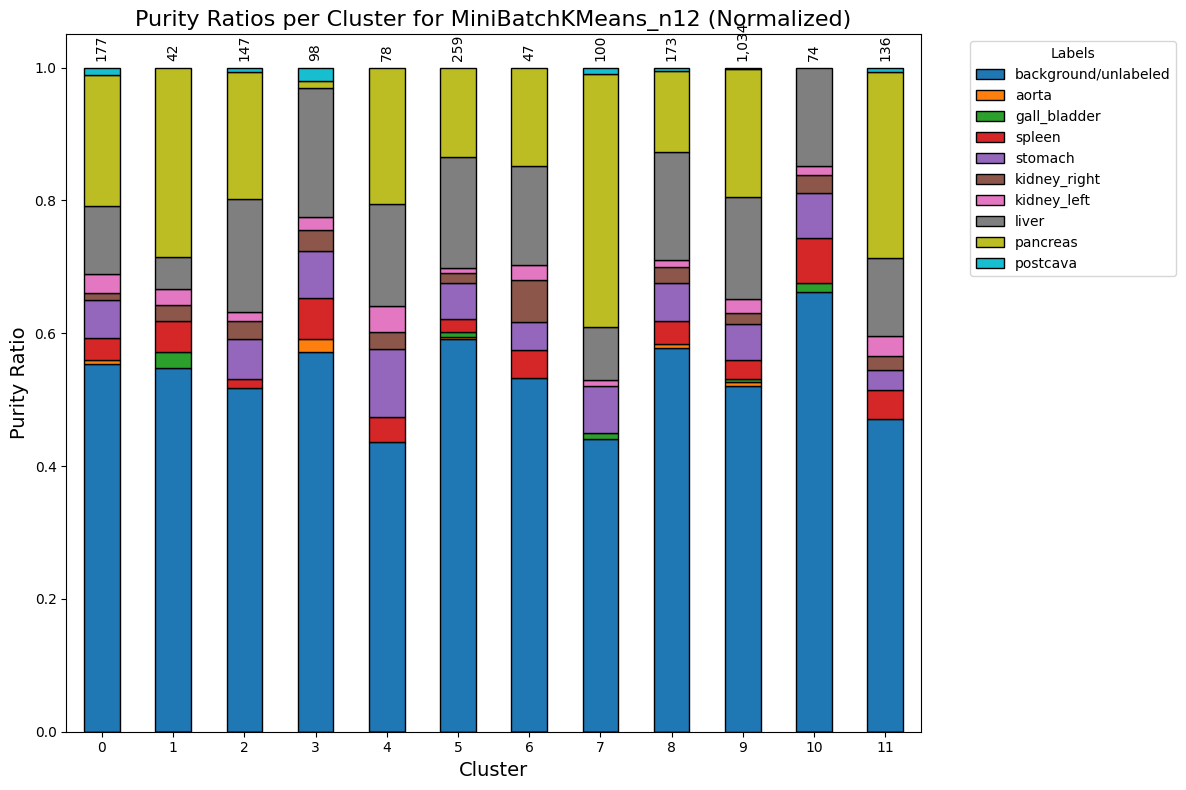

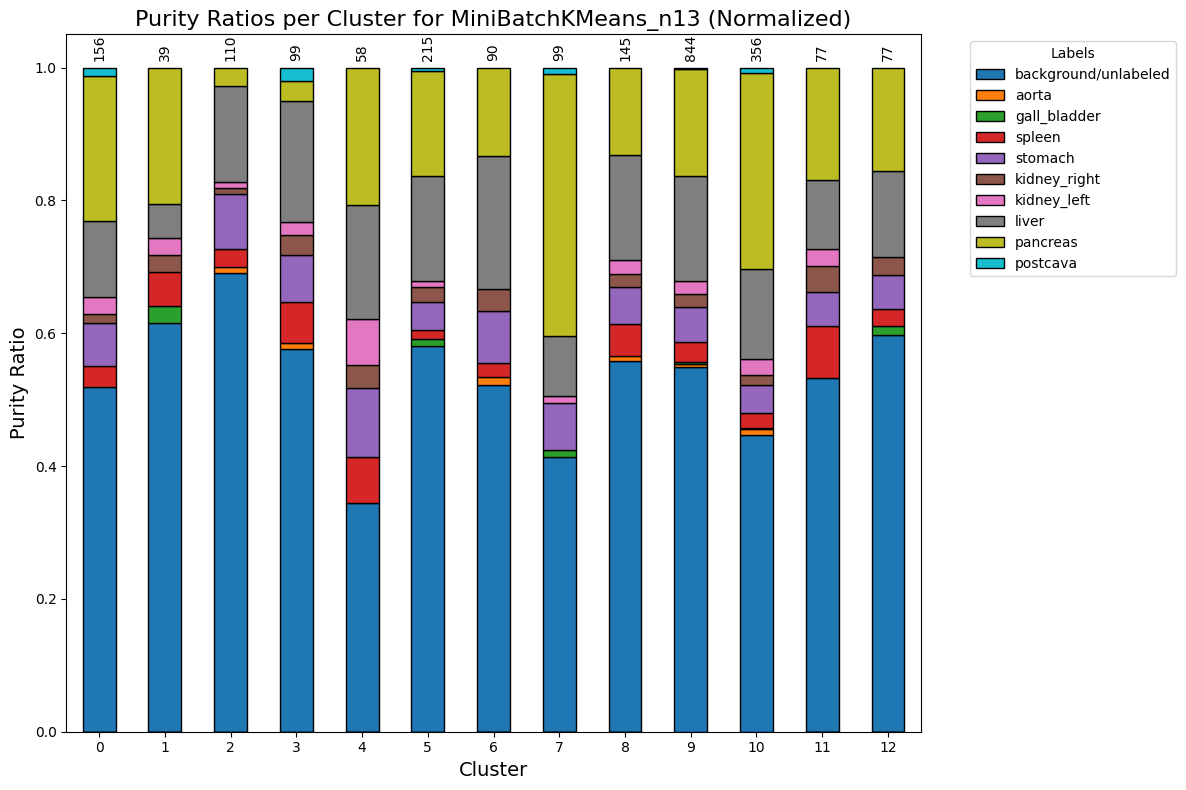

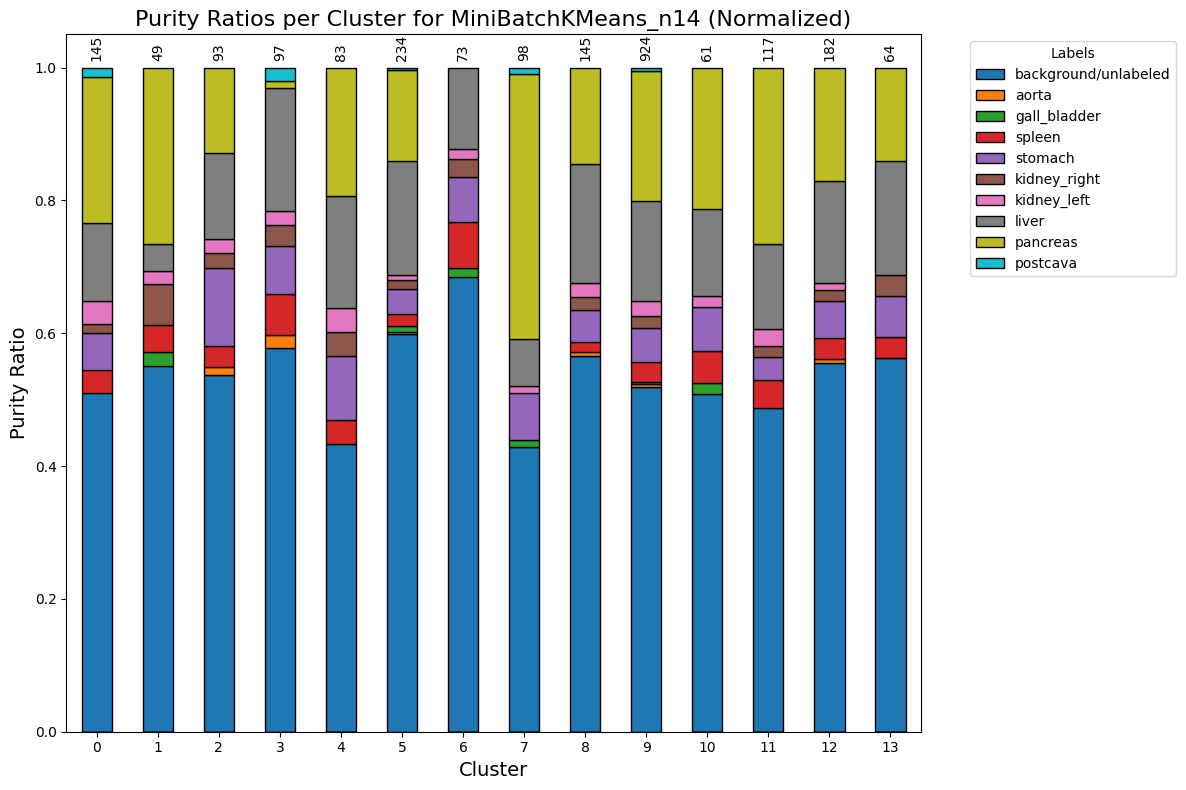

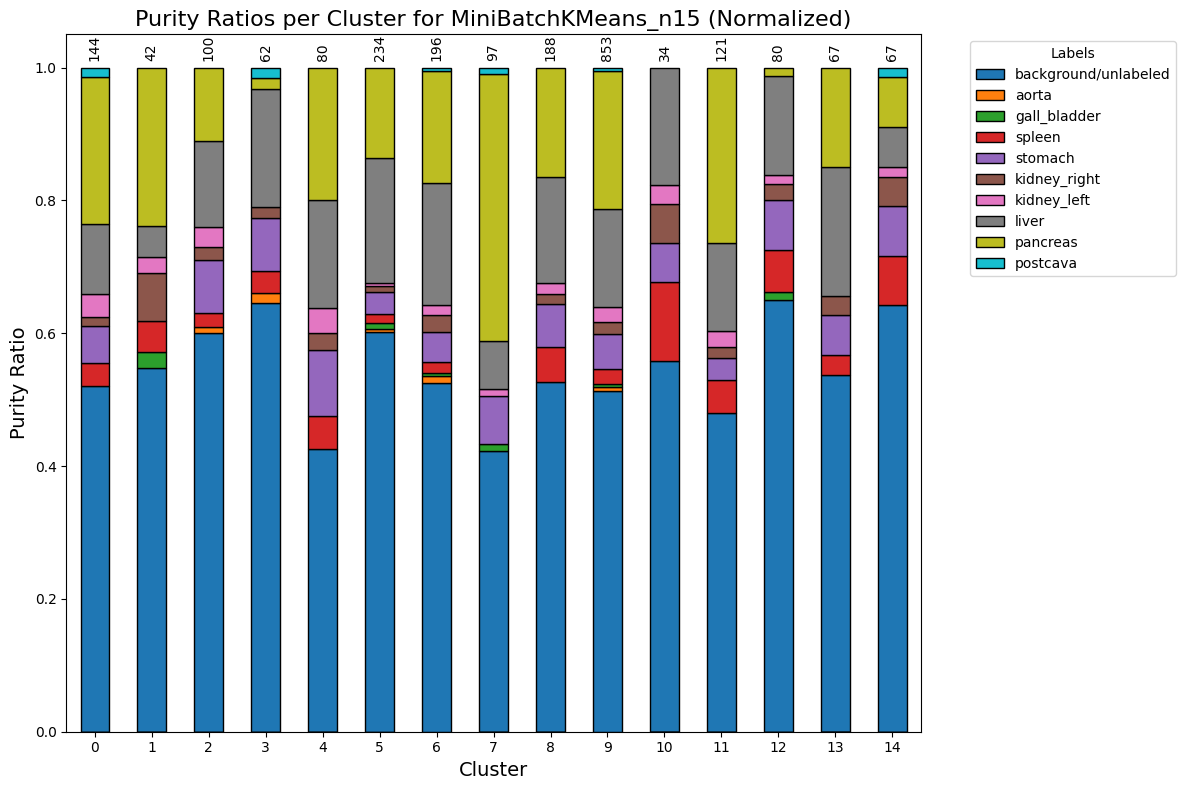

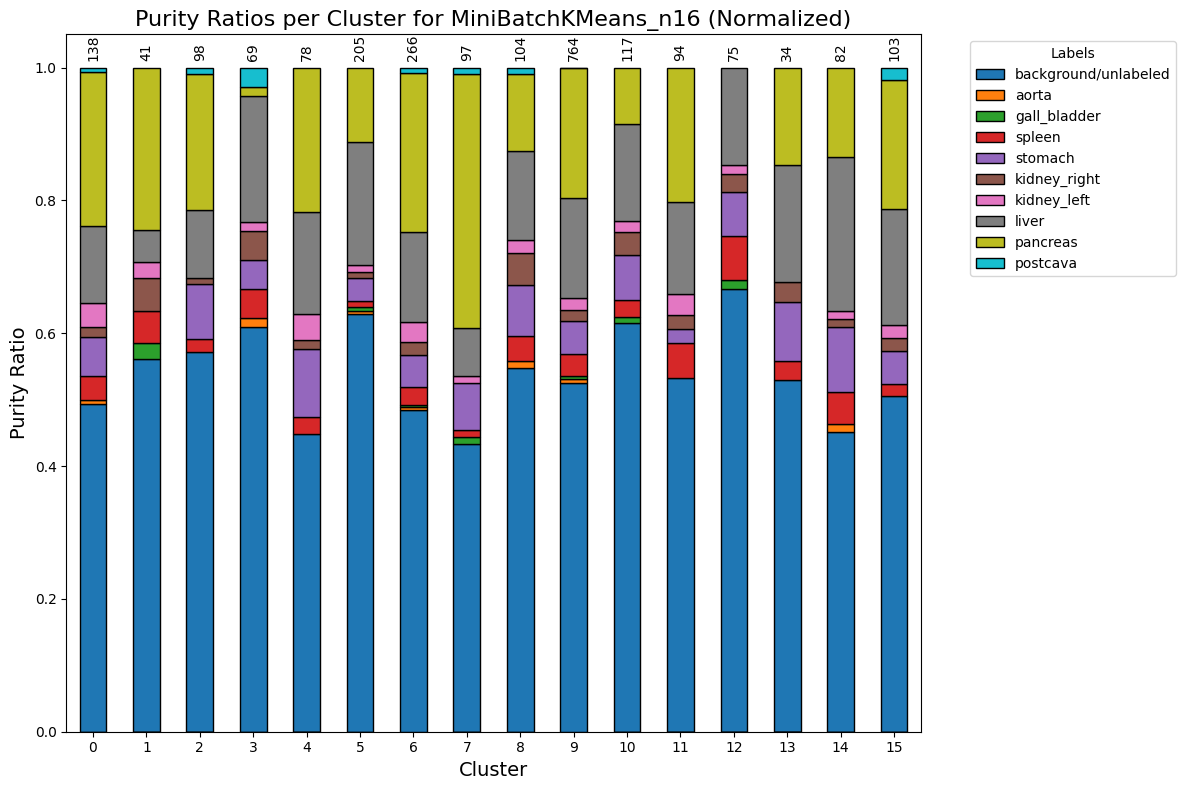

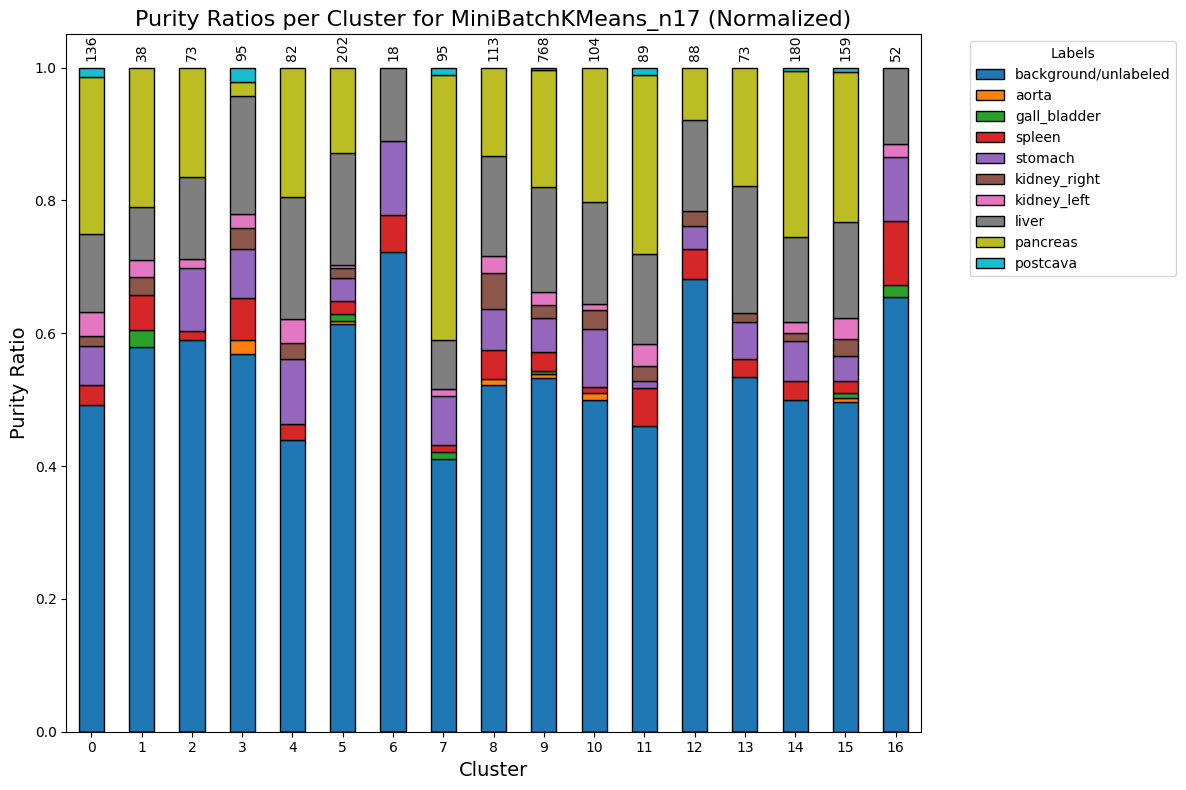

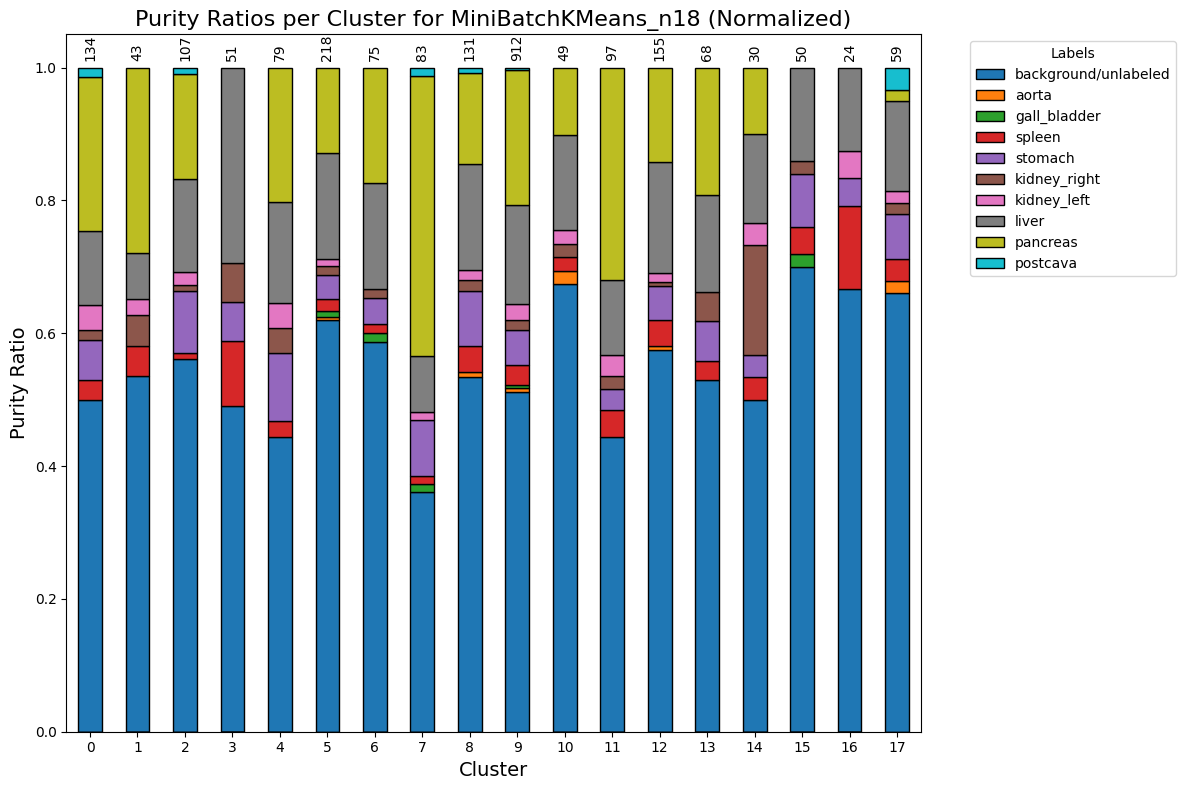

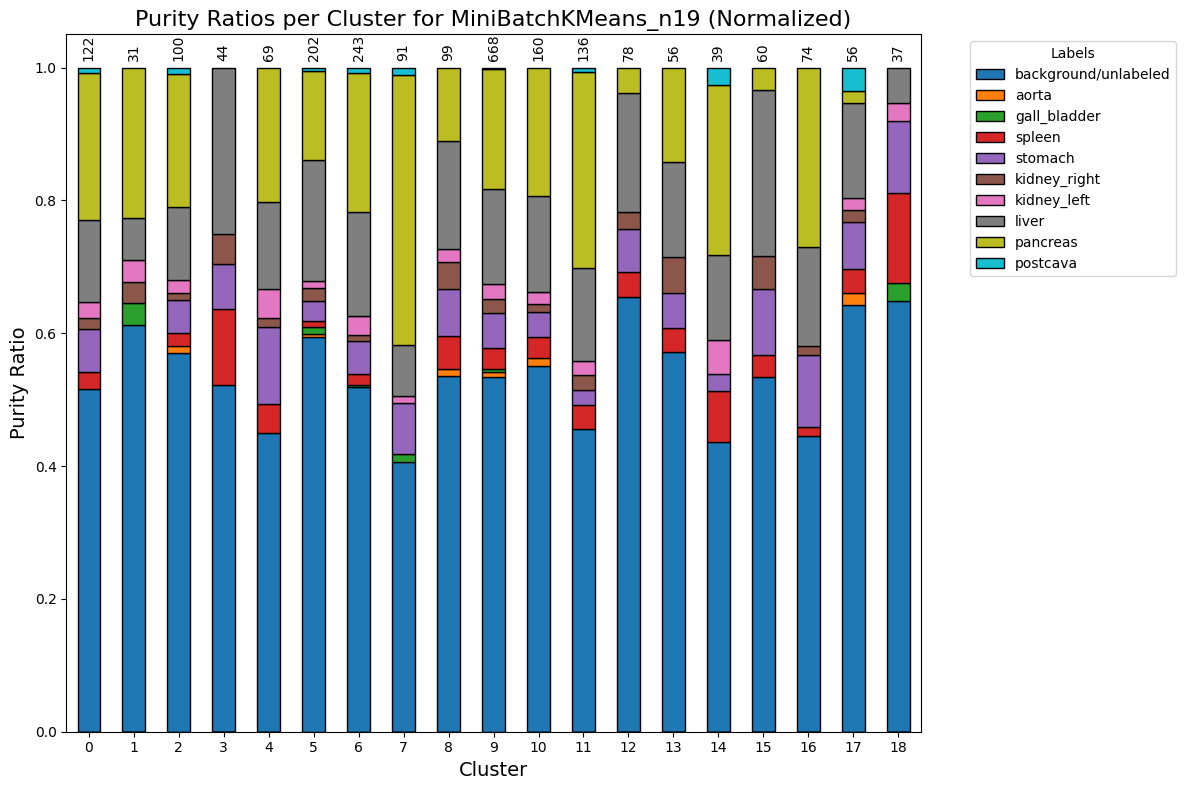

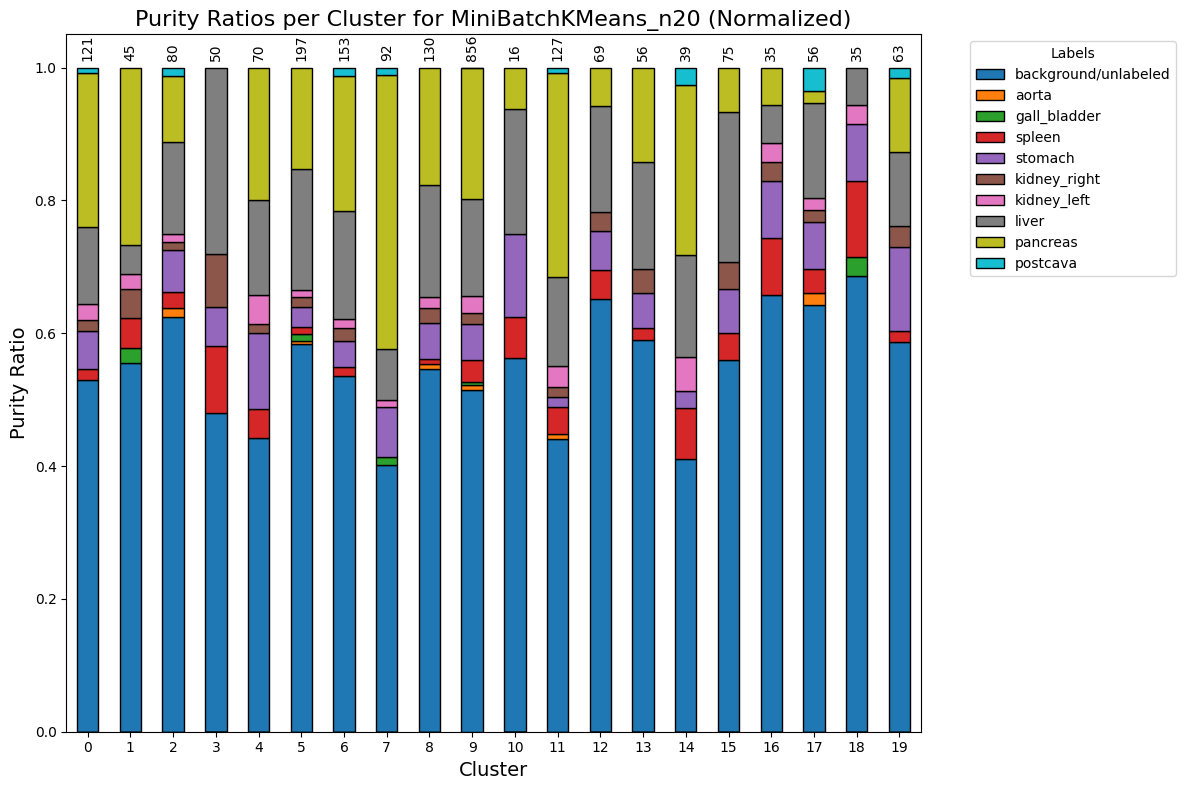

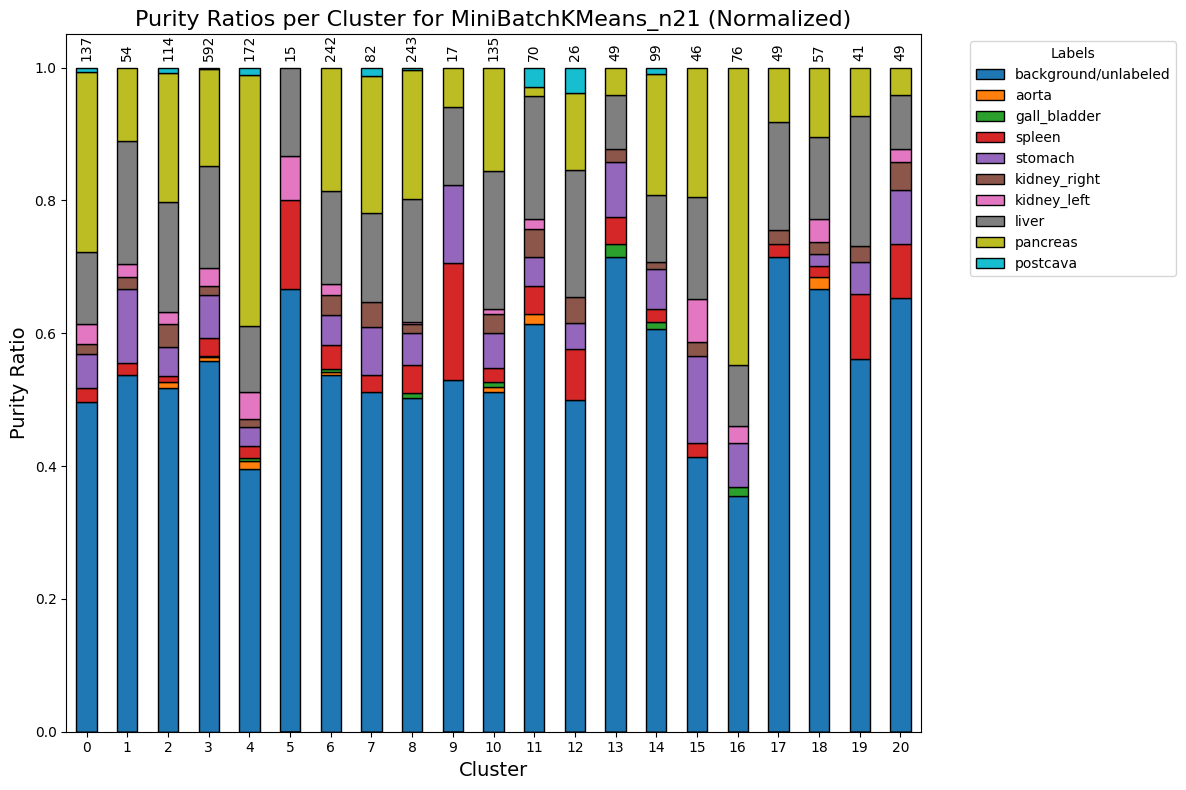

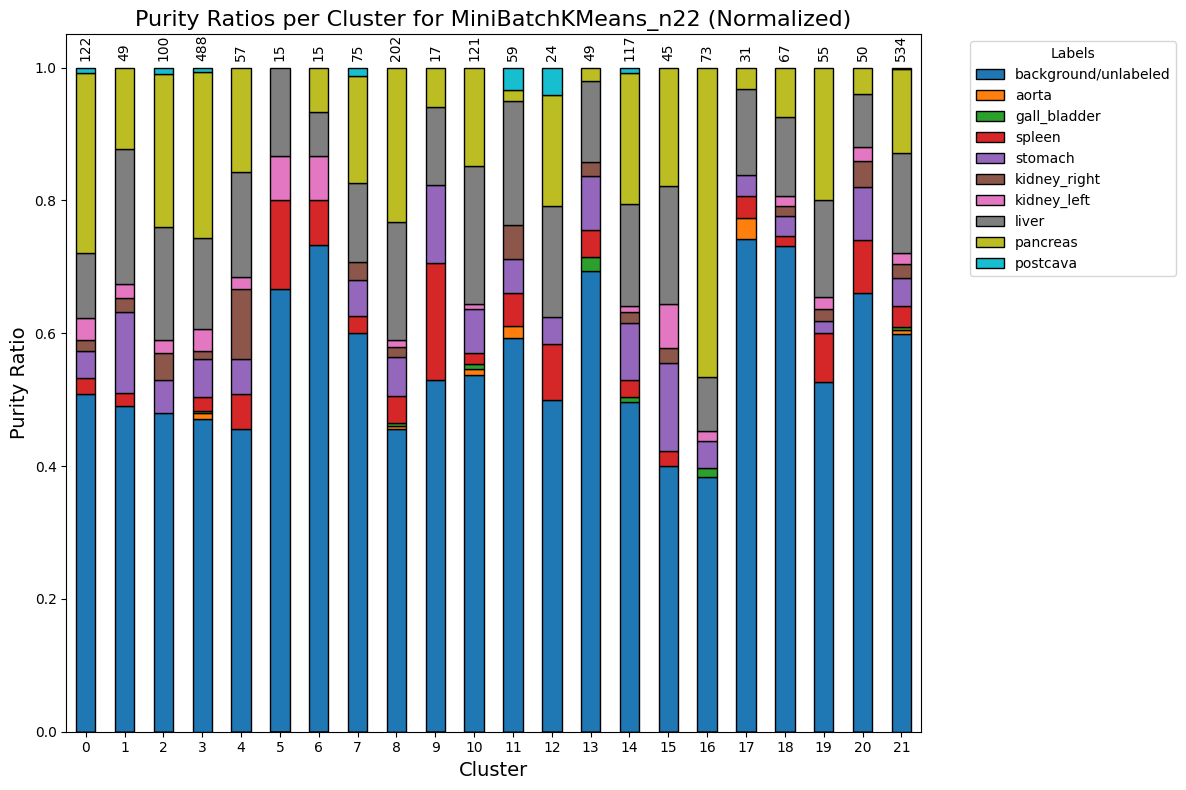

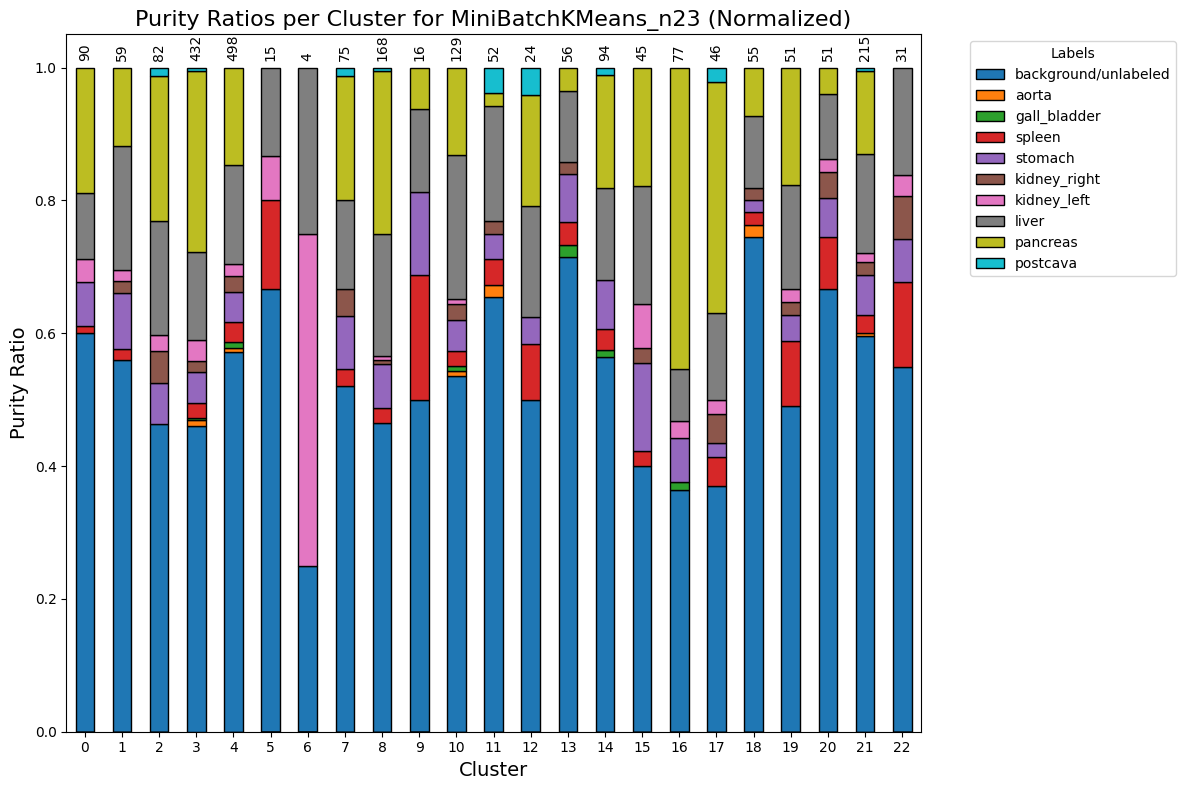

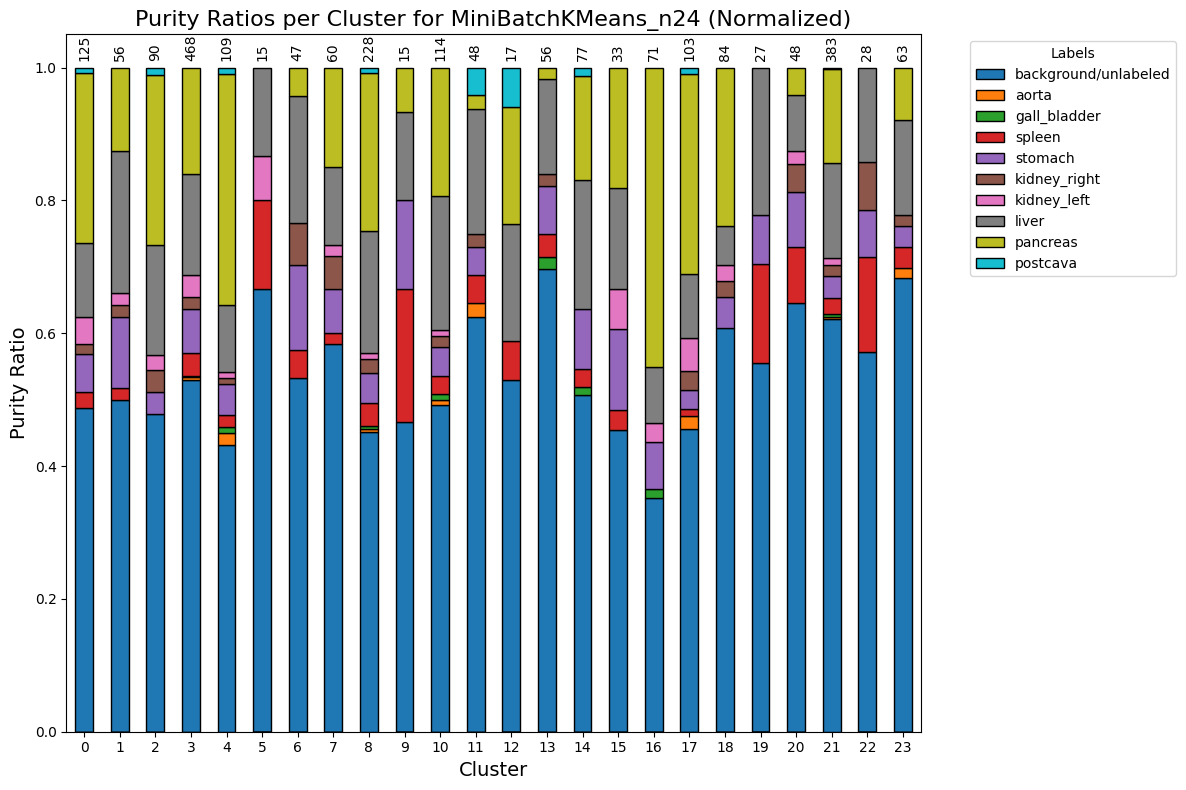

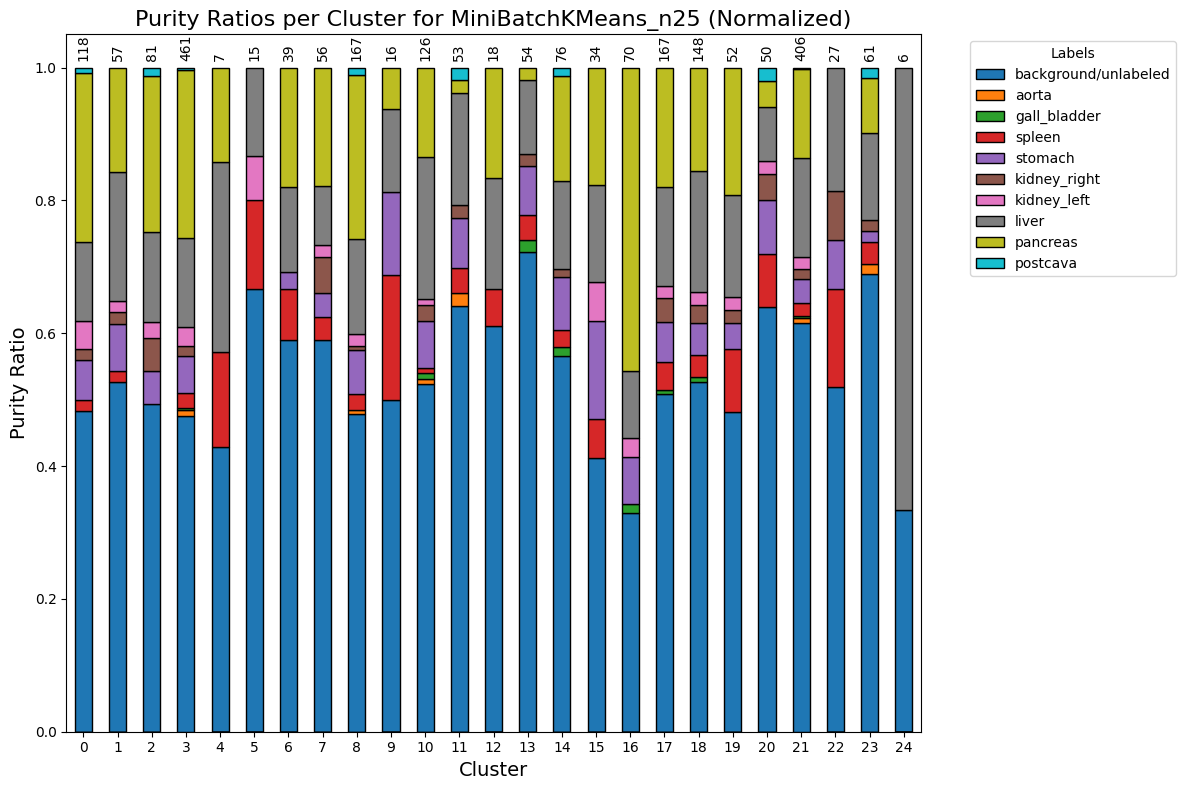

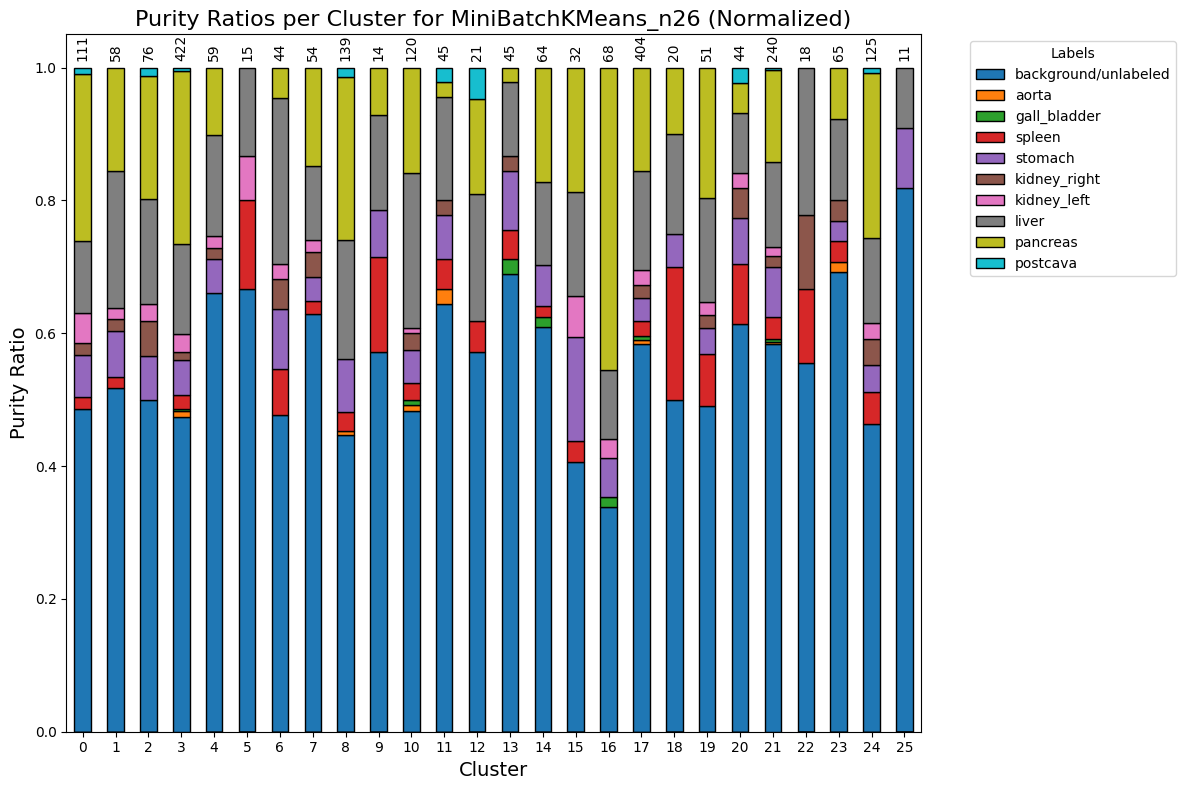

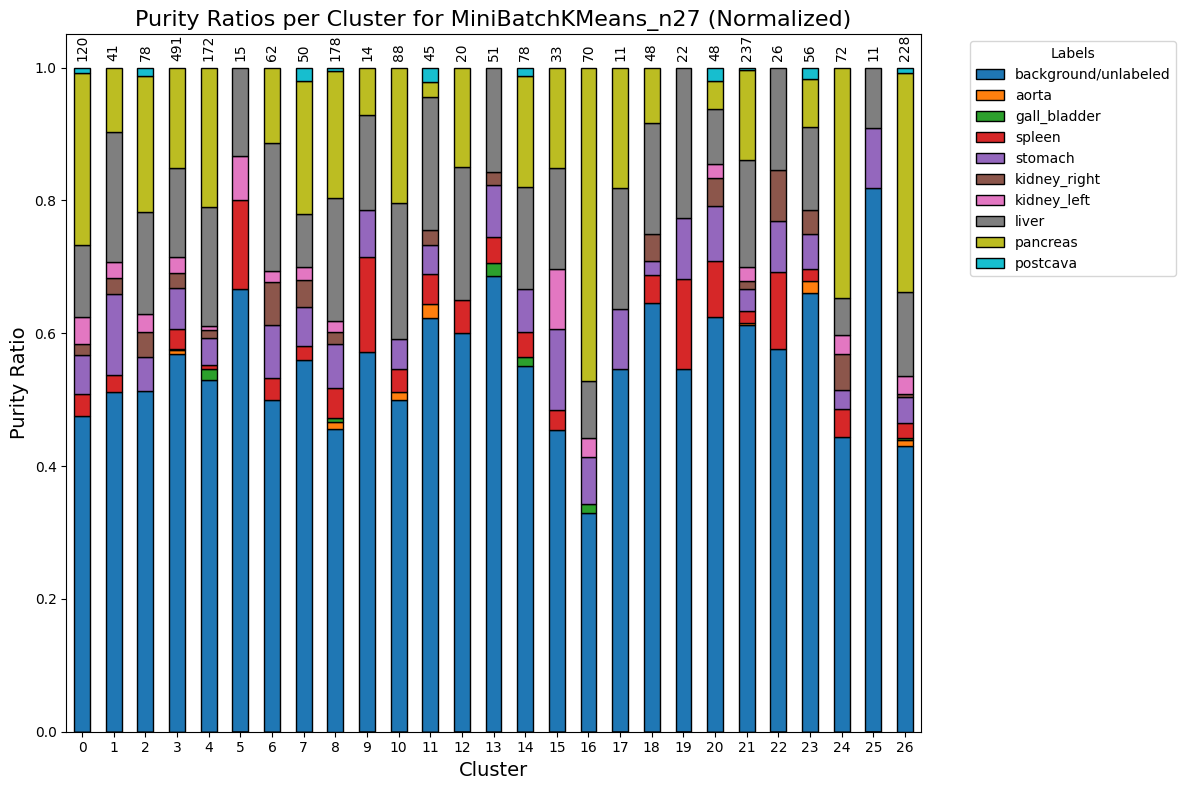

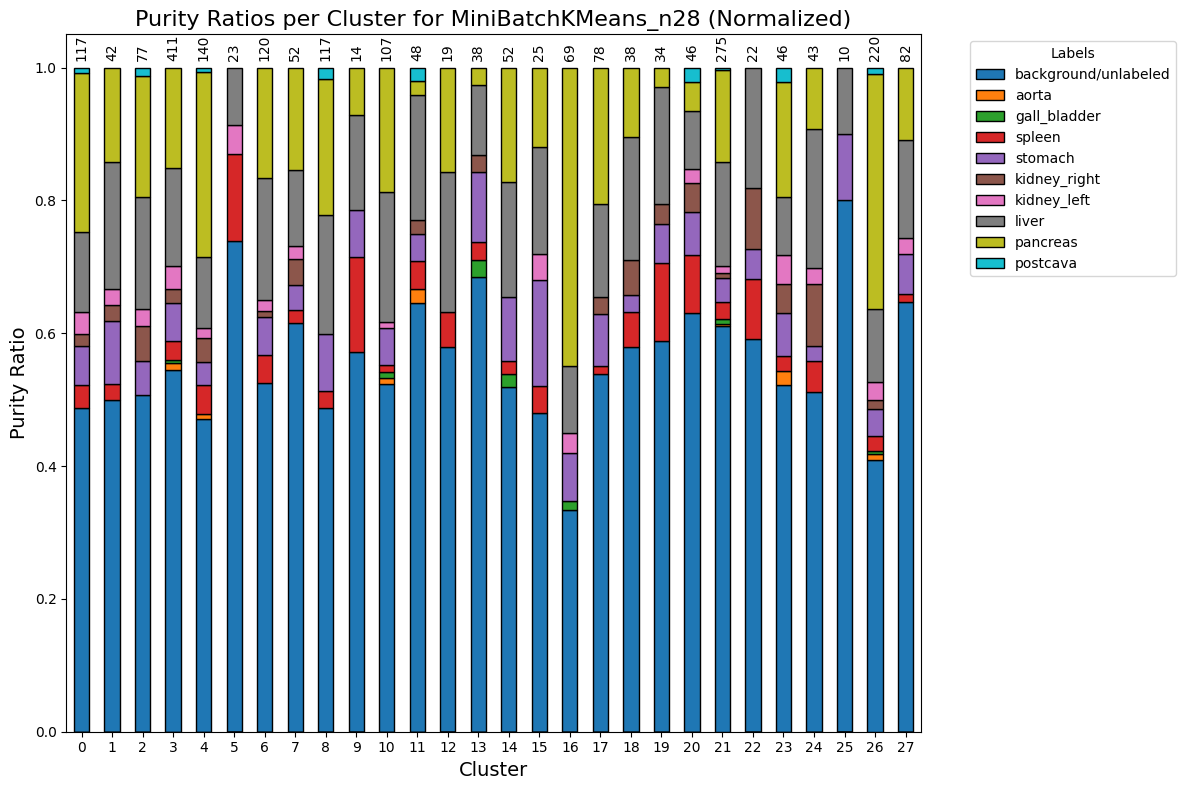

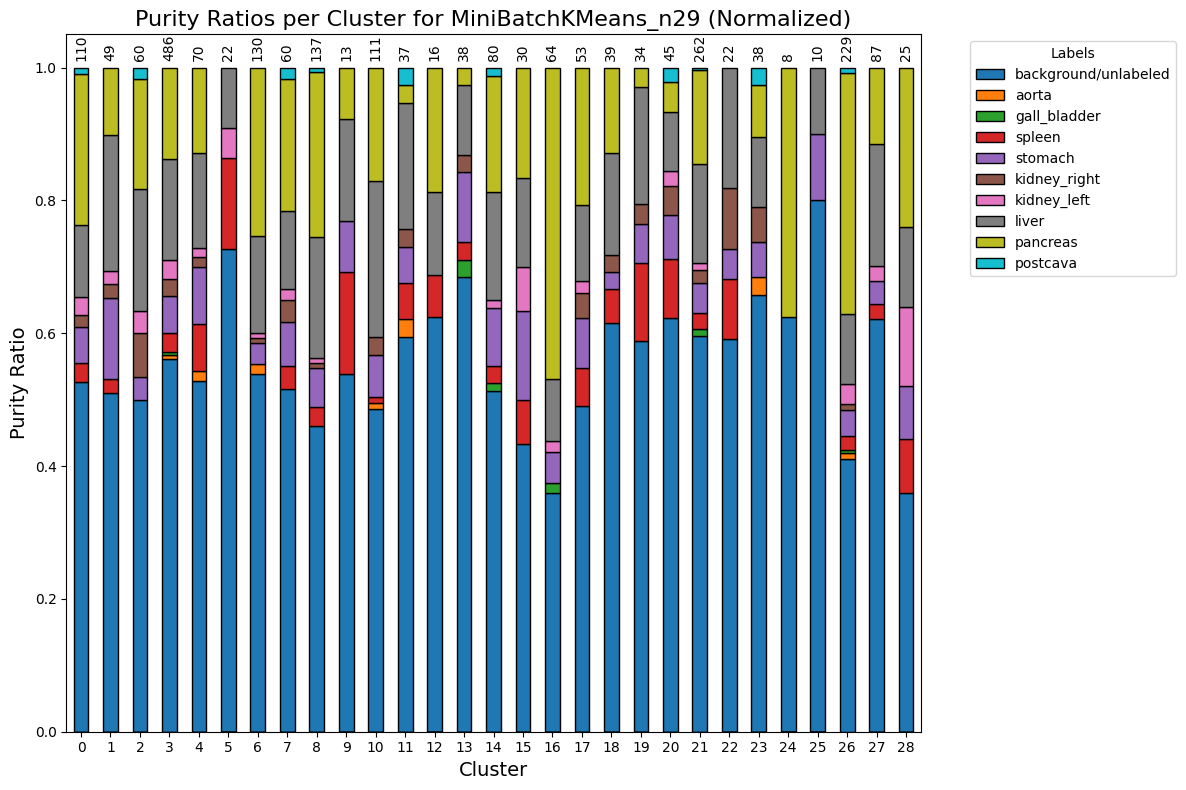

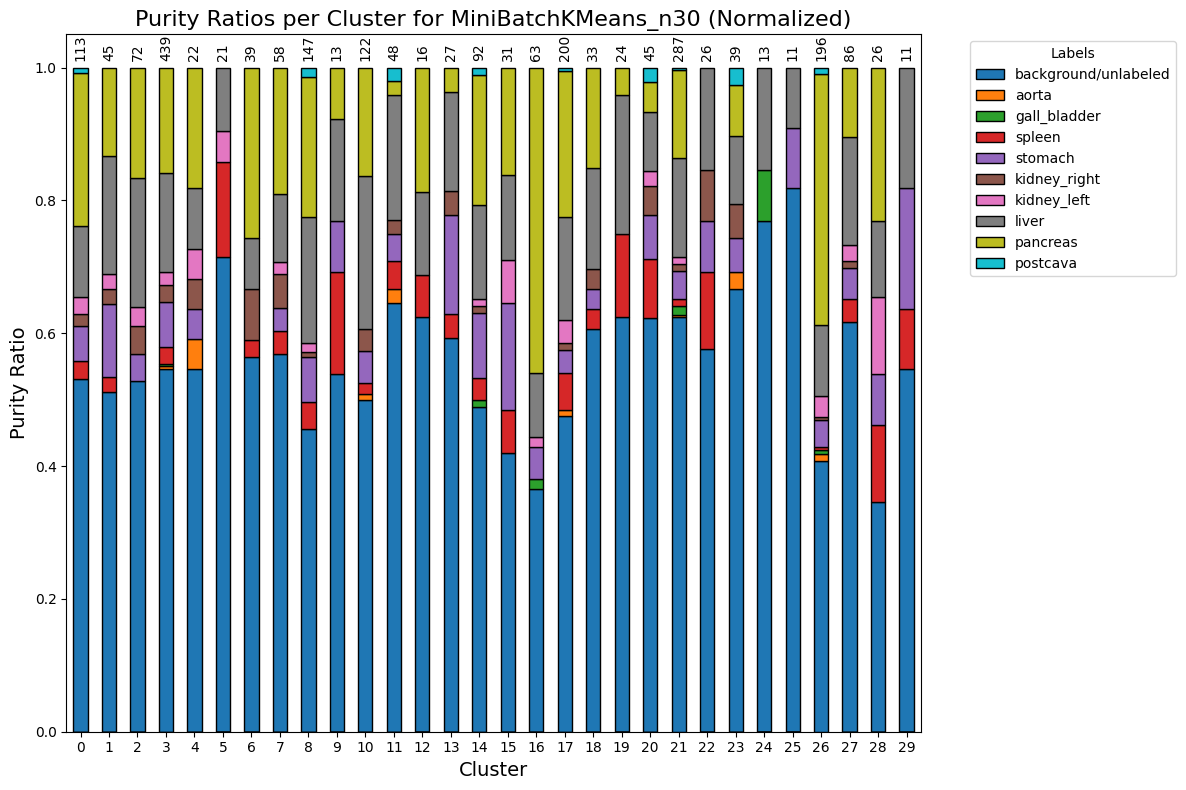

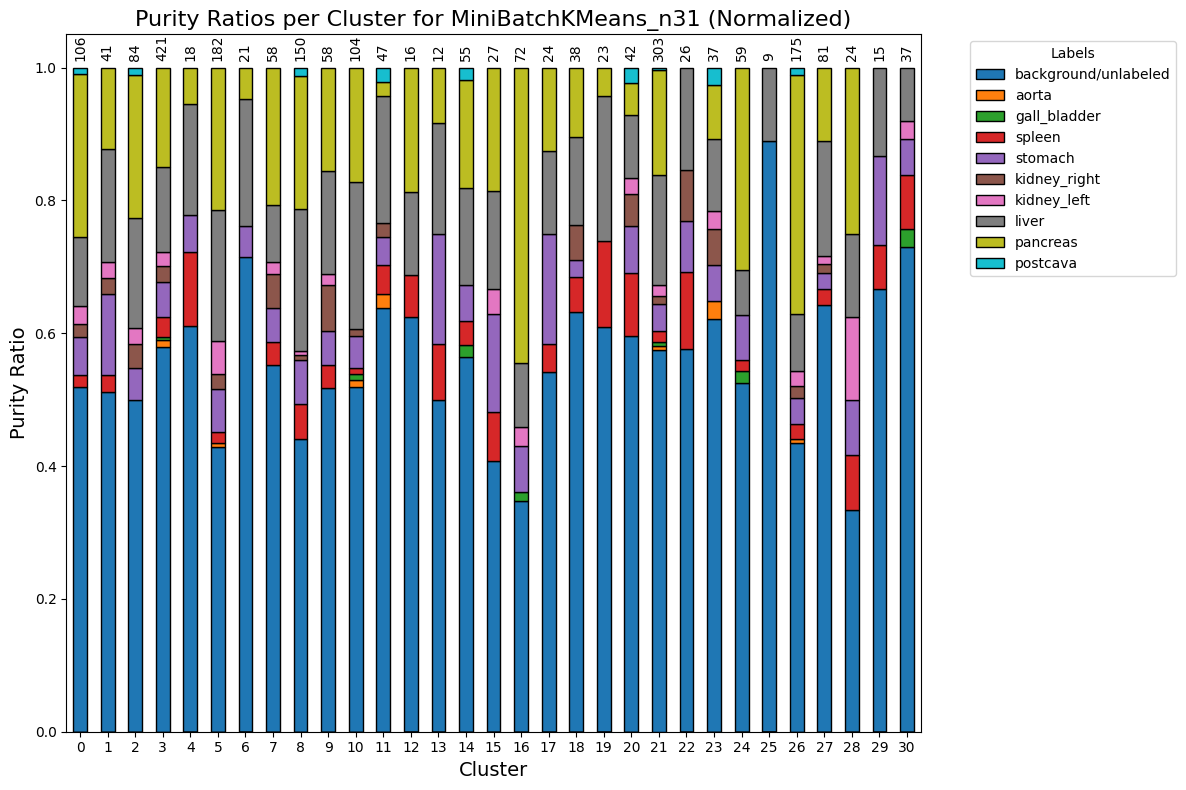

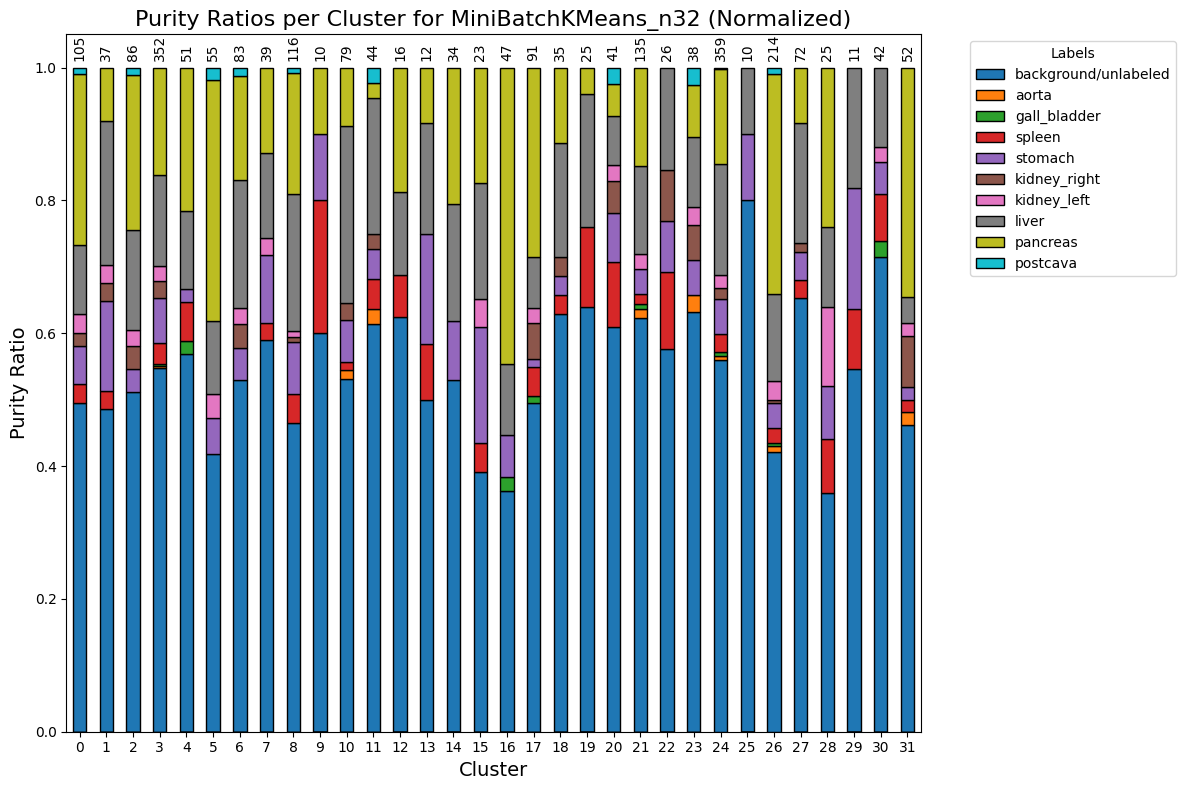

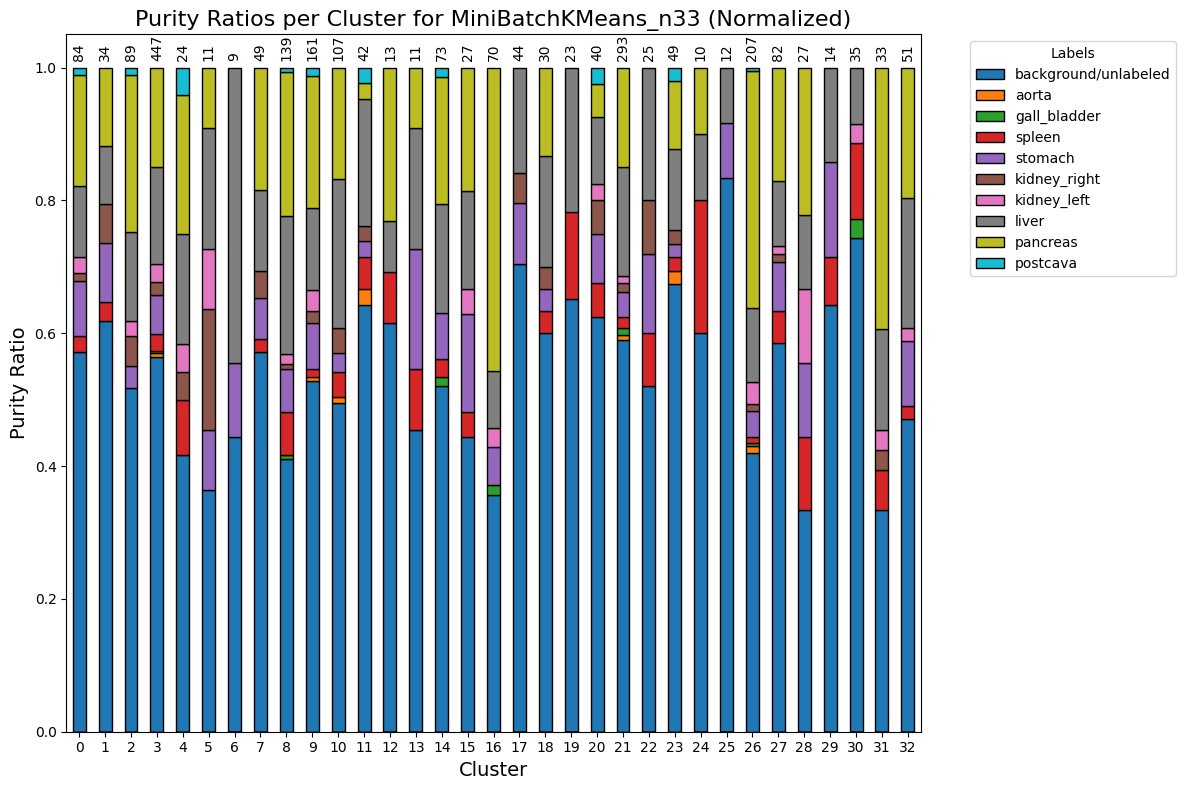

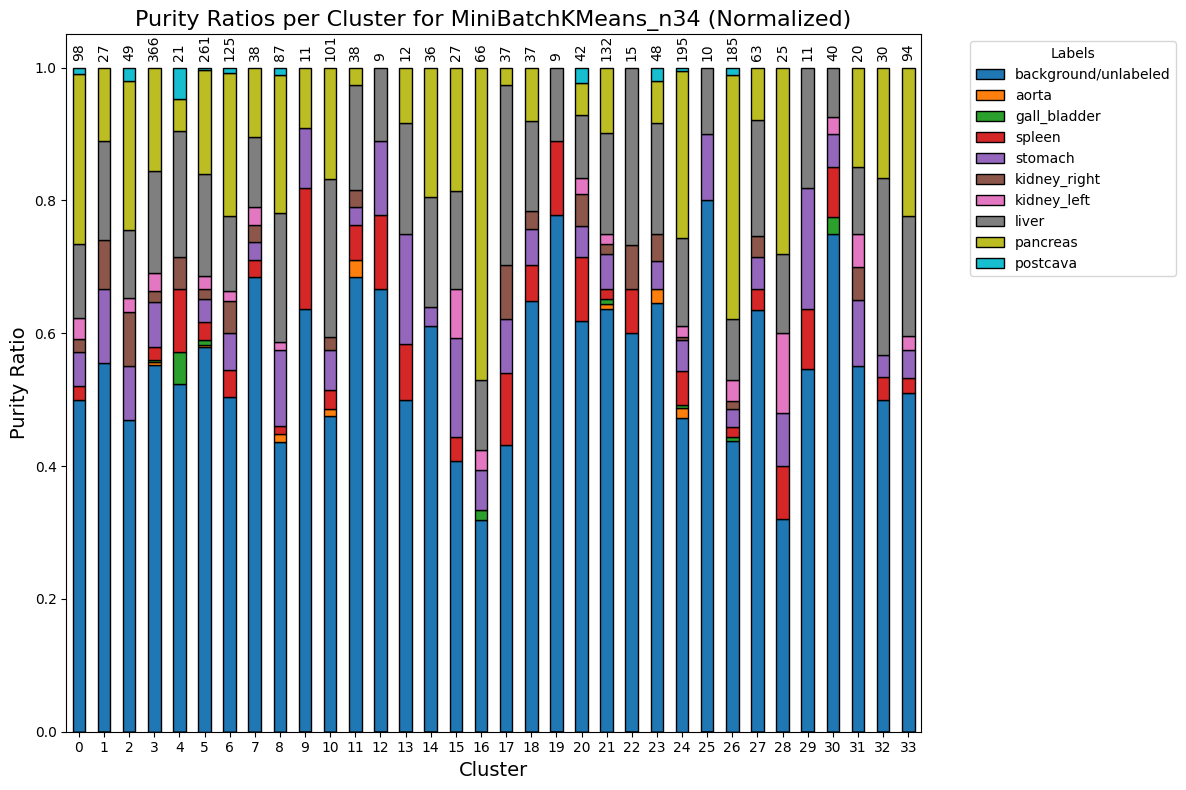

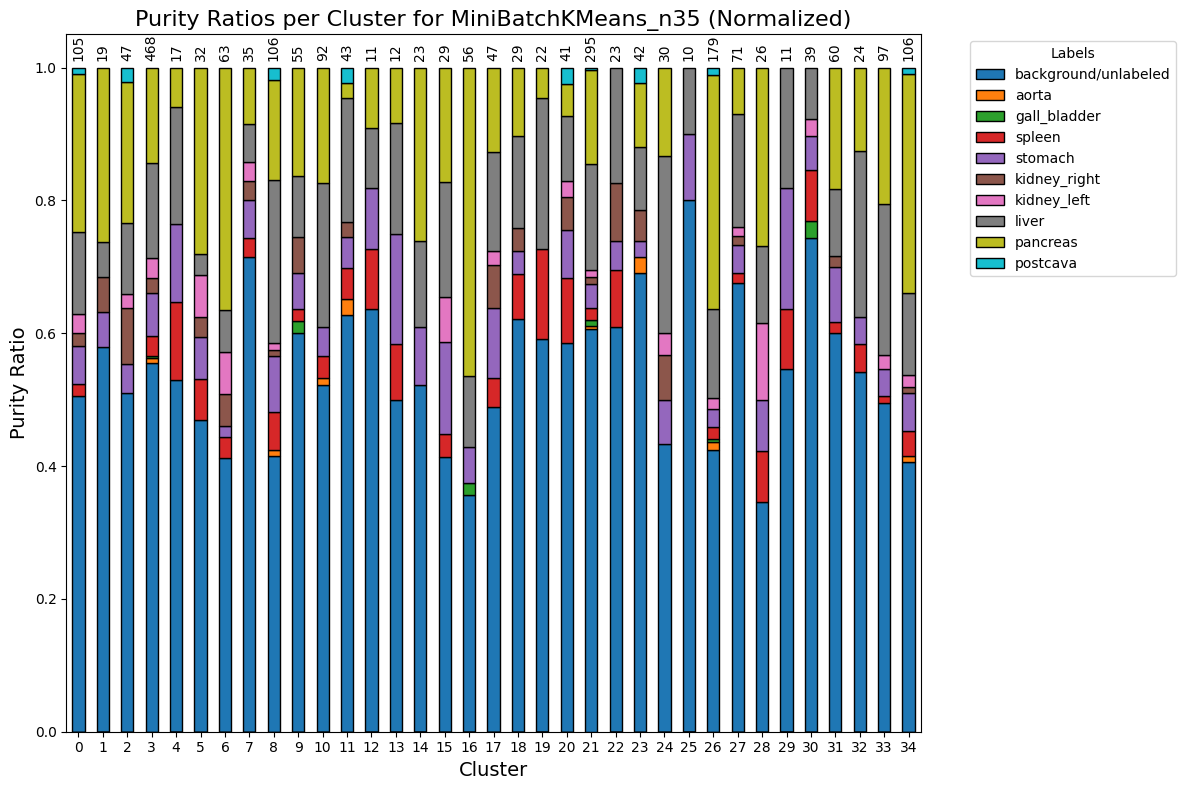

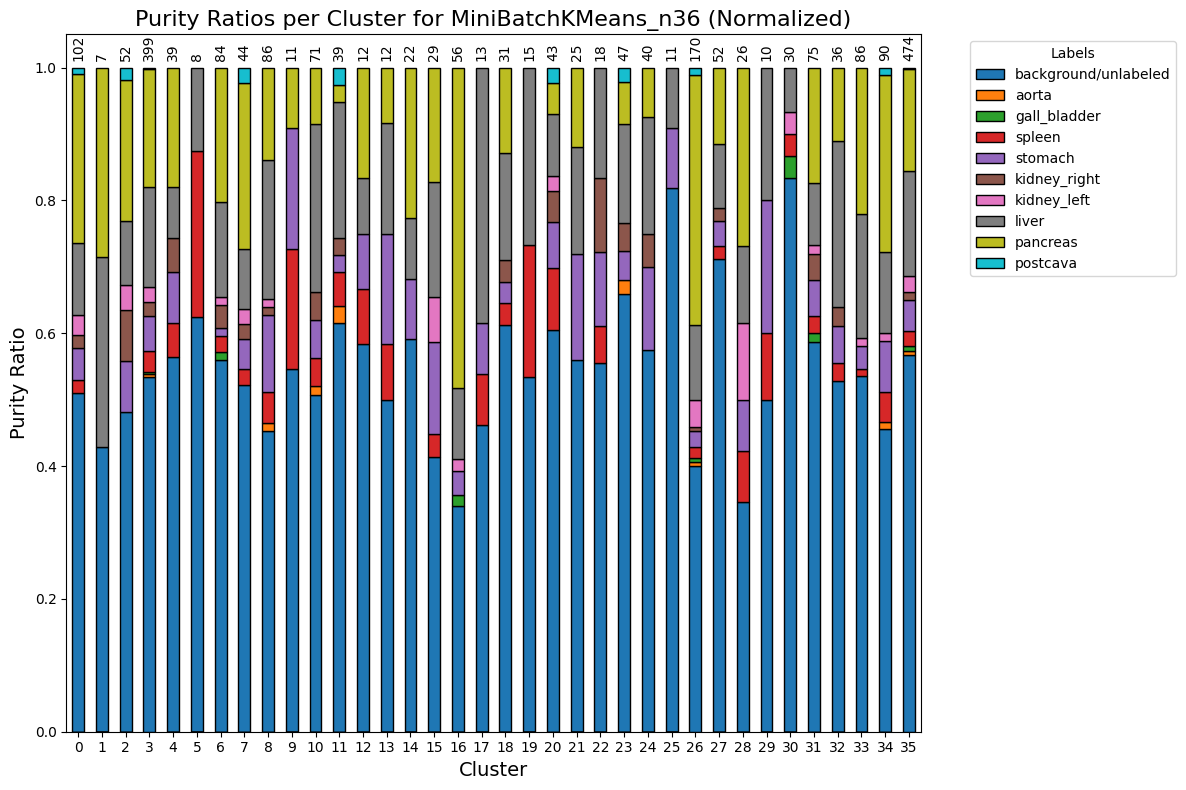

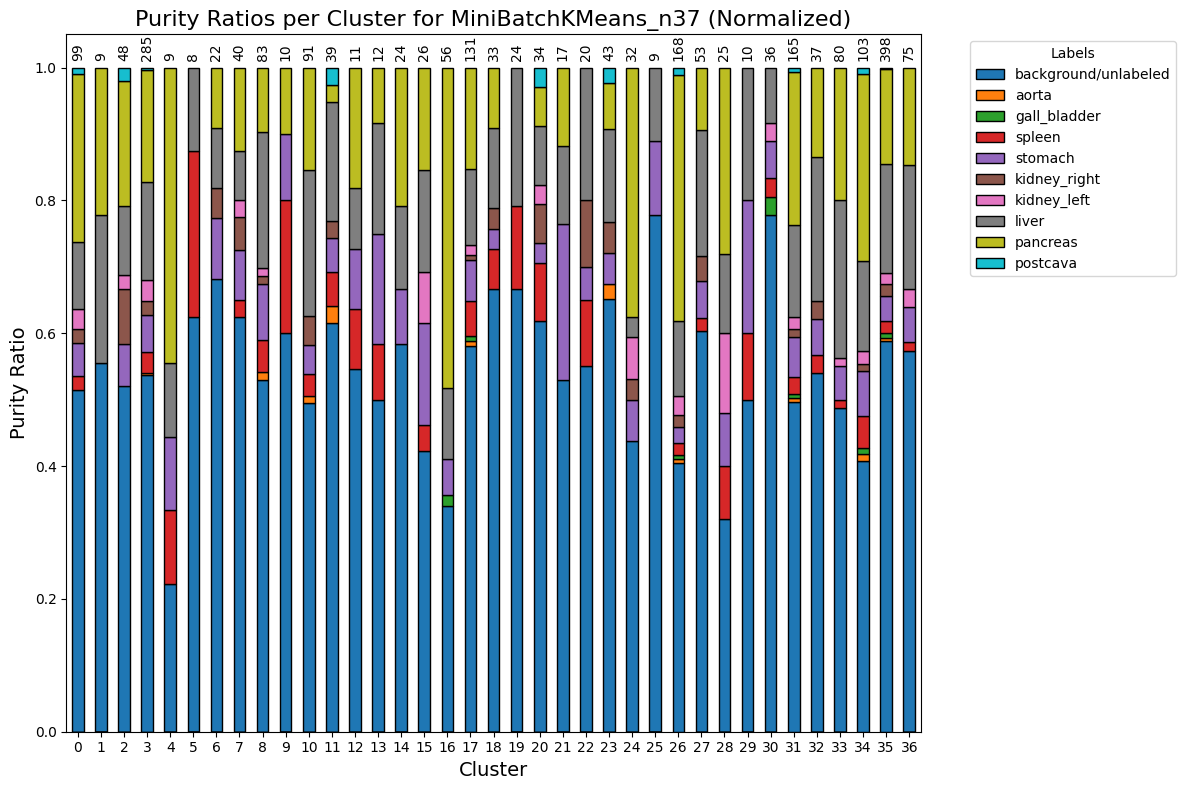

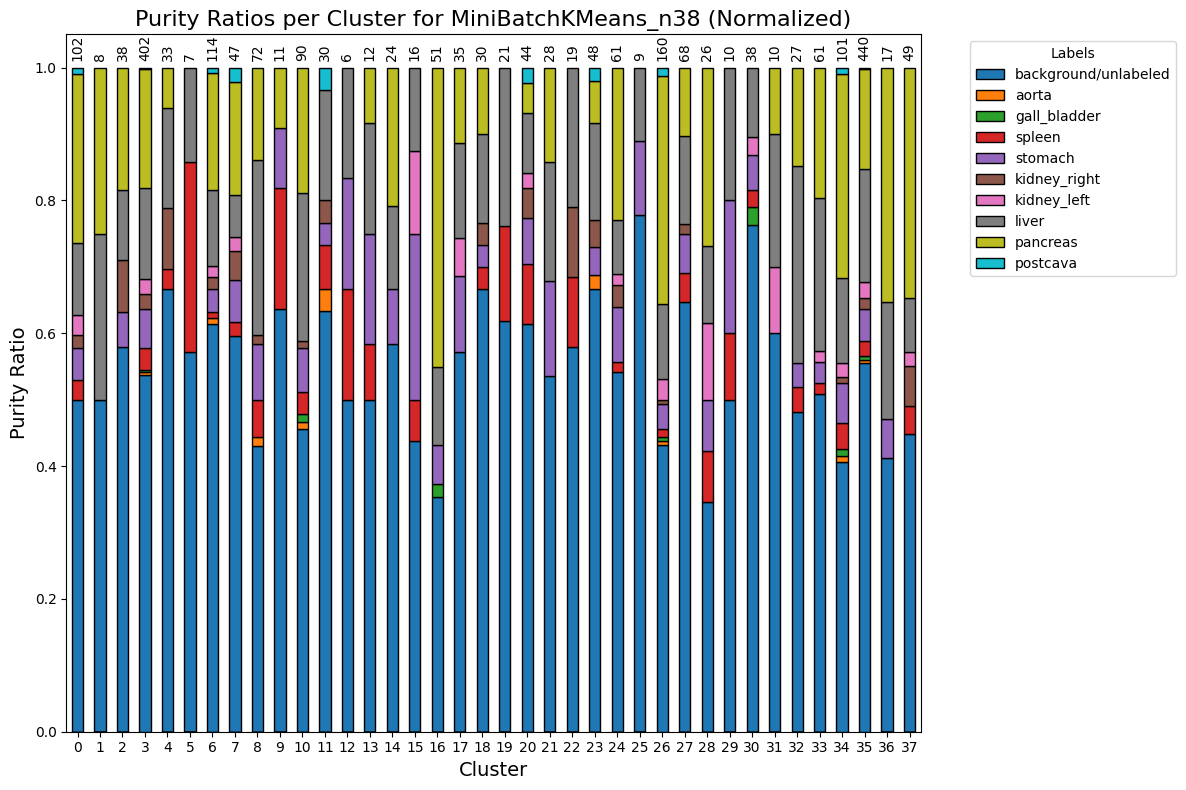

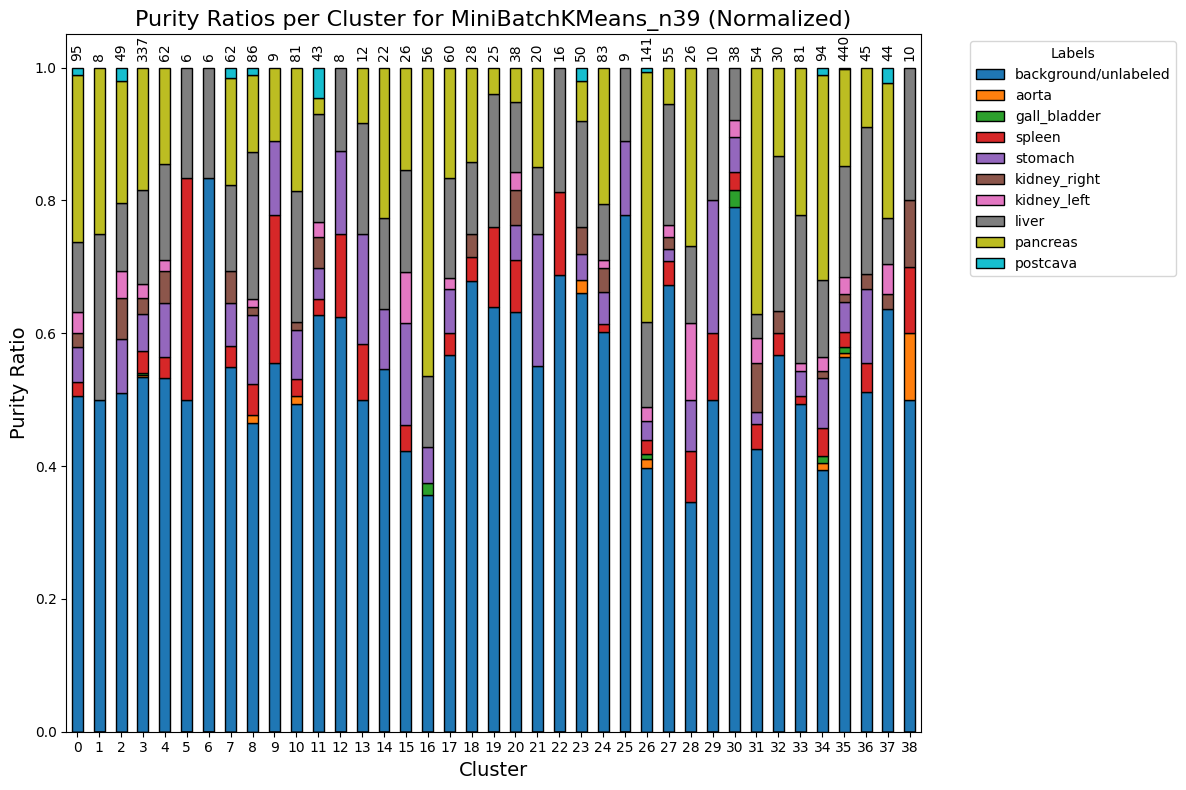

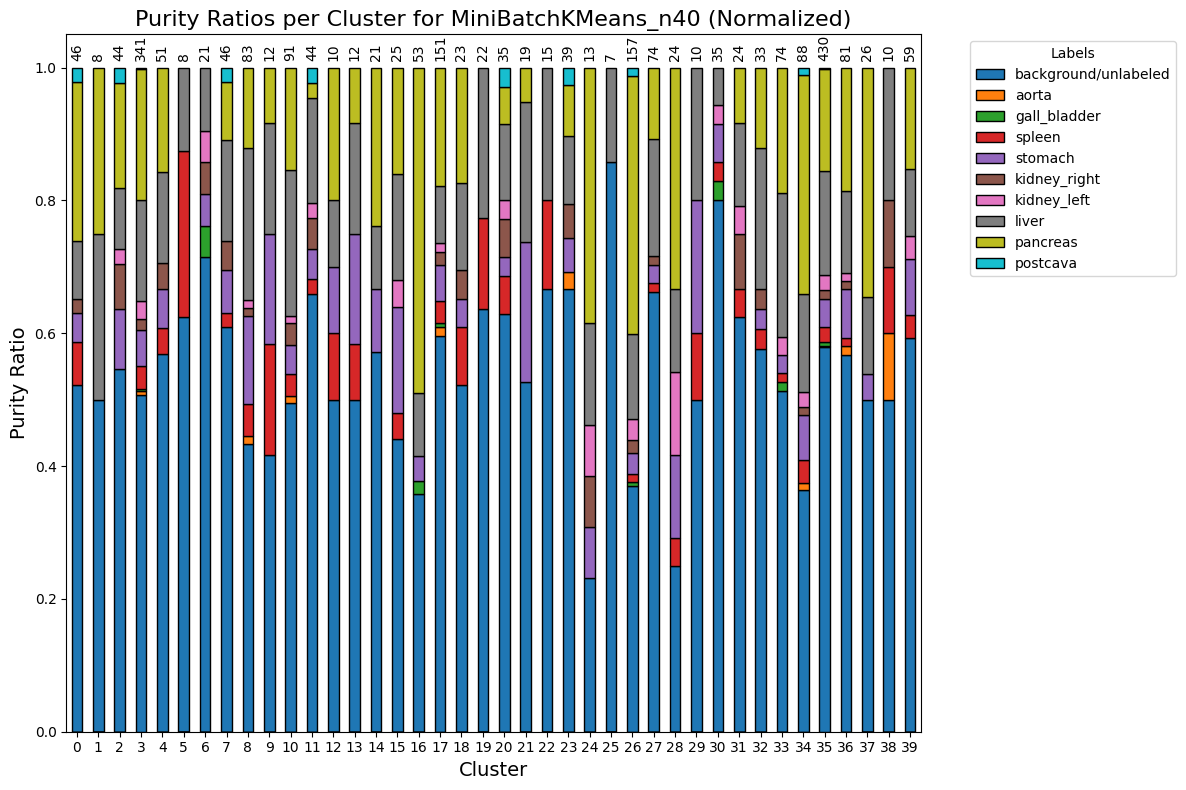

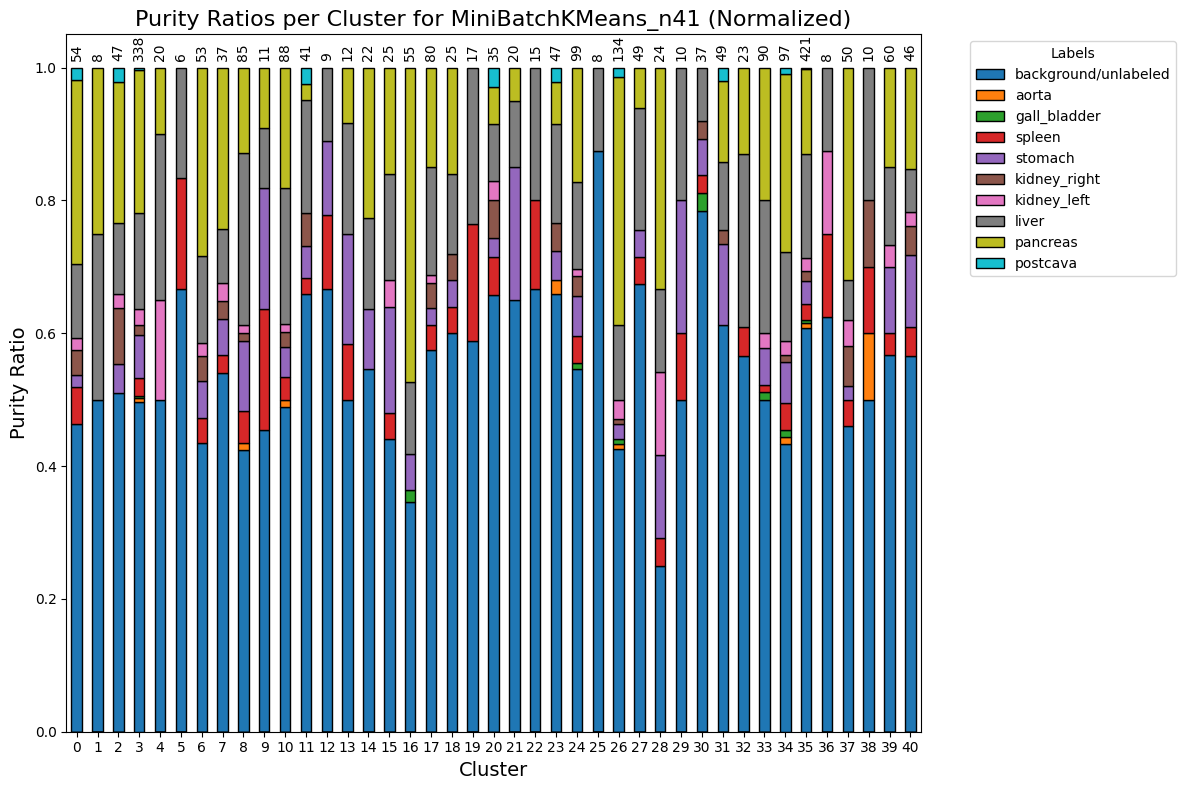

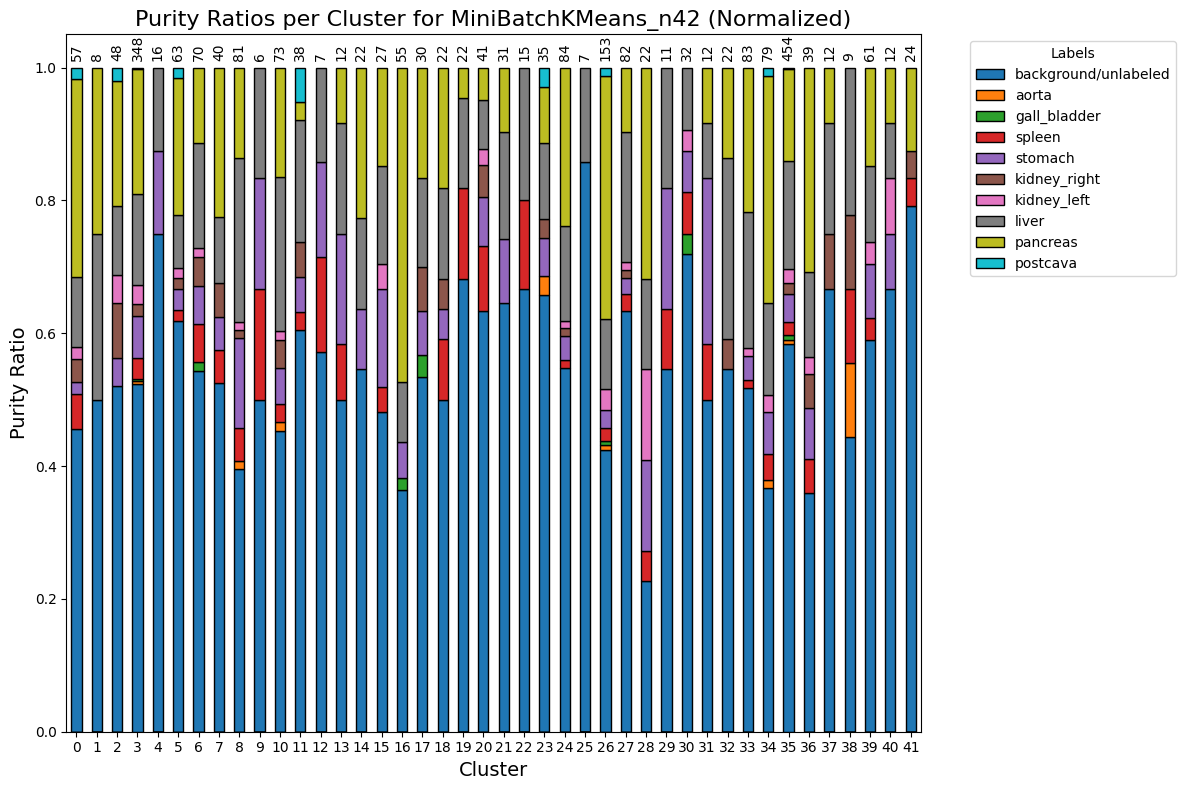

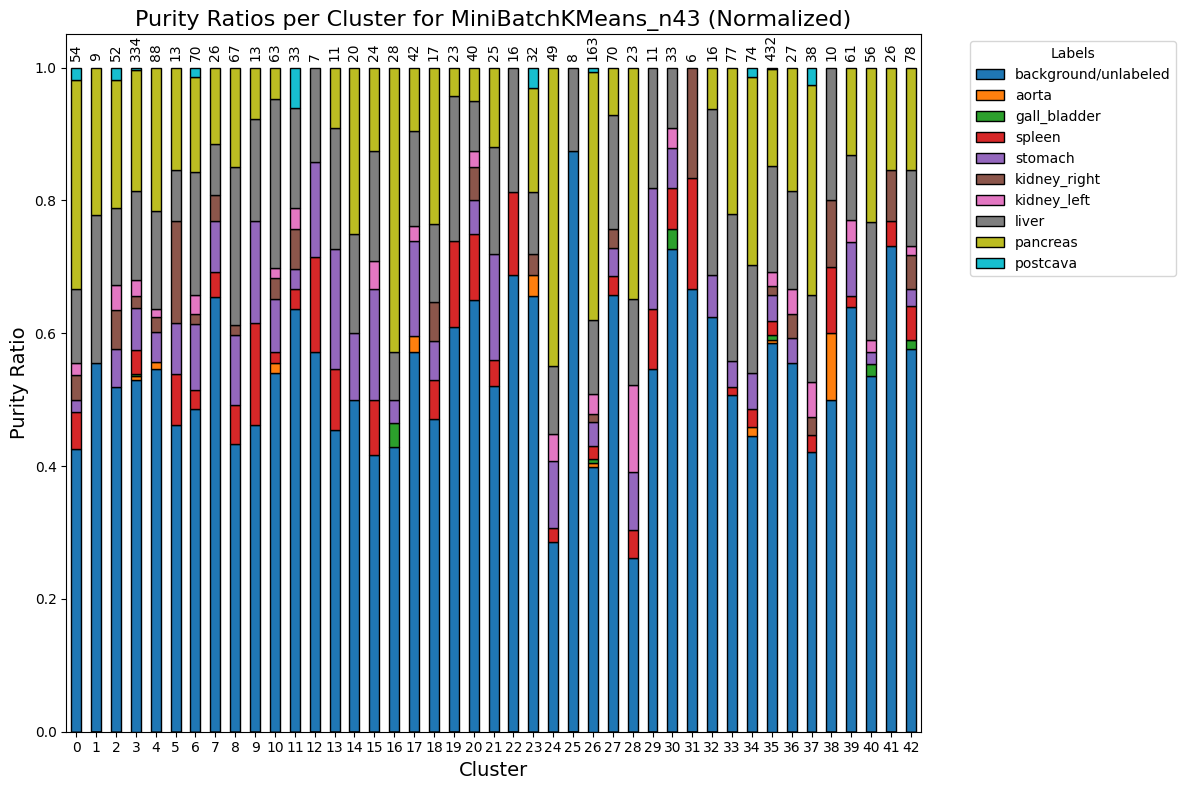

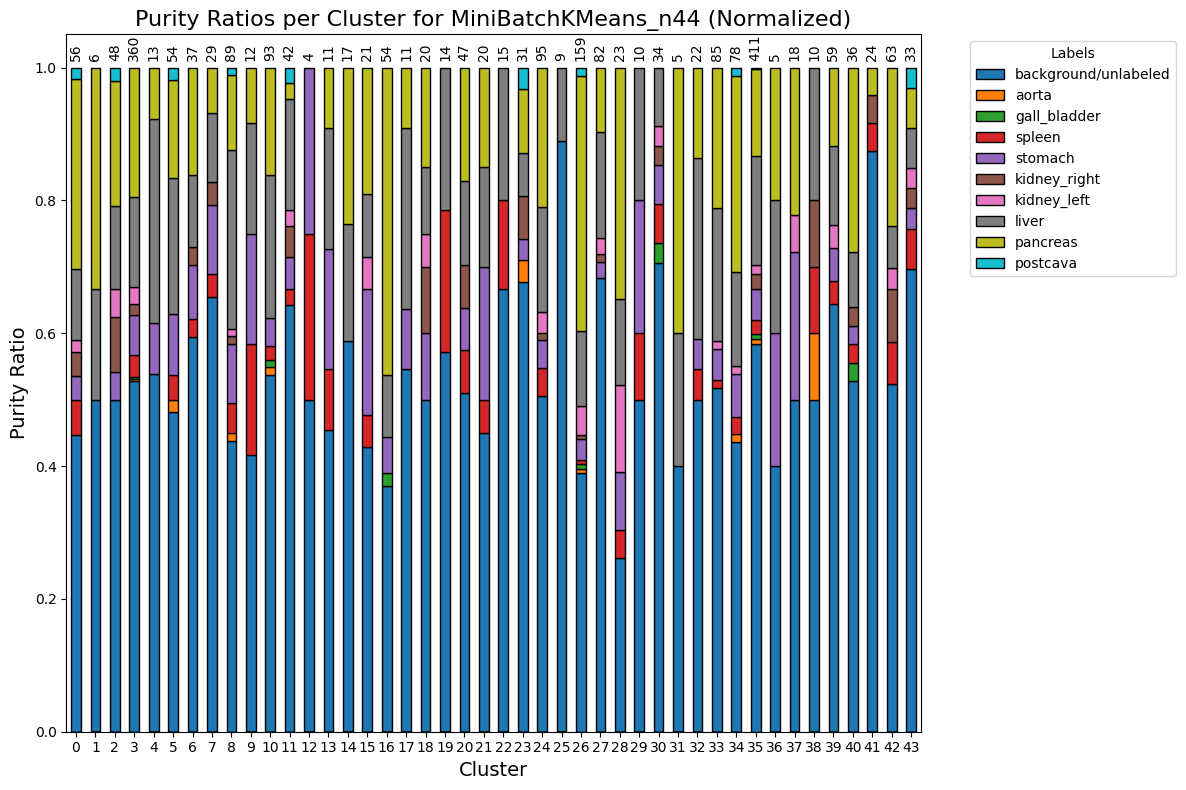

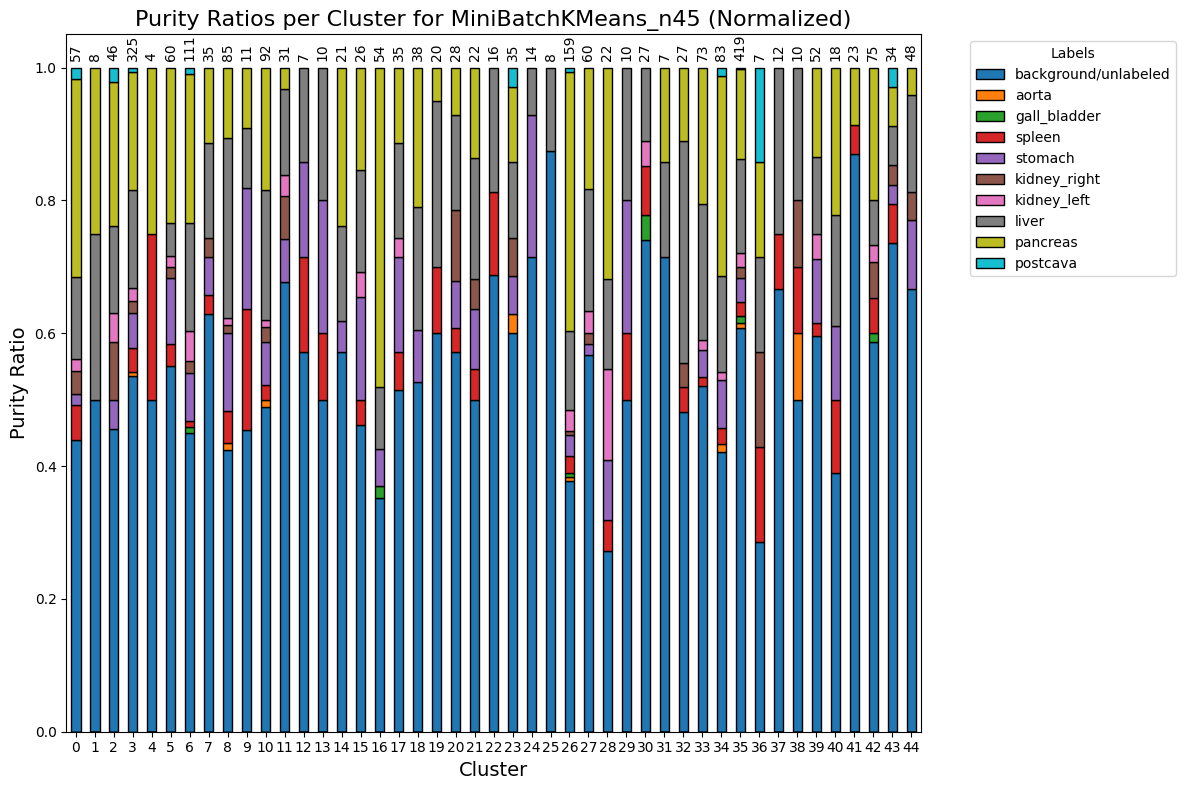

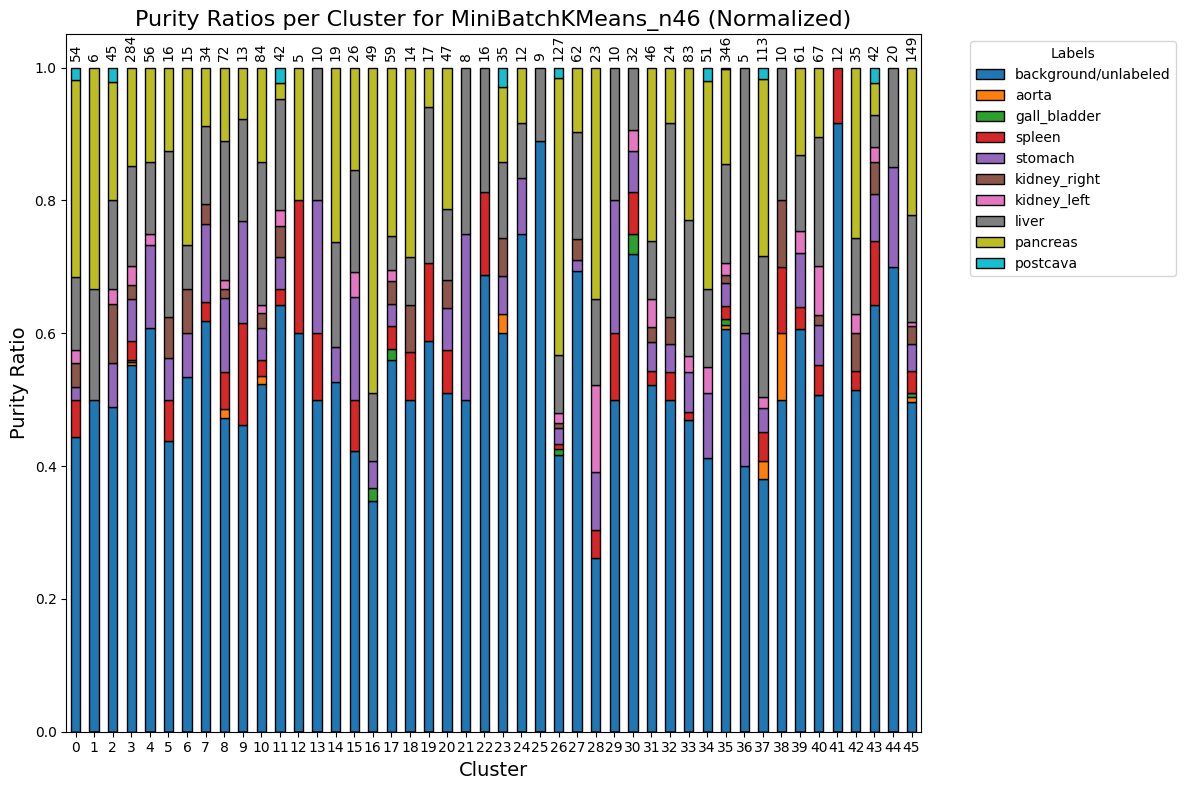

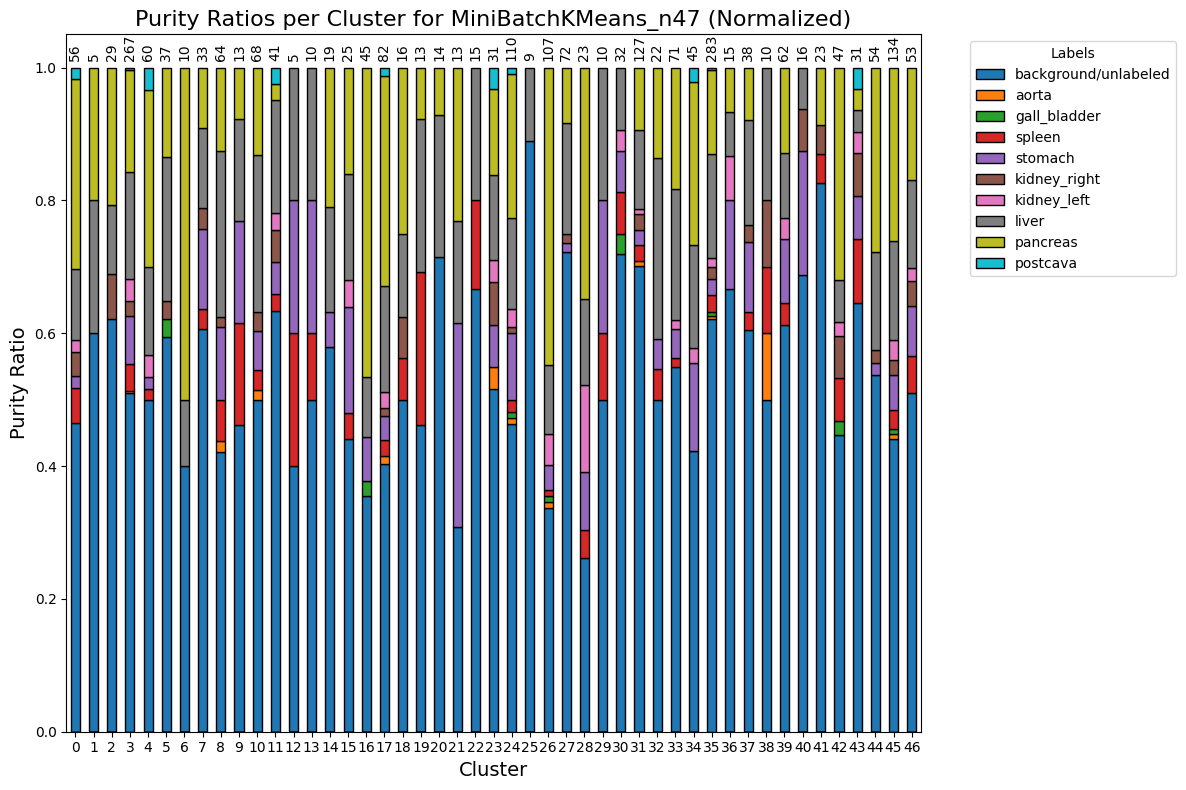

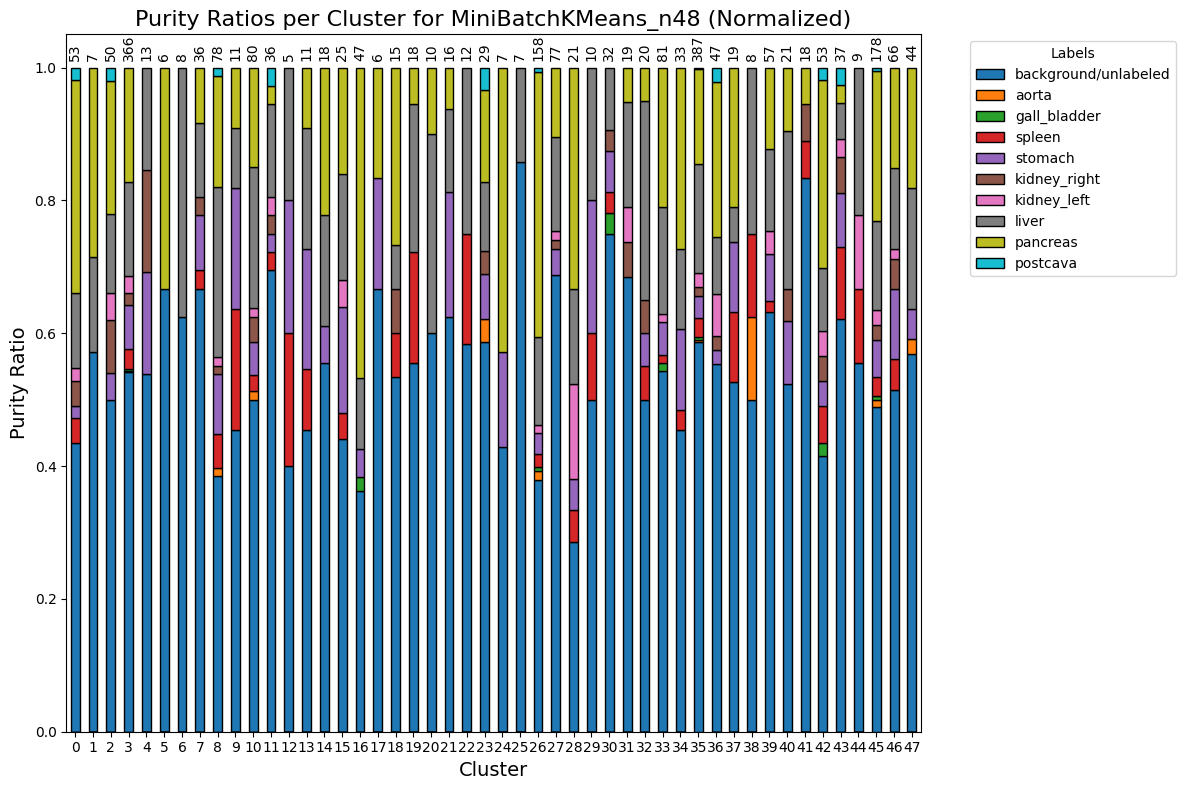

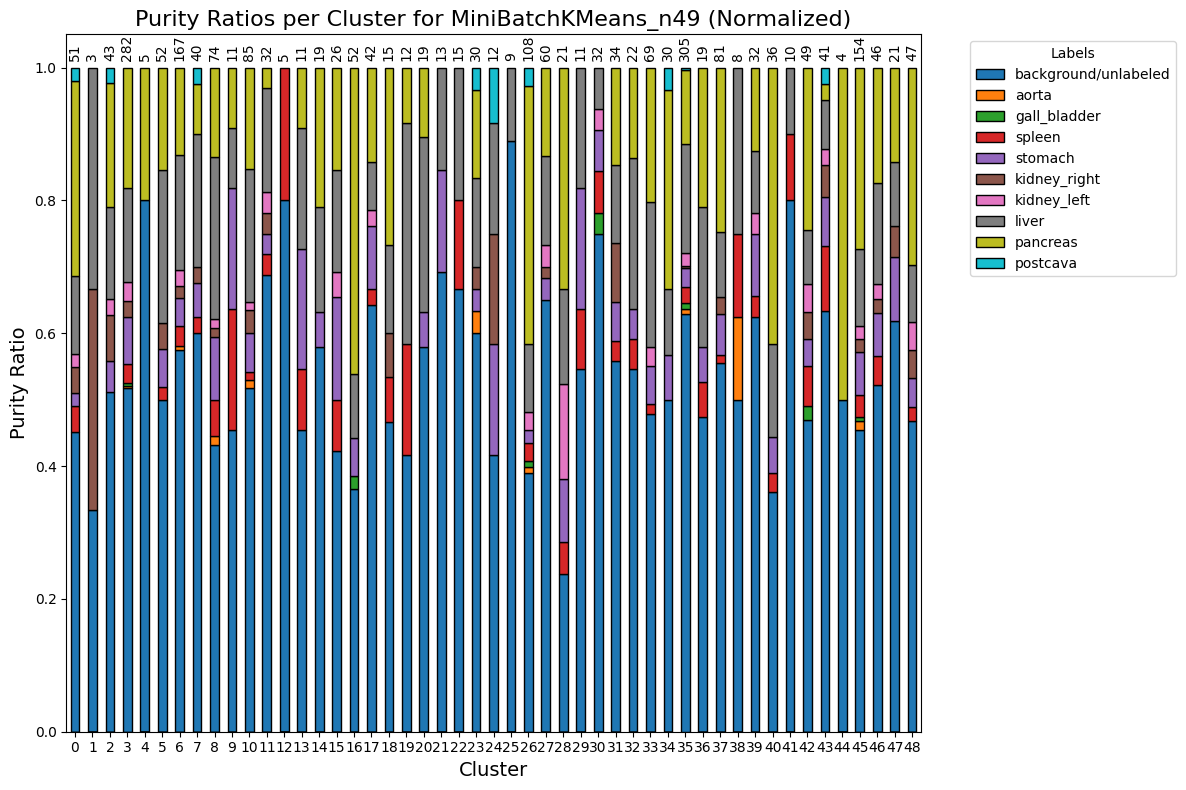

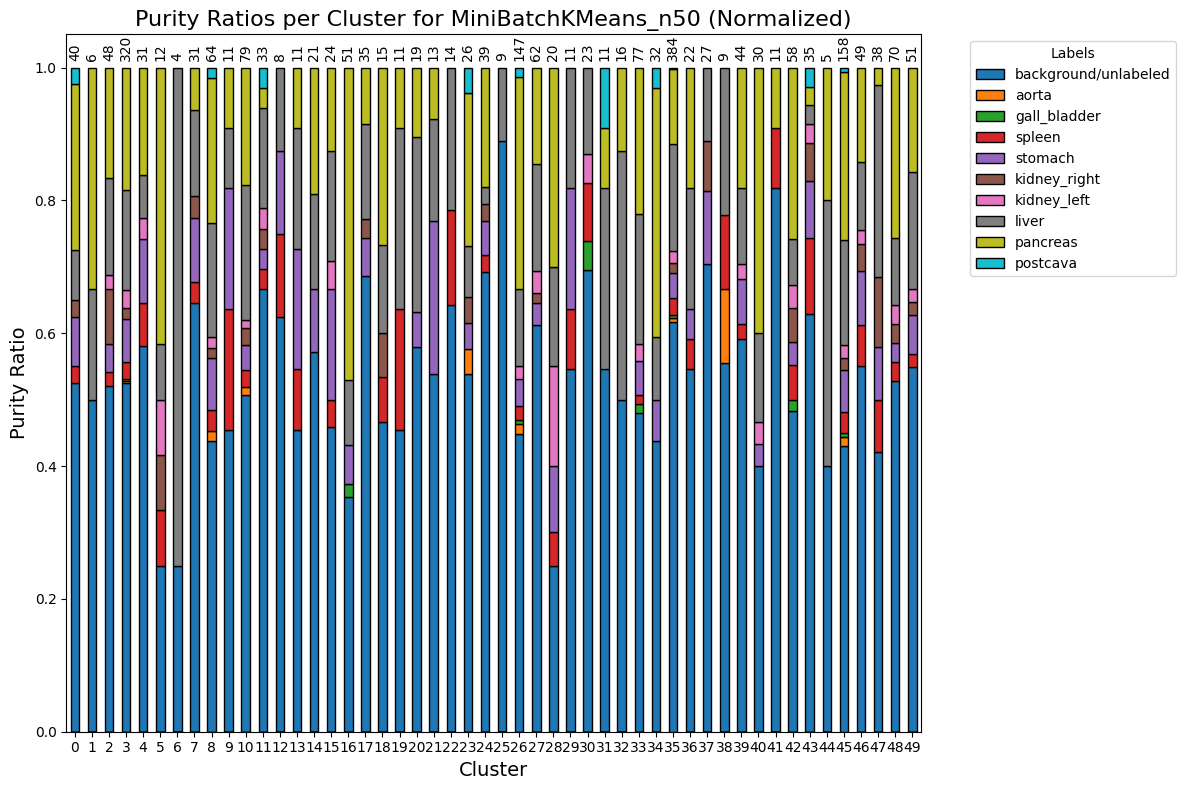

In [43]:
cluster_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=range(2,51,1))

## 6-away Stencil

Sampled Cubes Random State 2 results not interesting - omitted to keep notebook size reasonable. Rerun as neccesaary.

In [55]:
flat_enc_cts = flatten_features(all_encoded_cubes)
stencil_vecs_6, _ = extract_stencil_vectors(flat_enc_cts, n_samples=all_encoded_cubes.shape[0], distance=8)#.unsqueeze(0))#(0))[0]

In [56]:
stencil_vecs_6.shape

torch.Size([2365, 56])

In [ ]:
labels = sampled_points_multi_organ_labels.flatten().numpy()

In [ ]:
cluster_results, algorithms = cluster_and_plot_purities(stencil_vecs_6.numpy(), labels, cluster_range=range(2,51,1))

## 8-away Stencil vectors + Center

Same as before, but the 6 vectors added are now 8-distance away from the center

Sampled Cubes Random State 2 results not interesting - omitted to keep notebook size reasonable. Rerun as neccesaary.

In [29]:
flat_enc_cts = flatten_features(all_encoded_cubes)
stencil_vecs, _ = extract_stencil_vectors(flat_enc_cts, n_samples=all_encoded_cubes.shape[0], distance=8)#.unsqueeze(0))#(0))[0]

In [38]:
stencil_vecs.shape

torch.Size([2365, 56])

In [30]:
data = stencil_vecs.numpy()
labels = sampled_points_multi_organ_labels.flatten().numpy()

In [ ]:
cluster_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=range(2,51,1))

## Full Raw Data, Tissue Density Labels

In [14]:
flat_enc_cts = flatten_features(all_encoded_cubes)

In [15]:
tissue_density_labels = torch.load('data/generated-data/tissue_density_labels.pt')

### TODO issue with tissue_density_labels - it was not encoded so now it's too big. Fix this later

In [16]:
tissue_density_labels.shape

torch.Size([44, 55, 96, 96, 96])

In [17]:
sampled_points_coordinates.shape

torch.Size([44, 55, 3])

In [18]:
data = flat_enc_cts.numpy()
labels = tissue_density_labels.flatten().numpy()

In [19]:
minibatchkmeans_10.fit(data)

/home/alubonj1/scr4_randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=10, random_state=42)

In [21]:
data.shape

(33454080, 8)

In [22]:
labels.shape

(2141061120,)

In [20]:
cluster_and_plot_purities(data, labels)

Clustering Algorithms:   0%|          | 0/49 [00:03<?, ?alg/s]


ValueError: Length of values (2141061120) does not match length of index (33454080)

## Middle Vectors of $24^3$, Multi-Organ Labels Purities

Raw data, no scaling, no PCA. Just Flattened

In [182]:
flat_enc_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_enc_cts)#.unsqueeze(0))#(0))[0]

In [183]:
raw_cubes_middle_vecs.shape

torch.Size([2365, 8])

In [184]:
data = raw_cubes_middle_vecs.numpy()

In [185]:
labels = sampled_points_multi_organ_labels.flatten().numpy()

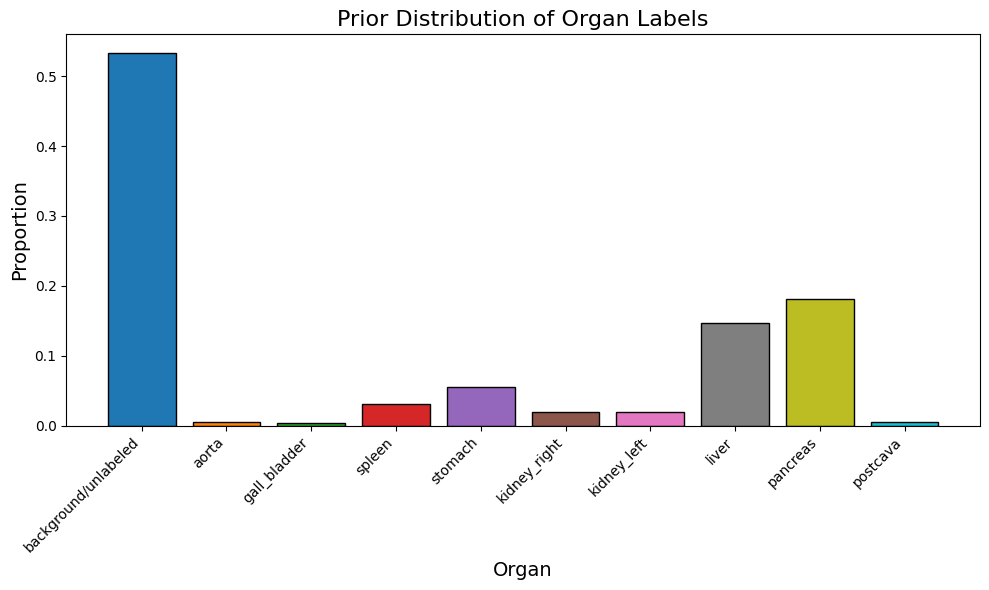

In [186]:
plot_prior_distribution(sampled_points_multi_organ_labels.flatten().numpy())#, label_mapping=reverse_organs_dict)

Clustering Algorithms: 100%|██████████| 25/25 [00:18<00:00,  1.34alg/s]


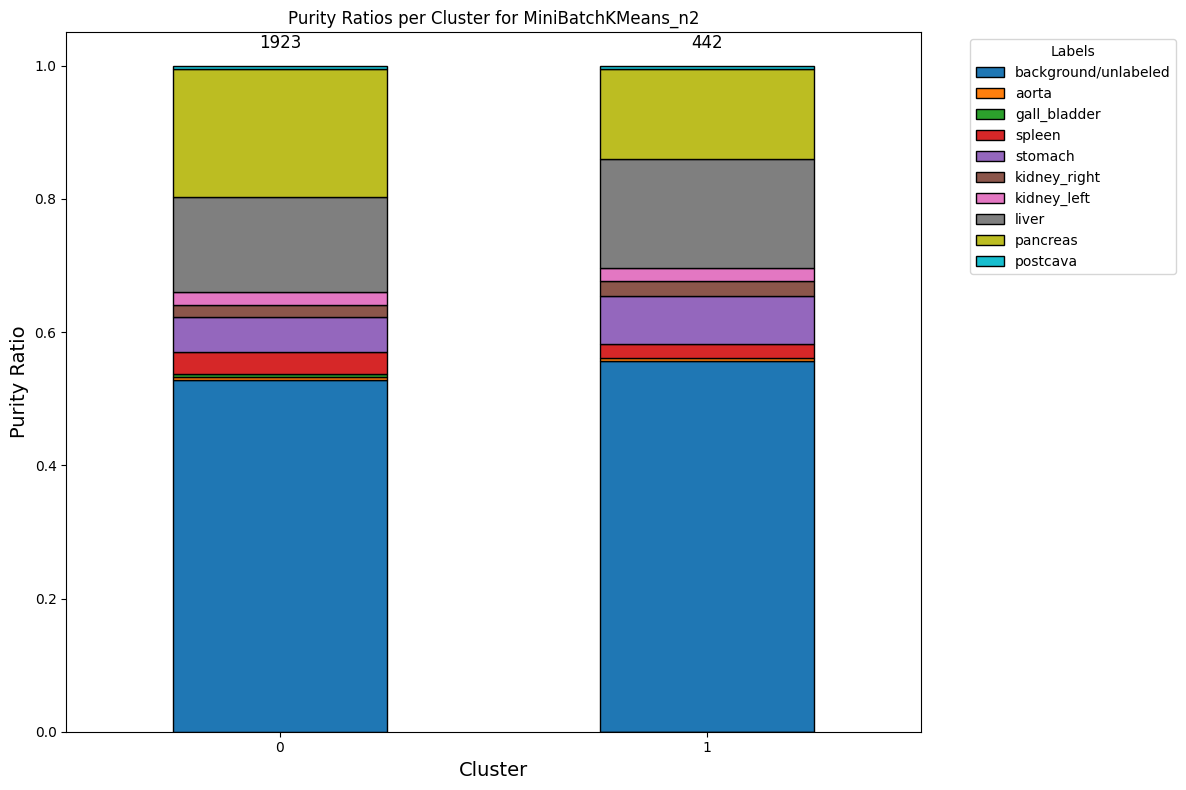

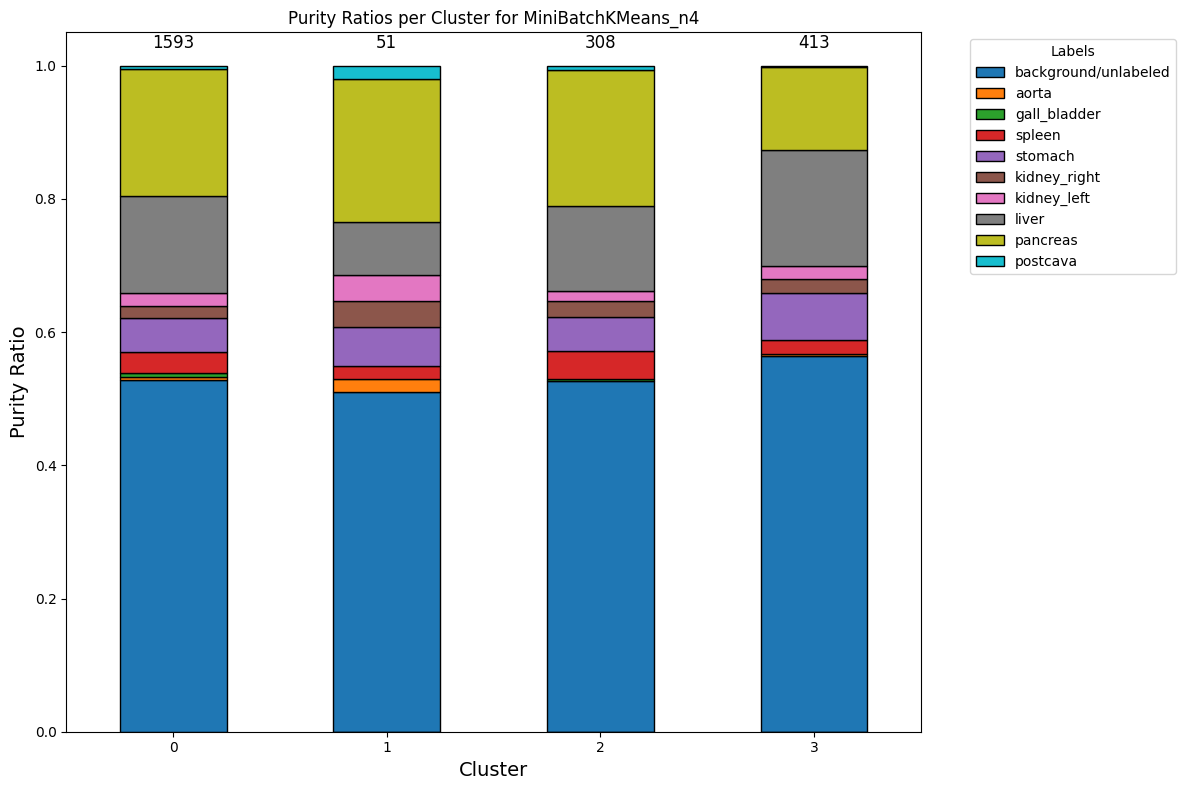

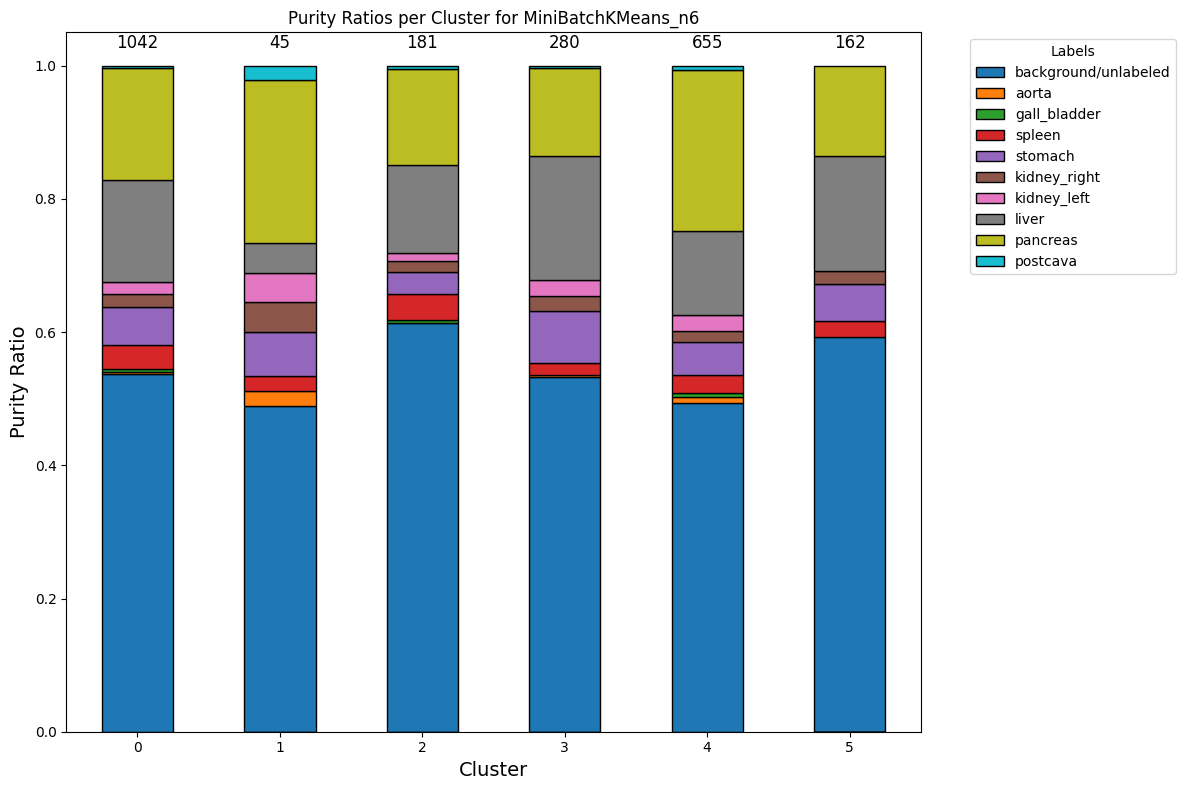

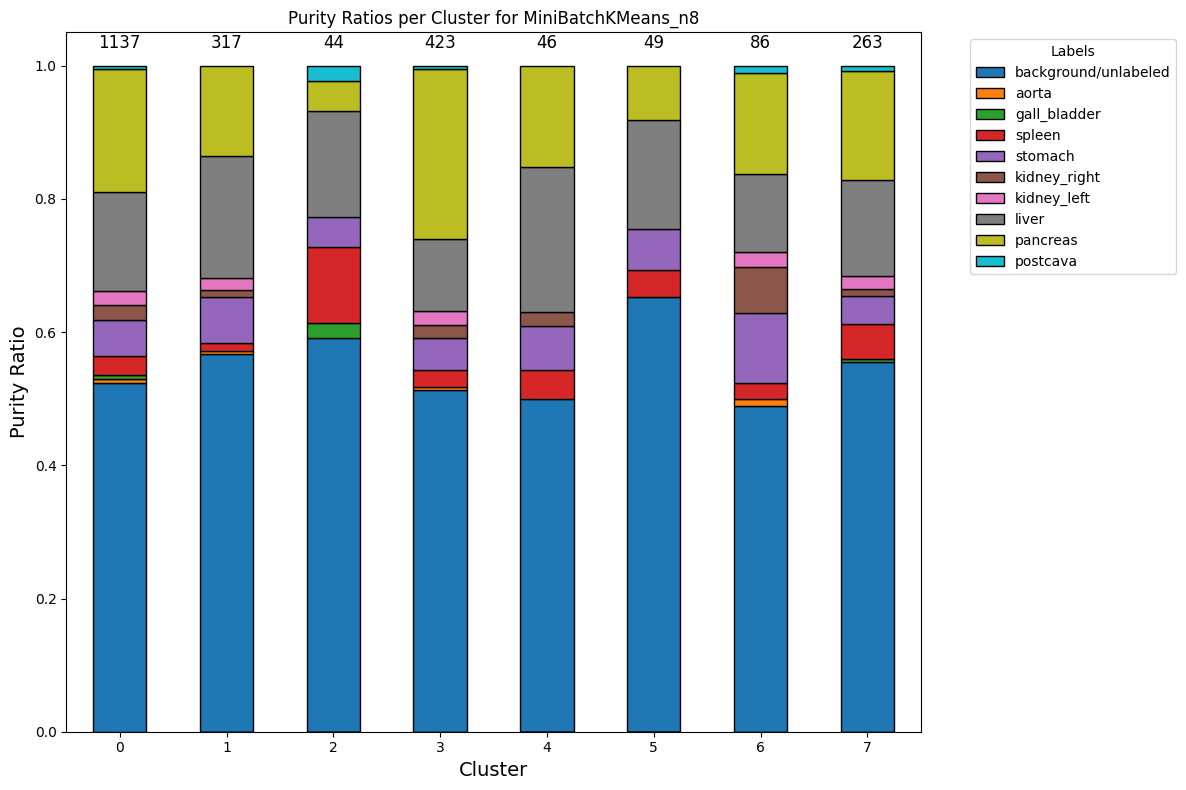

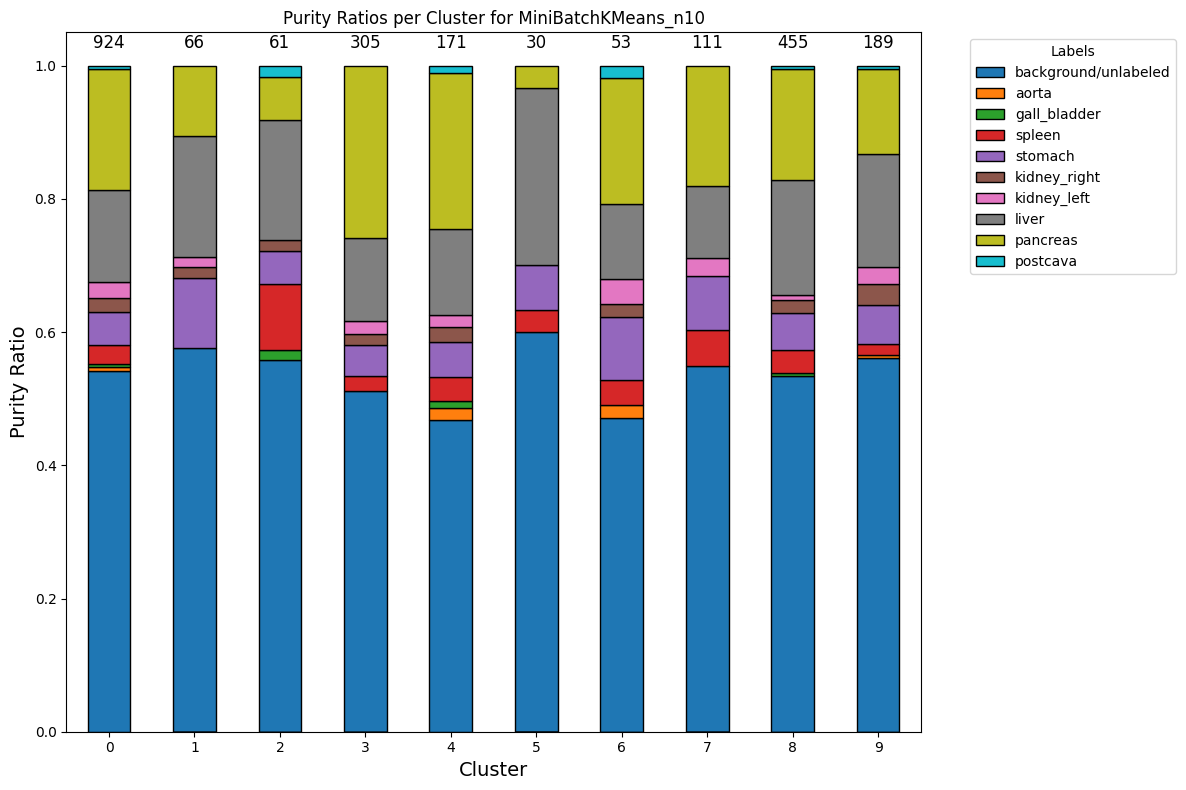

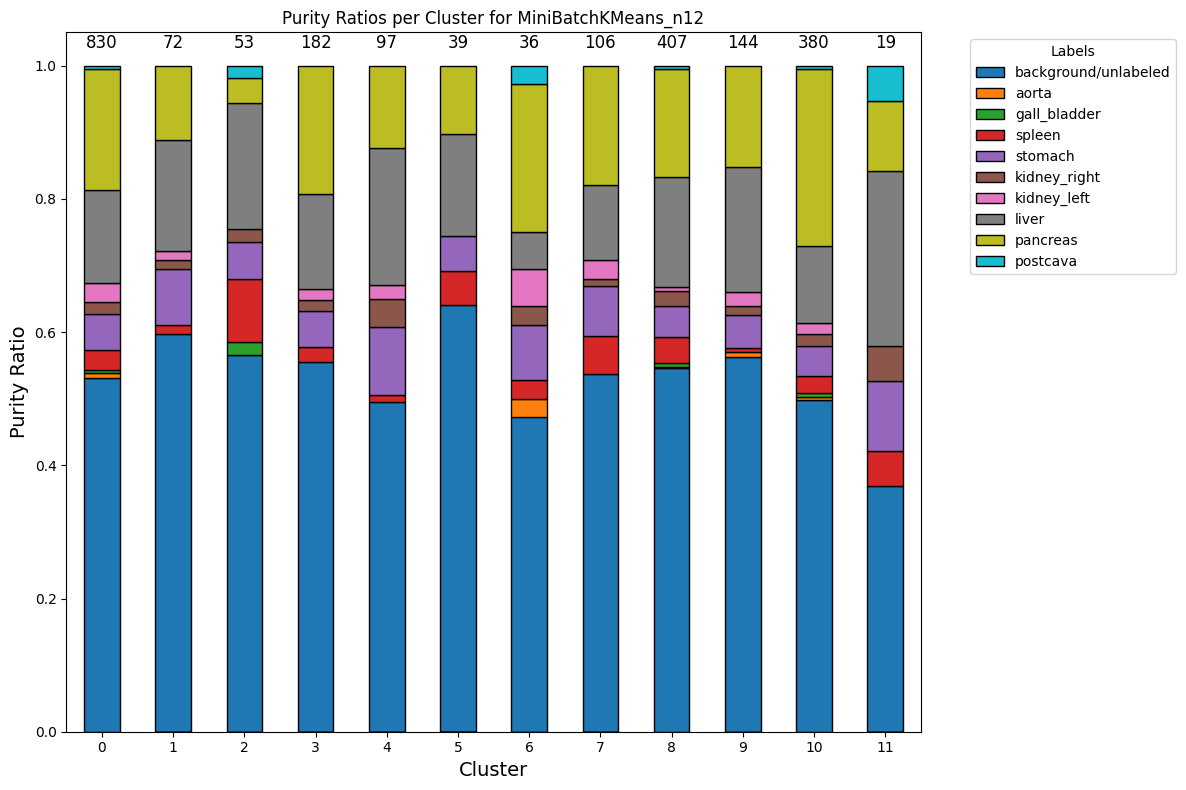

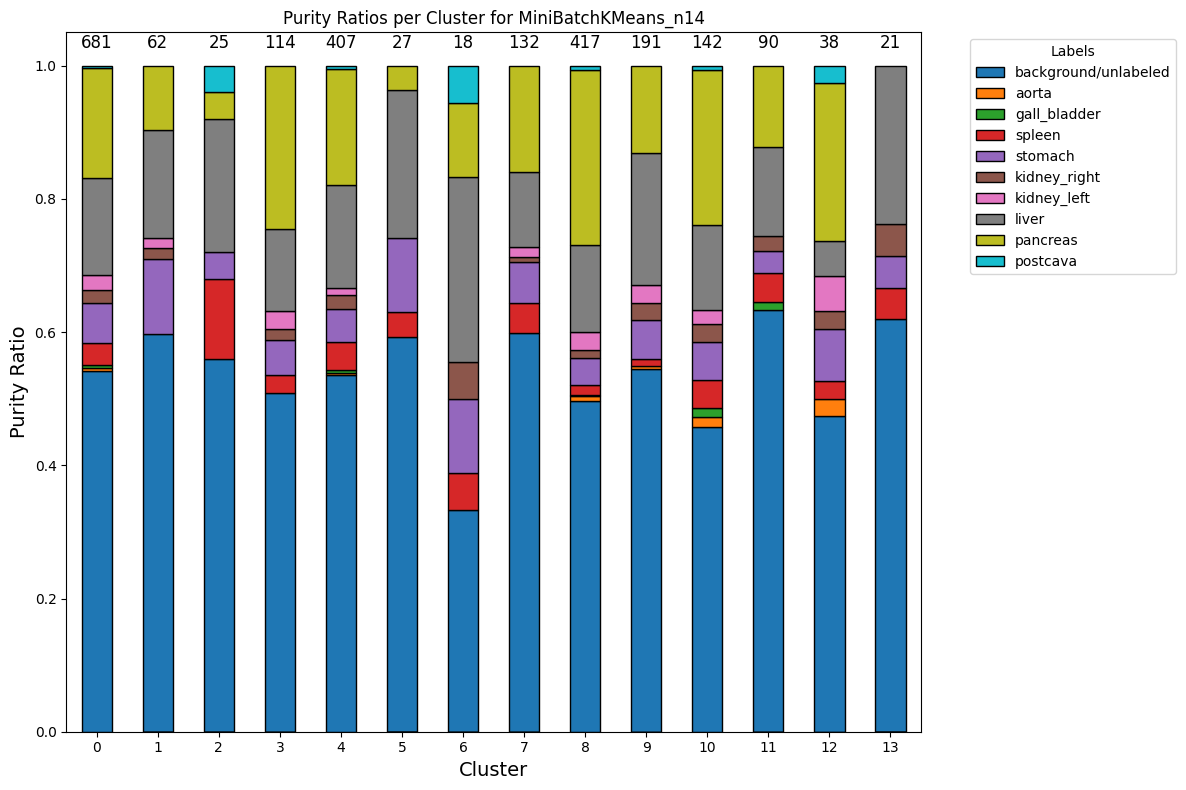

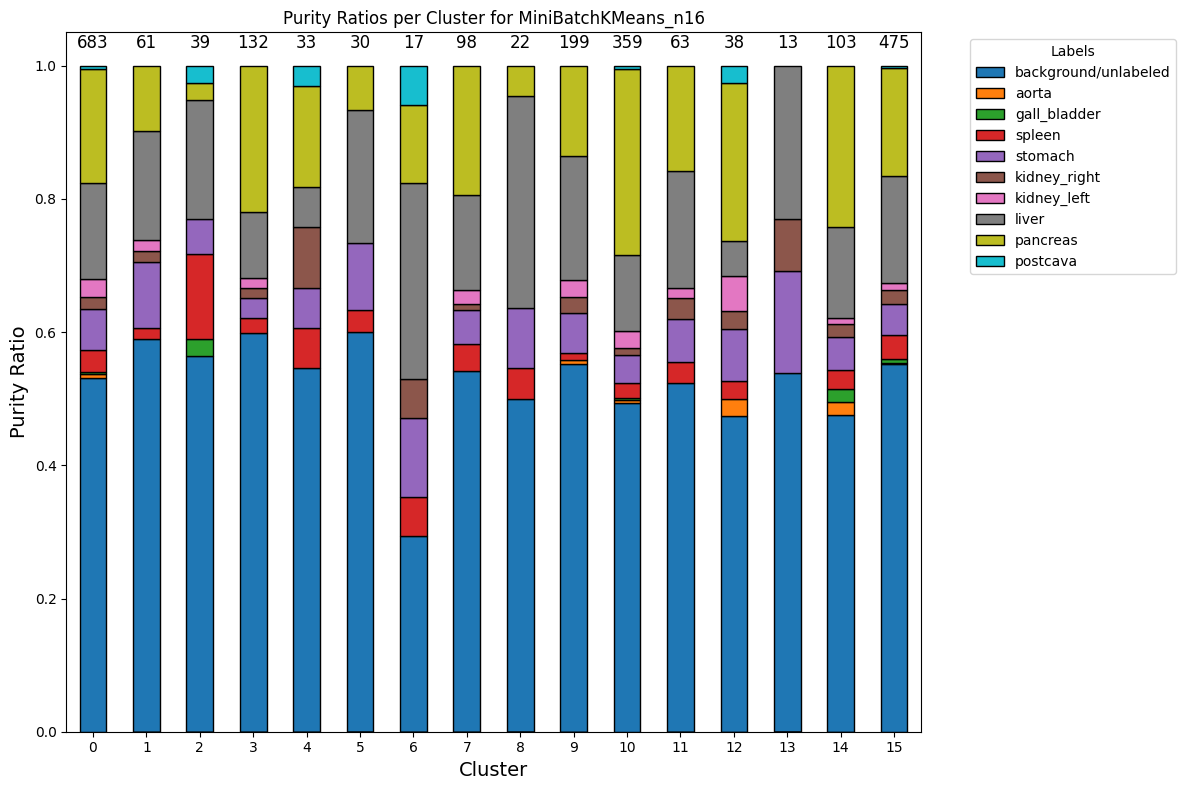

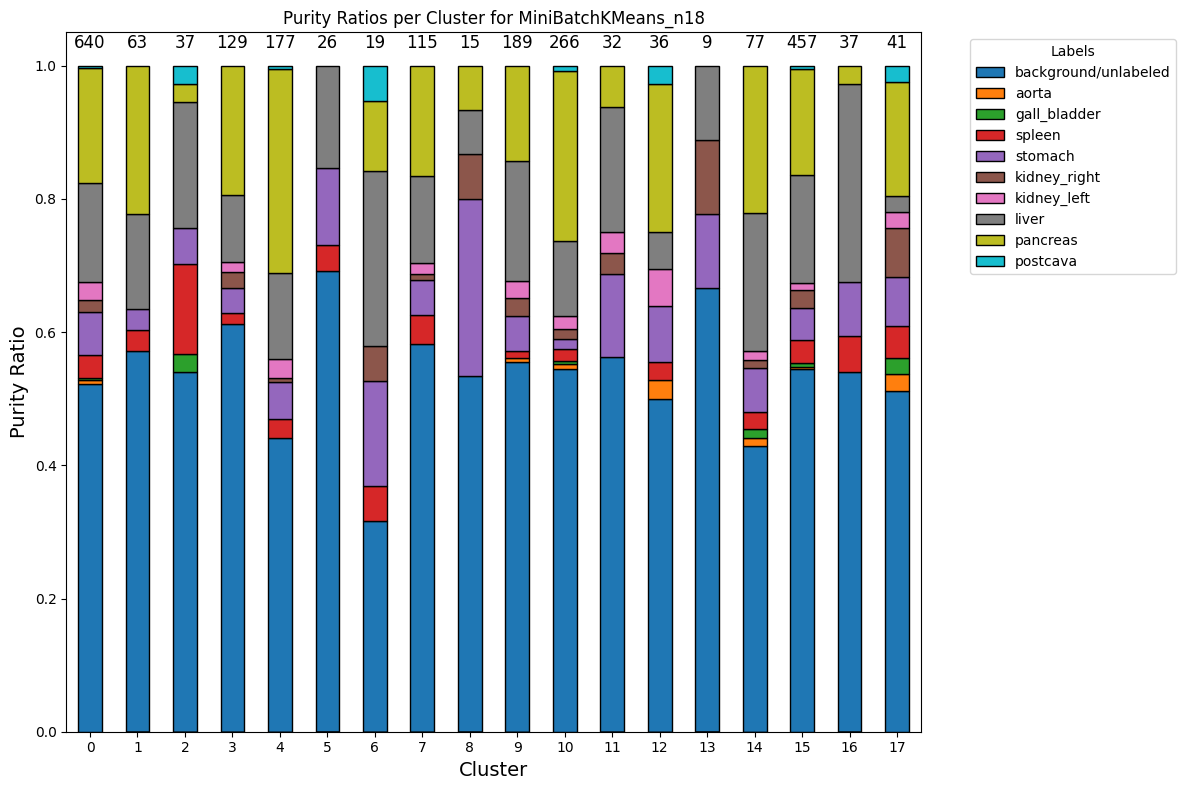

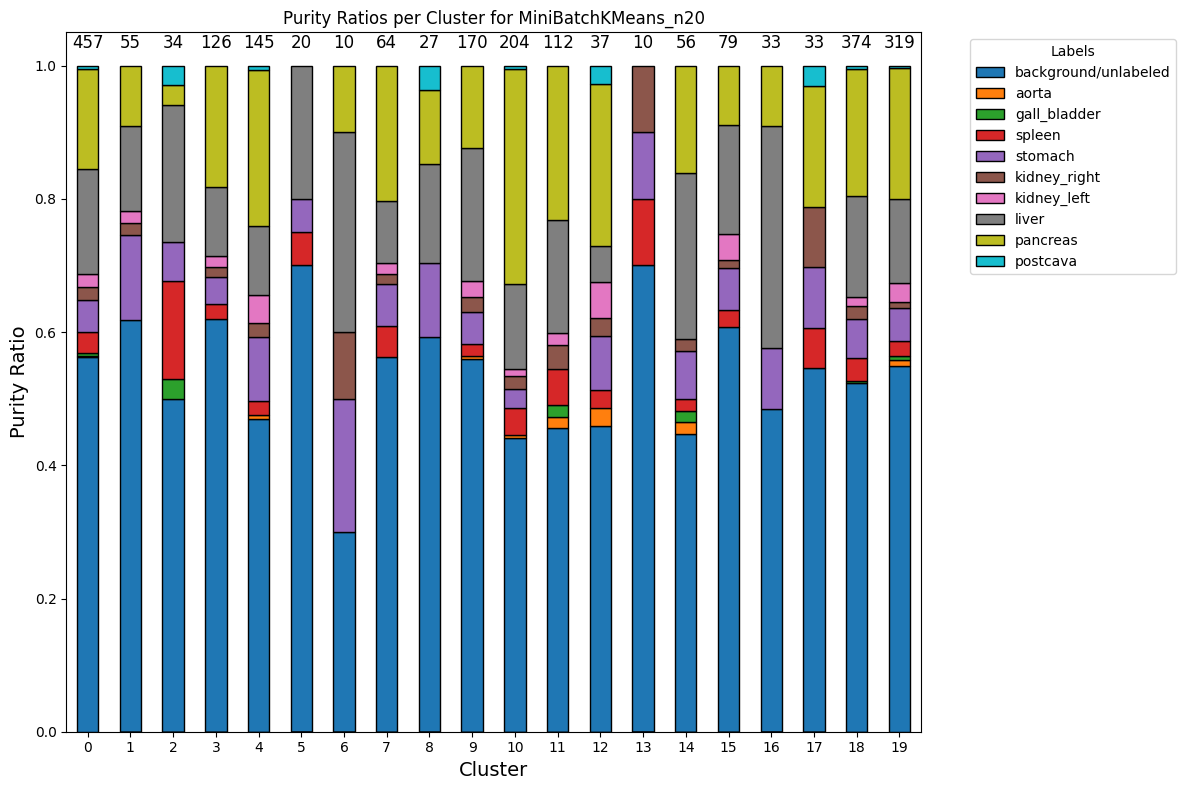

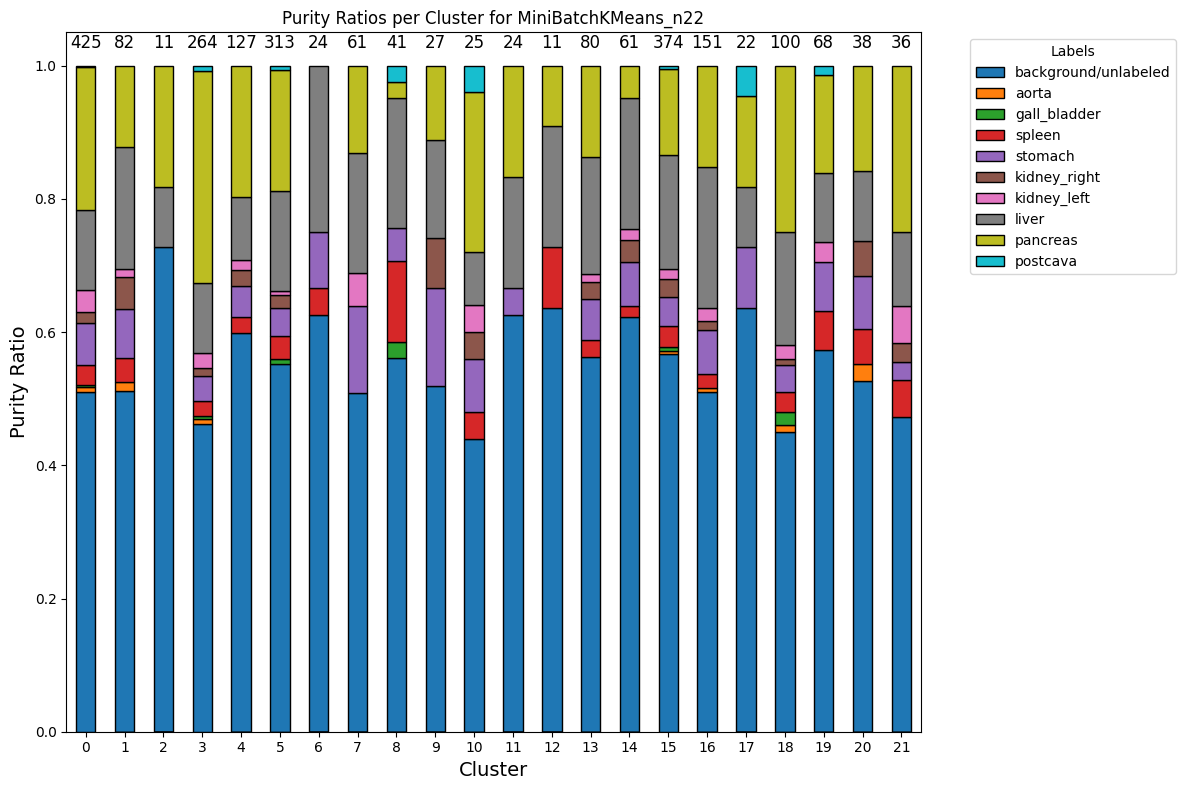

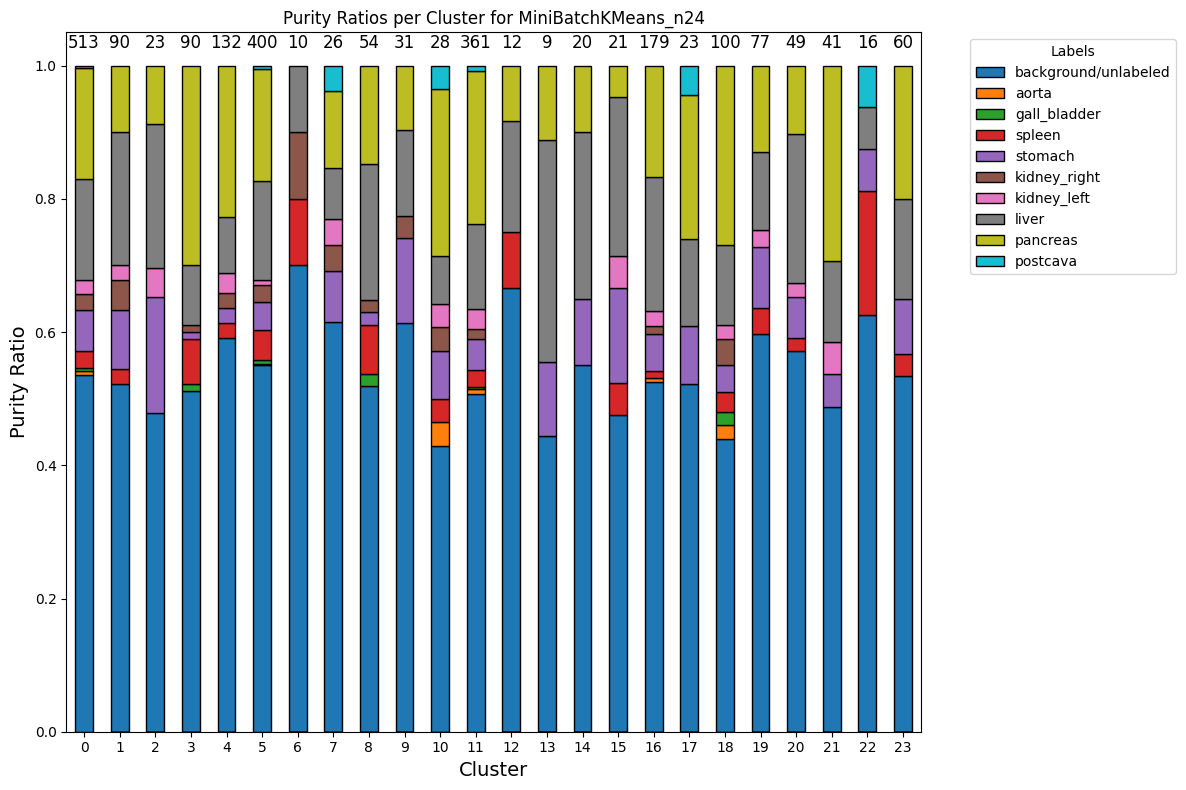

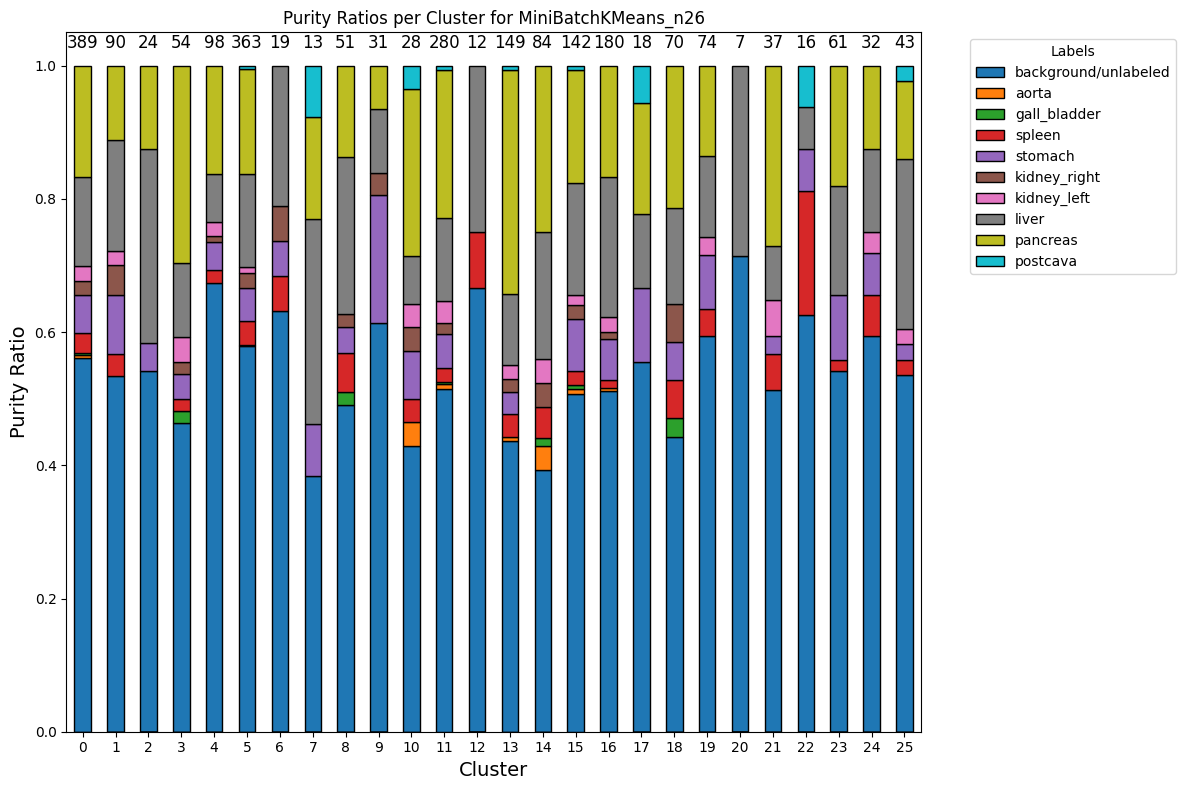

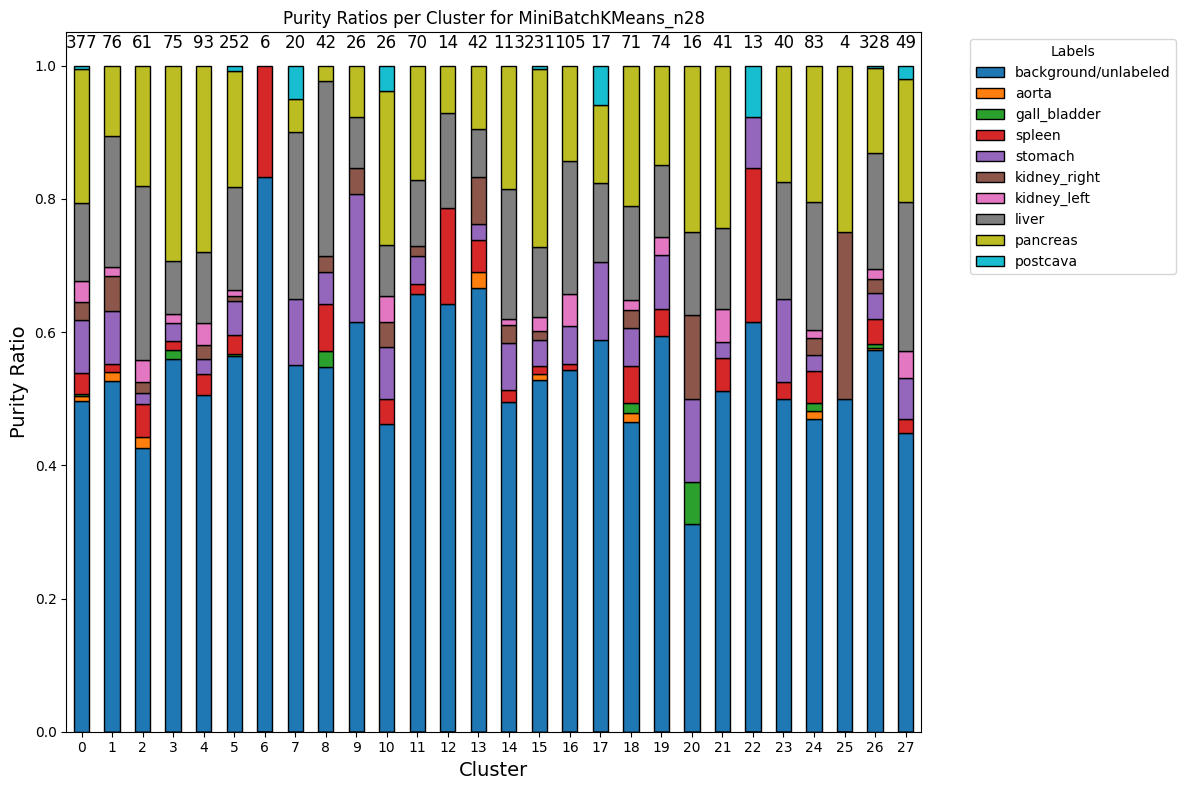

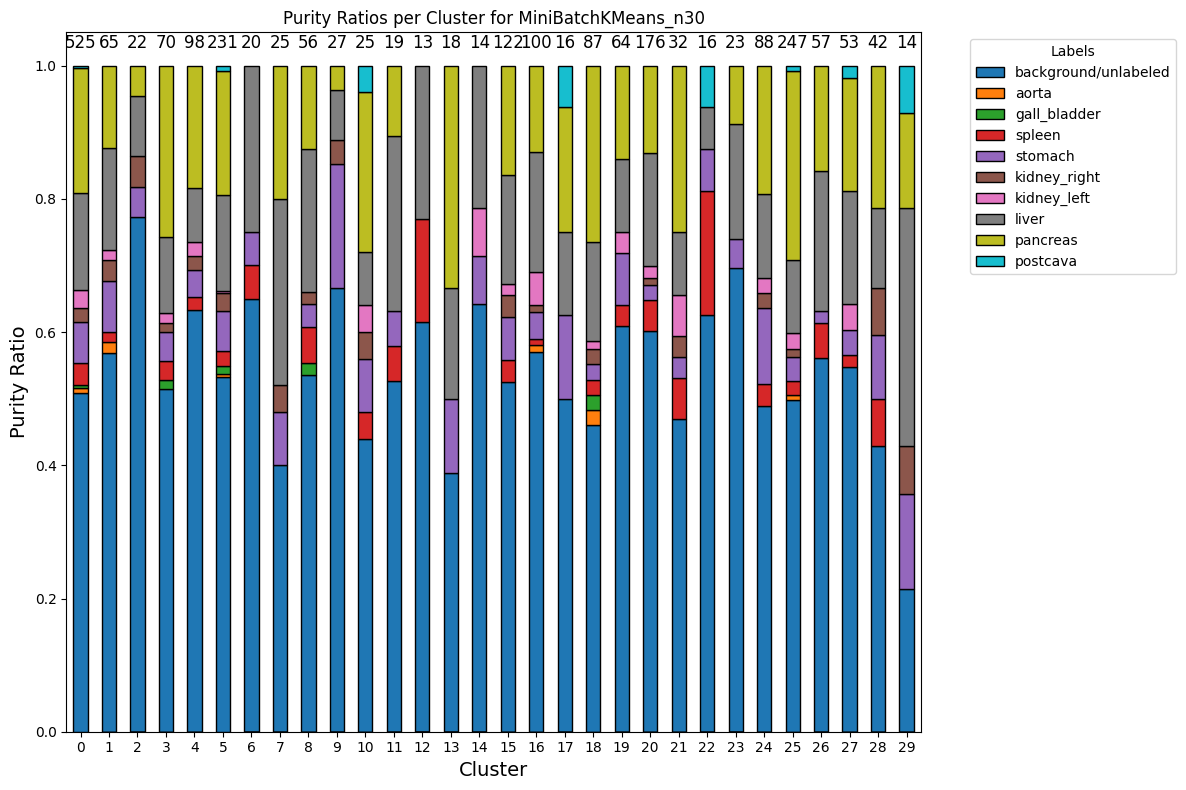

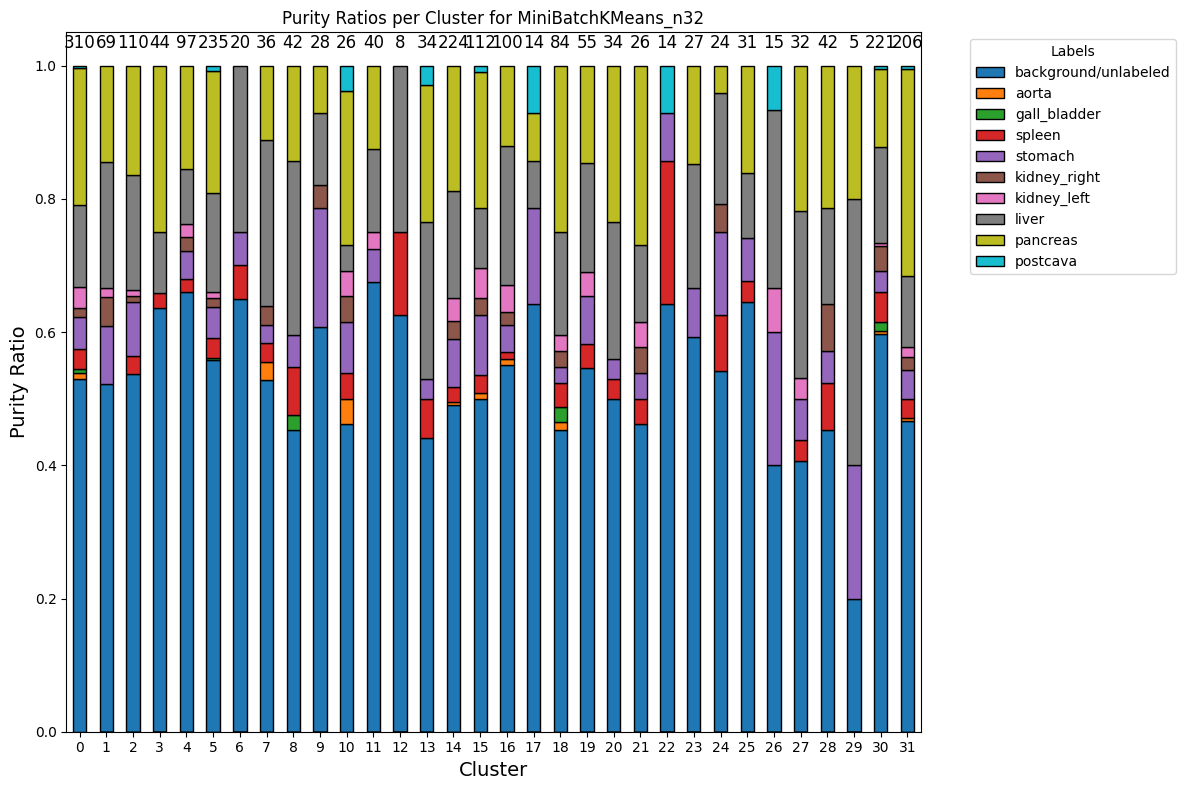

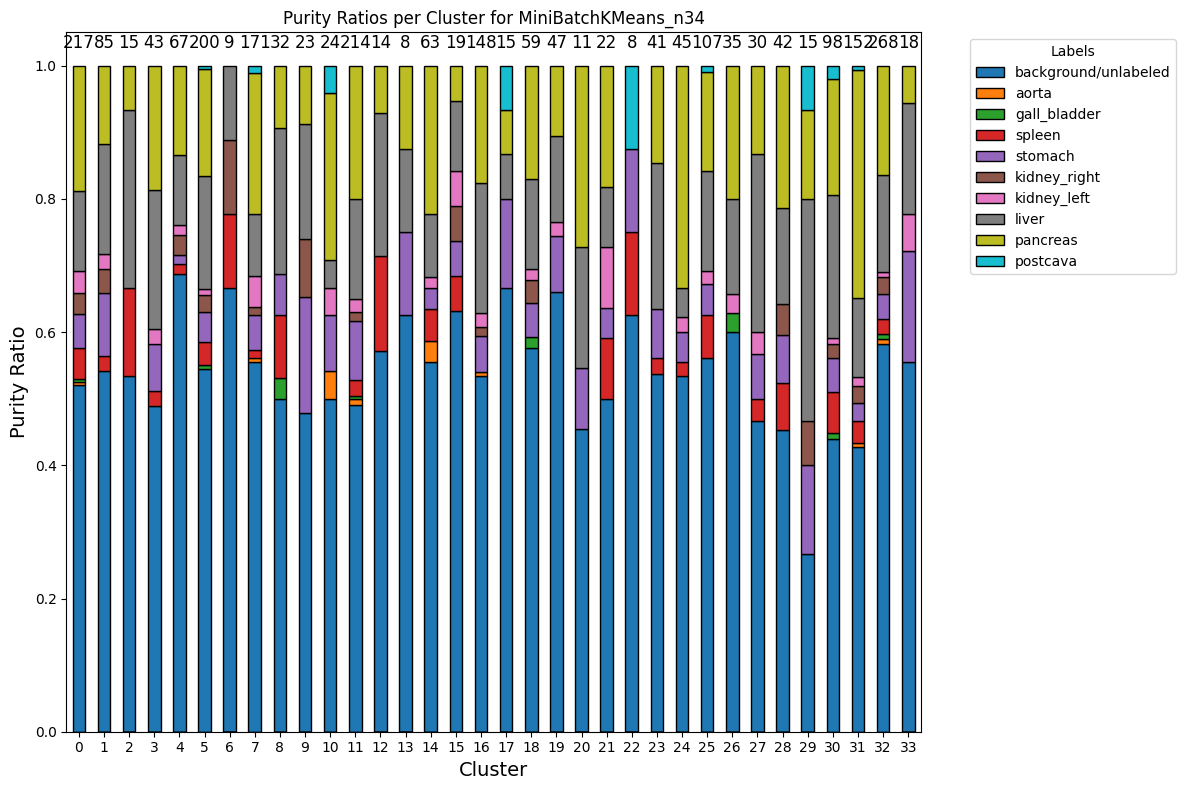

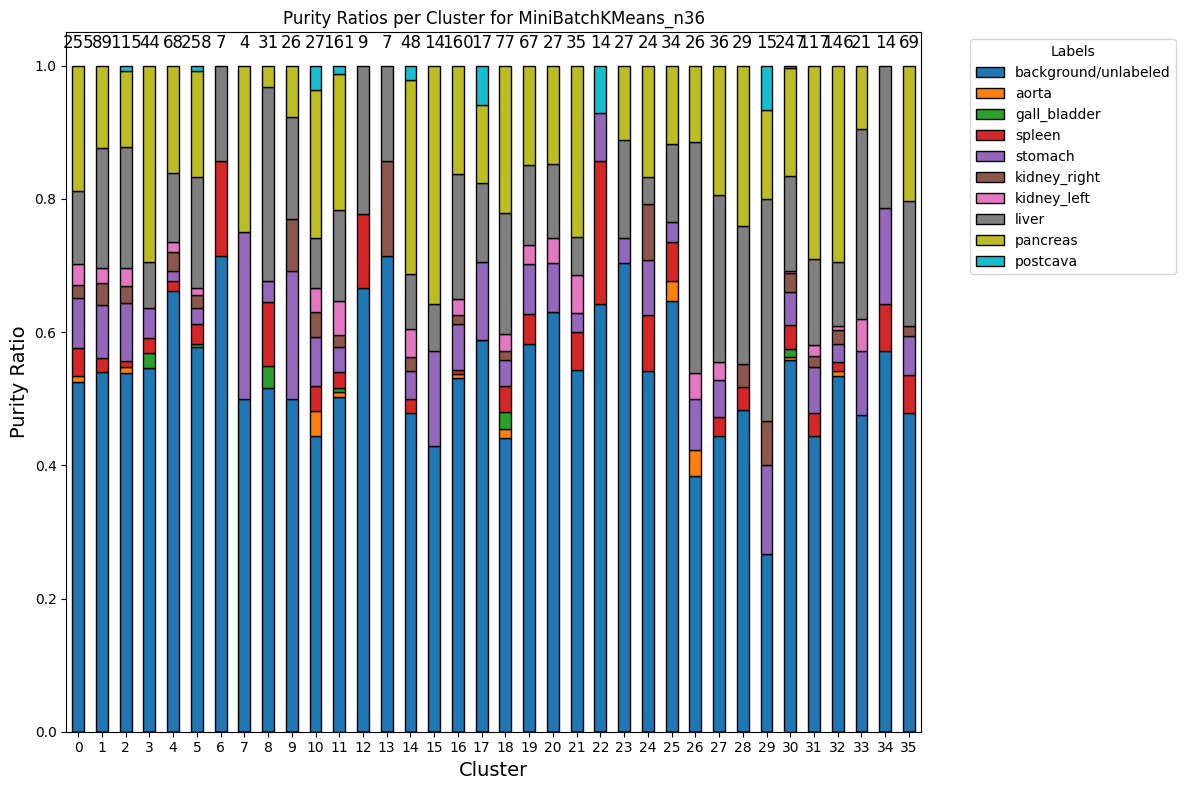

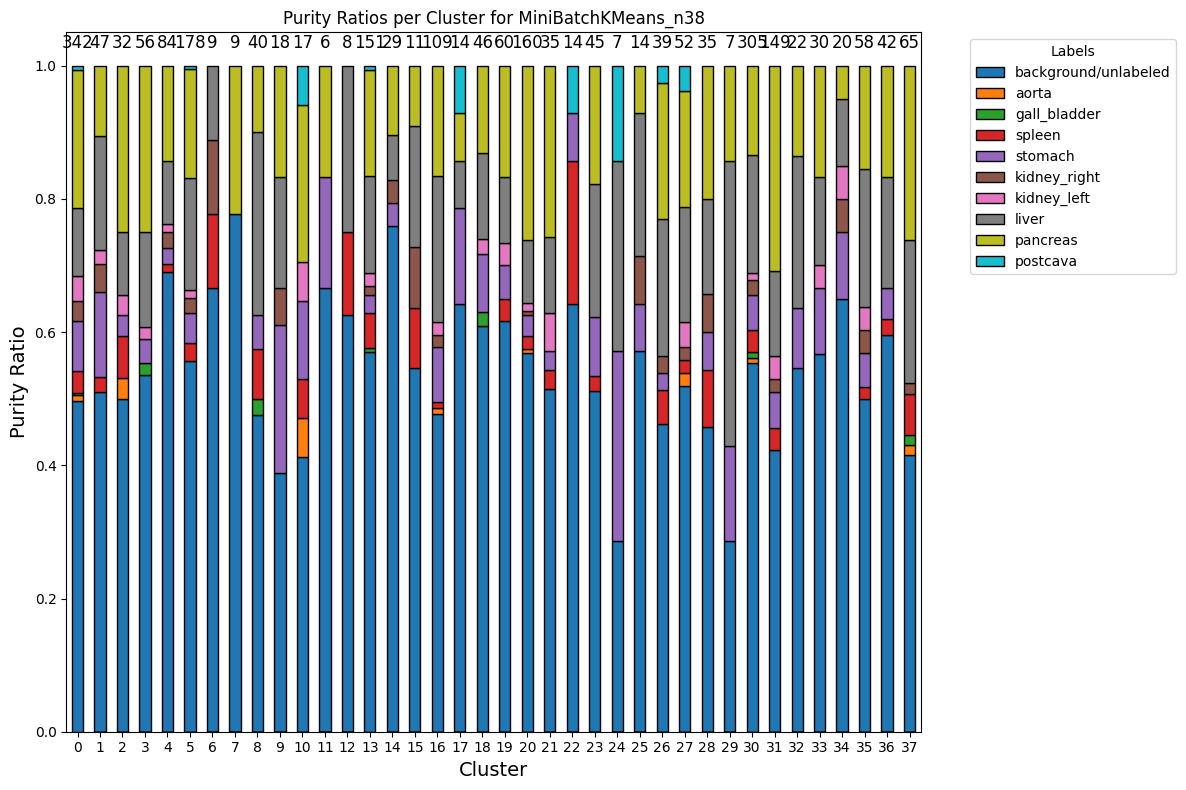

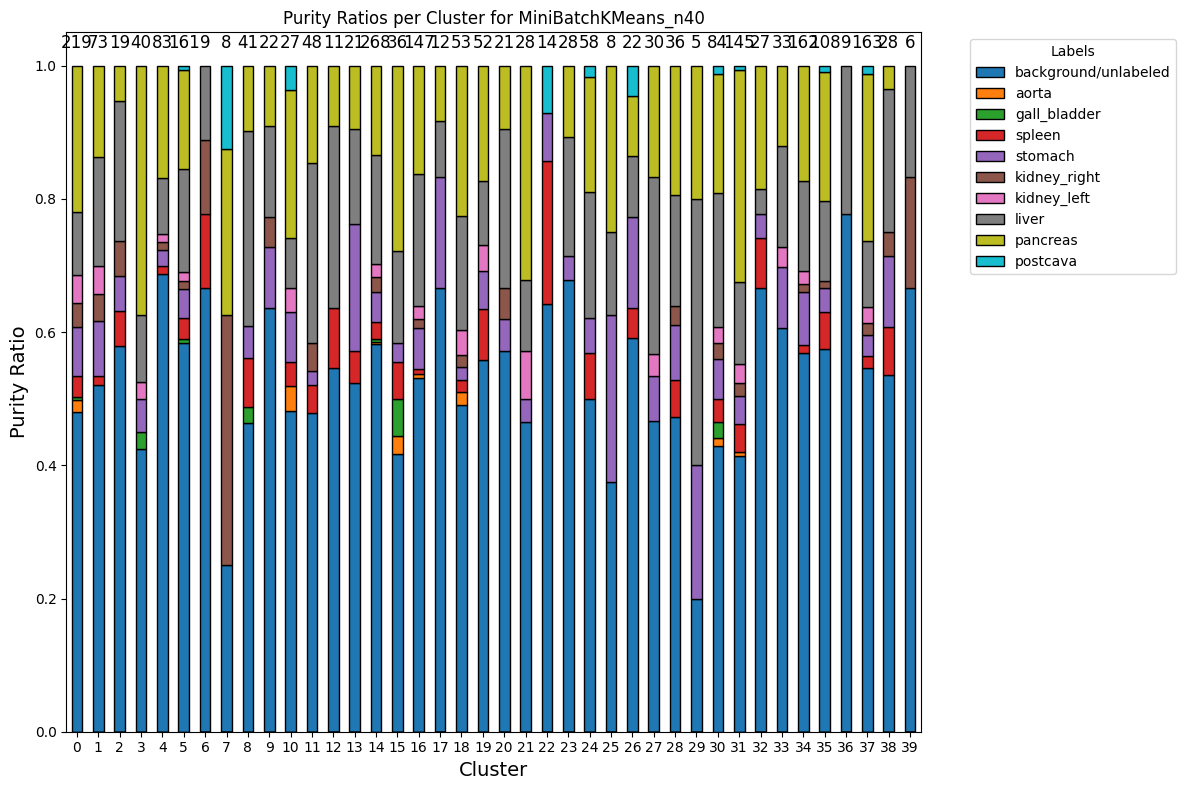

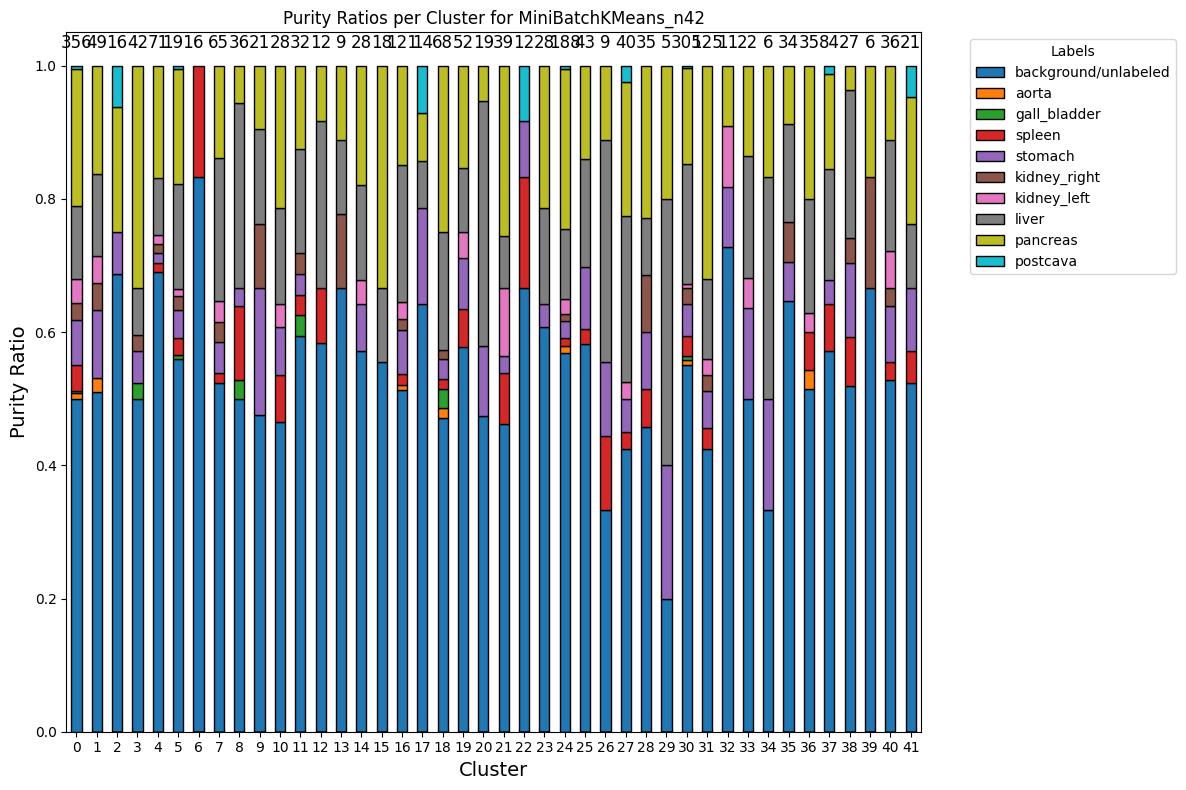

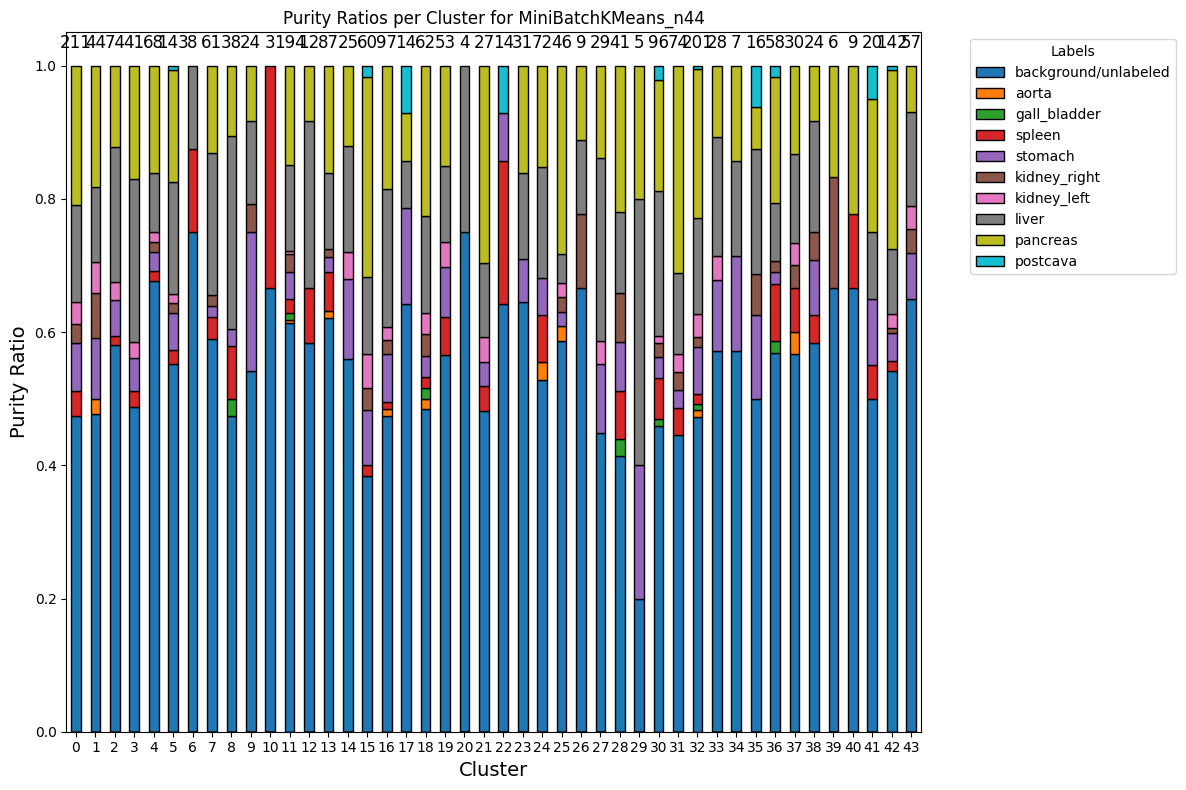

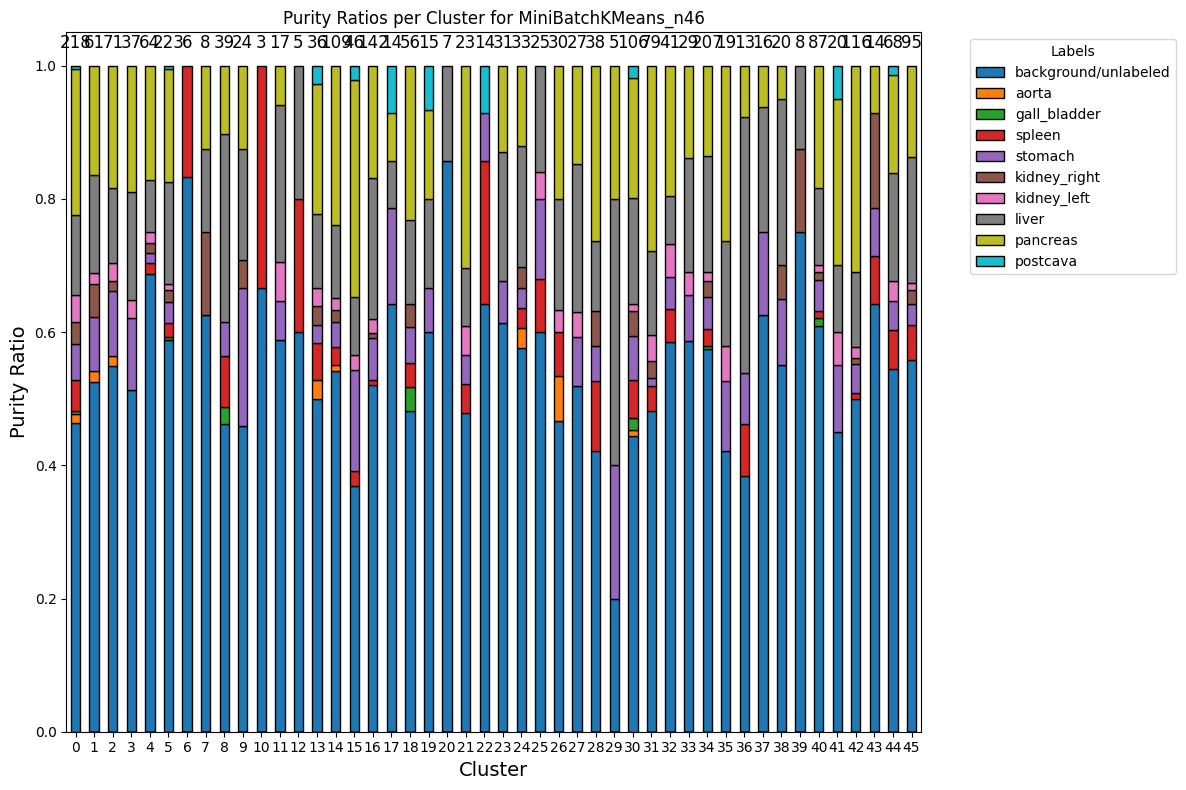

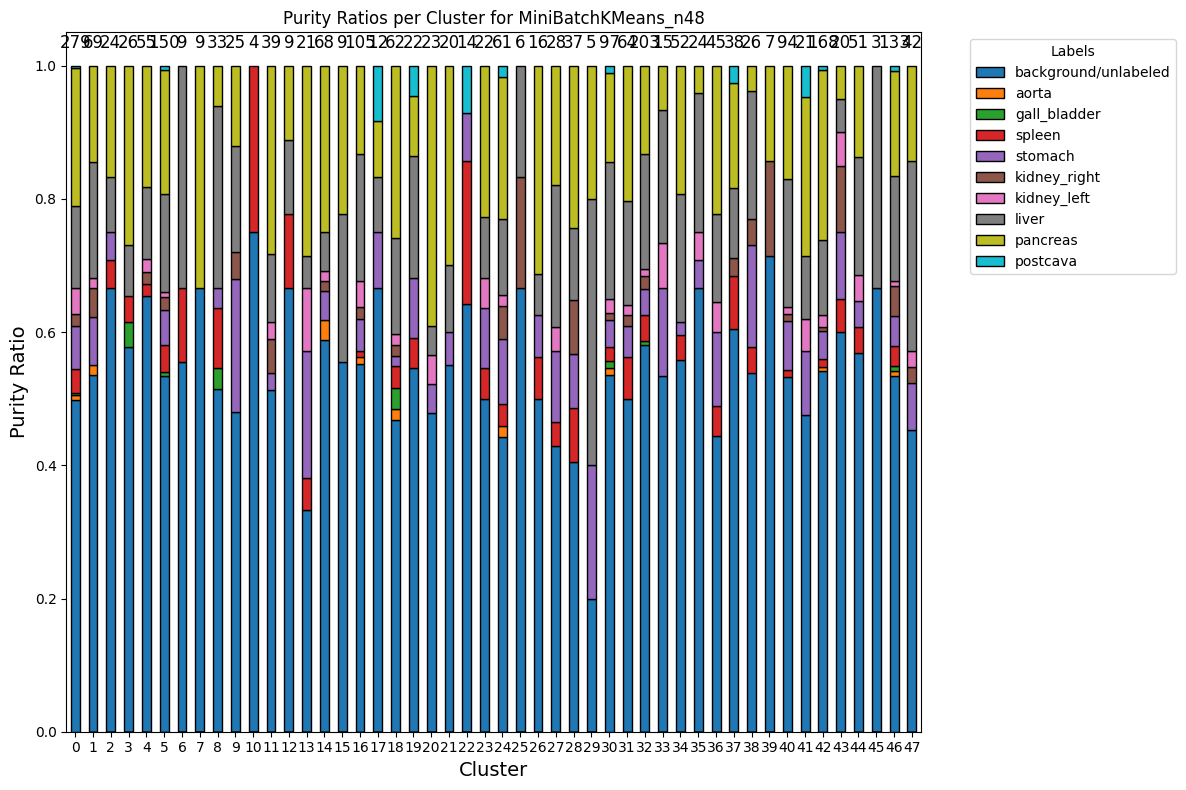

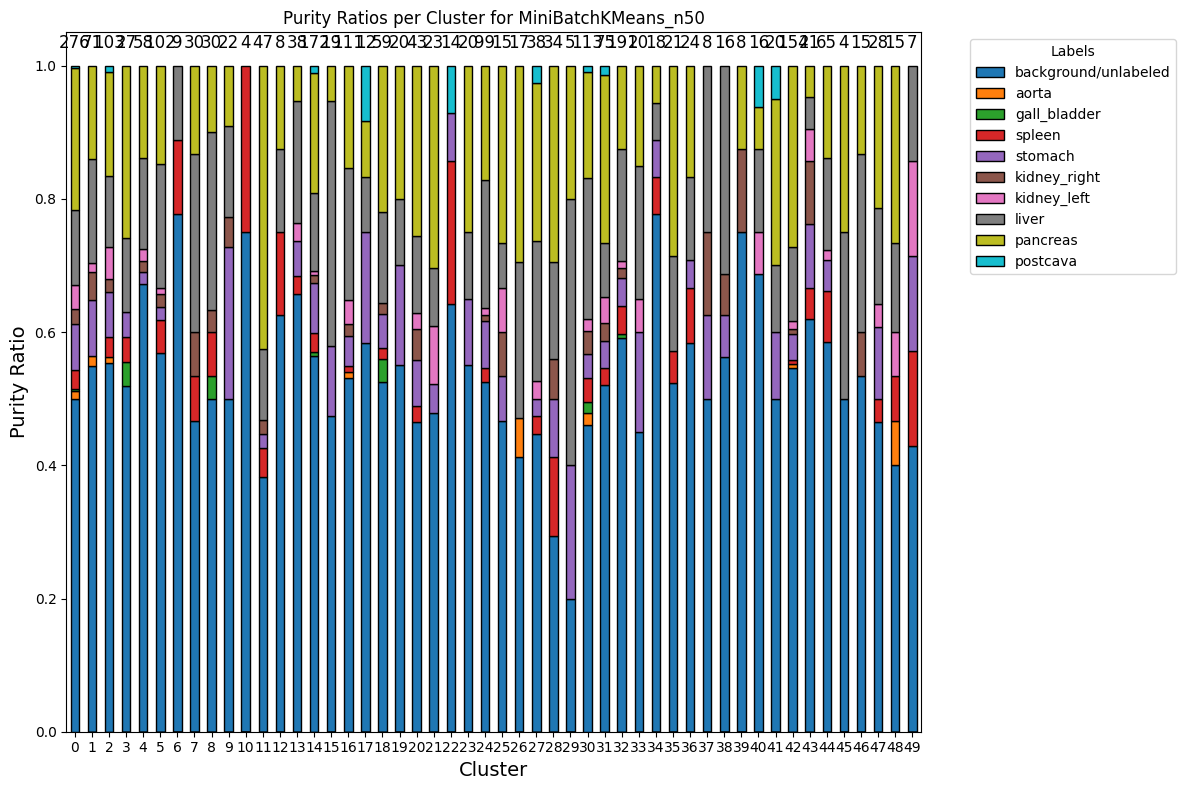

In [187]:
cluster_results, algorithms = cluster_and_plot_purities(data, labels)#, use_case='multi-class')

## Random State Sampled Points interesting clustering results

Random state 1
2 also (Last column in clustering - clusters 29,49)
3
4
5


## Analyzing Clusters

`random_state=50`, cluster #49

In [13]:
kmeans_random_state = 1

In [14]:
flat_enc_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_enc_cts)#.unsqueeze(0))#(0))[0]

data = raw_cubes_middle_vecs.numpy()
labels = sampled_points_multi_organ_labels.flatten().numpy()

Clustering Algorithms: 100%|██████████| 1/1 [00:01<00:00,  1.05s/alg]


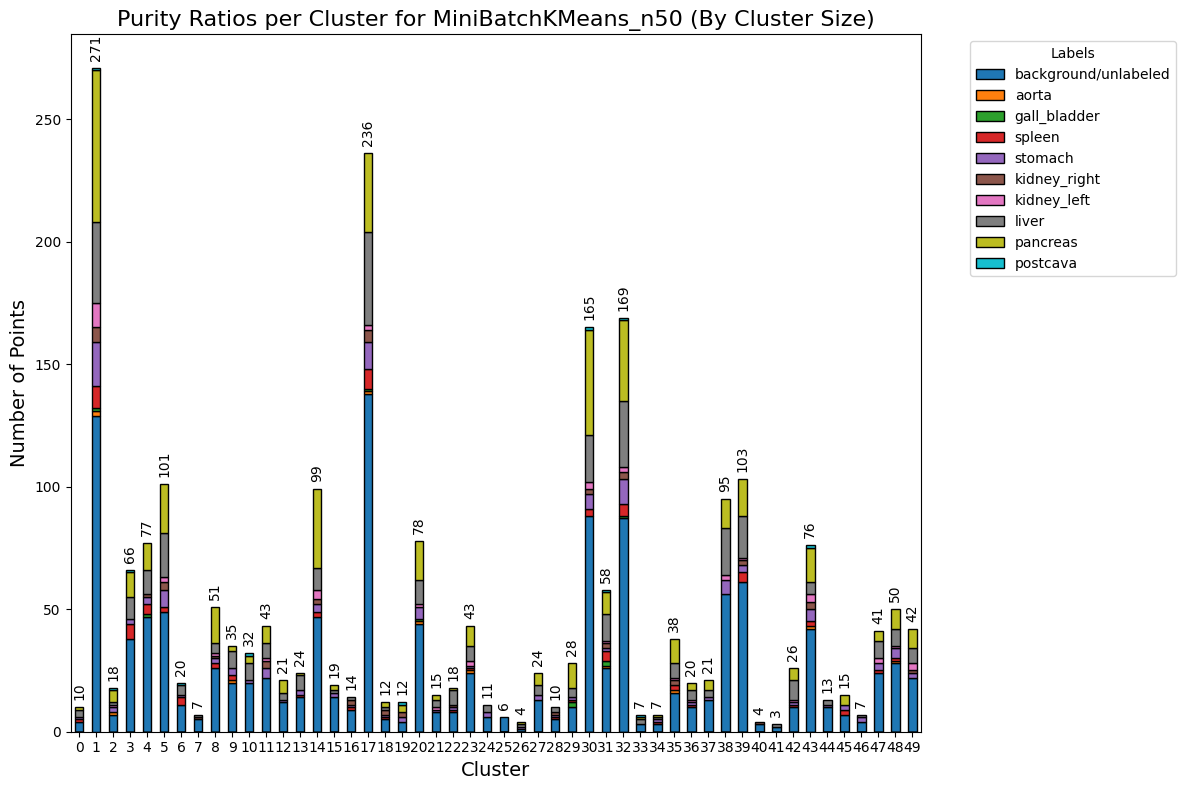

In [15]:
purity_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=[50], random_state=kmeans_random_state, normalize_bars=False)

Clustering Algorithms: 100%|██████████| 1/1 [00:00<00:00,  1.27alg/s]


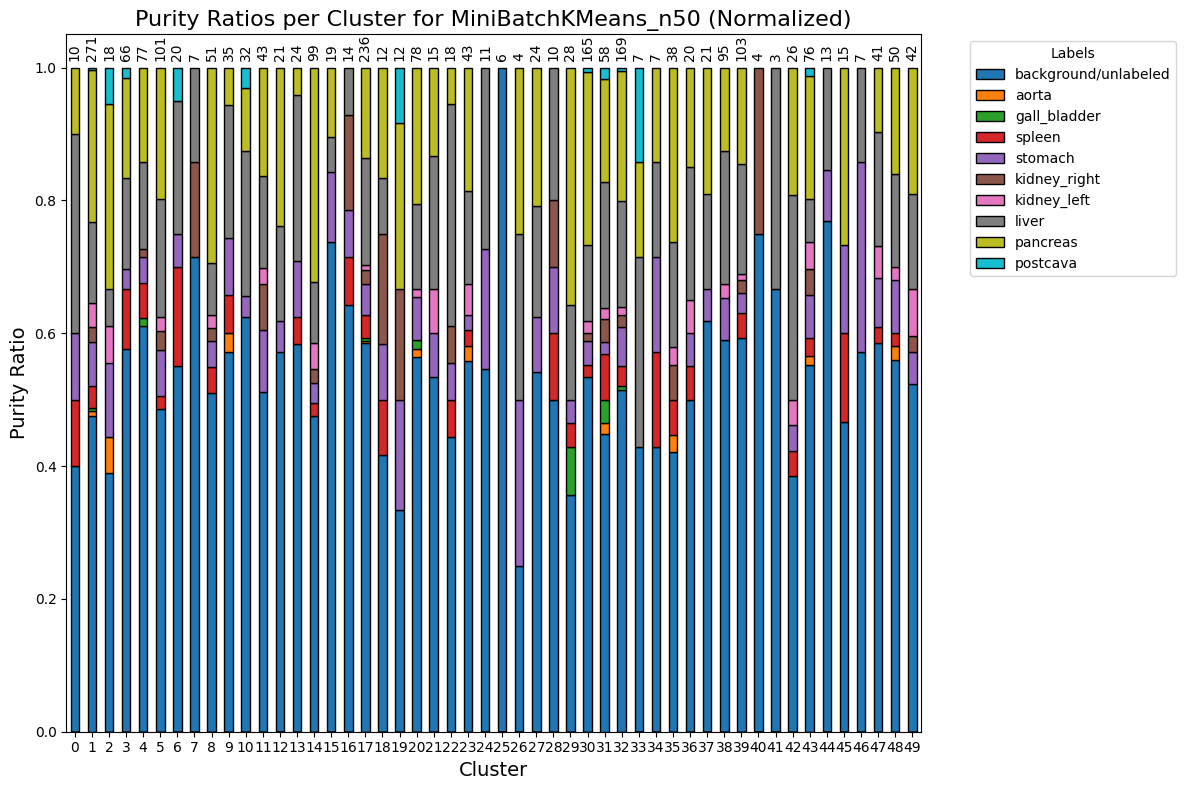

In [16]:
purity_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=[50], random_state=1)

In [ ]:
algorithms[0]

('MiniBatchKMeans_n50',
 MiniBatchKMeans(batch_size=10000, n_clusters=50, n_init='auto', random_state=1))

In [30]:
import numpy as np

def map_cluster_labels_to_sampled_points(cluster_labels: np.ndarray, all_filtered_ids: list, all_encoded_cubes: np.ndarray, sampled_points_coordinates: np.ndarray):
    """
    Maps cluster labels to sampled points and returns their coordinates and corresponding patient IDs.

    Parameters:
    cluster_labels (np.ndarray): Array of cluster labels for all points, shape [n_samples * n_points_per_sample]
    all_filtered_ids (list): List of patient IDs corresponding to each sample.
    all_encoded_cubes (np.ndarray): Array of encoded cubes, shape [n_samples, n_points_per_sample, ...]
    sampled_points_coordinates (np.ndarray): Array of coordinates, shape [n_samples, n_points_per_sample, coord_dim]

    Returns:
    all_coords (np.ndarray): Flattened array of coordinates for all points, shape [total_points, coord_dim]
    all_patient_ids (list): List of patient IDs corresponding to each coordinate.
    all_cluster_labels (np.ndarray): Flattened array of cluster labels corresponding to each coordinate.
    """
    n_samples = all_encoded_cubes.shape[0]
    n_points_per_sample = all_encoded_cubes.shape[1]

    # Reshape cluster_labels to match [n_samples, n_points_per_sample]
    reshaped_labels = cluster_labels.reshape(n_samples, n_points_per_sample)

    # Flatten the arrays
    all_coords = sampled_points_coordinates.reshape(-1, sampled_points_coordinates.shape[-1])
    all_patient_ids = np.repeat(all_filtered_ids, n_points_per_sample)
    all_cluster_labels = reshaped_labels.flatten()

    return all_coords, all_patient_ids, all_cluster_labels


from collections import defaultdict
import os
import numpy as np

def save_clusters_by_patient(all_coords, all_patient_ids, cluster_labels: list, base_path, target_clusters: list, filename_prefix='minikmeans50_random_state_1'):
    """
    Saves specified clusters as ITK-SNAP annotations for each patient.

    Parameters:
    all_coords (array): Array of coordinates representing points.
    all_patient_ids (list): List of patient IDs corresponding to the coordinates.
    cluster_labels (list): List of cluster labels corresponding to each coordinate.
    base_path (str): Base path where the annotation files will be saved.
    target_clusters (list): List of cluster labels to process.
    filename_prefix (str): Prefix for the output annotation file names.
    """
    # Filter data to include only target clusters
    cluster_mask = np.isin(cluster_labels, target_clusters)
    filtered_coords = all_coords[cluster_mask]
    filtered_patient_ids = np.array(all_patient_ids)[cluster_mask]
    filtered_cluster_labels = cluster_labels[cluster_mask]

    # Group coordinates and cluster labels by patient ID
    patient_data_map = defaultdict(lambda: {"coords": [], "labels": []})

    # Populate the map with coordinates and cluster labels for each patient ID
    for coord, patient_id, label in zip(filtered_coords, filtered_patient_ids, filtered_cluster_labels):
        patient_data_map[patient_id]["coords"].append(coord)
        patient_data_map[patient_id]["labels"].append(label)
    
    # Iterate over each patient ID and corresponding data to save annotations
    for patient_id, data in patient_data_map.items():
        pth = os.path.join(base_path, "cluster_assignments", patient_id)

        if not os.path.exists(pth):
            os.makedirs(pth)

        coords_array = np.array(data["coords"])
        labels_array = np.array(data["labels"])

        # For each unique cluster label in this patient's data, save annotations
        unique_clusters = np.unique(labels_array)
        for cluster_label in unique_clusters:
            cluster_coords = coords_array[labels_array == cluster_label]
            save_clusters_as_itk_snap_annotations(
                cluster_coords, 
                [cluster_label]*len(cluster_coords),
                base_dir=pth, 
                filename=f'{filename_prefix}_cluster_{cluster_label}.annot'
            )

In [23]:
all_coords, all_patient_ids, all_cluster_labels = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, all_encoded_cubes, sampled_points_coordinates)
all_cluster_labels

array([30,  8, 12, ..., 39, 17, 30], dtype=int32)

In [36]:
save_clusters_by_patient(all_coords.numpy(), all_patient_ids, all_cluster_labels, base_path, target_clusters=[40,41,42], filename_prefix='minikmeans50_random_state_1')

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000002/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000110/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000351/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000878/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000928/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 189 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001

In [ ]:
# TODO this only works when a cluster has points only from a single CT
c40_coords, c40_patient_ids = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, cluster=40)
c40_labels = [[40]] * len(c40_coords)
c41_coords, c41_patient_ids = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, cluster=41)
c41_labels = [[41]] * len(c41_coords)
c42_coords, c42_patient_ids = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, cluster=42)
c42_labels = [[42]] * len(c42_coords)
c42_coords, c42_patient_ids

In [60]:
from collections import defaultdict
import os
import numpy as np

def save_clusters_by_patient(all_coords, all_patient_ids, cluster_labels: int, base_path, filename_prefix='minikmeans50_random_state_1'):
    """
    Saves clusters as ITK-SNAP annotations for each patient.
    
    Parameters:
    all_coords (array): Array of coordinates representing points.
    all_patient_ids (list): List of patient IDs corresponding to the coordinates.
    cluster_labels (int): TODO make this a List of cluster labels corresponding to each coordinate.
    base_path (str): Base path where the annotation files will be saved.
    filename_prefix (str): Prefix for the output annotation file names.
    """
    # Group coordinates and cluster labels by patient ID
    patient_data_map = defaultdict(lambda: {"coords": [], "labels": []})
    
    # Populate the map with coordinates and cluster labels for each patient ID
    for coord, patient_id in zip(all_coords, all_patient_ids):
        patient_data_map[patient_id]["coords"].append(coord)
        patient_data_map[patient_id]["labels"].append(cluster_labels)
    
    # Iterate over each patient ID and corresponding data to save annotations
    for patient_id, data in patient_data_map.items():
        pth = os.path.join(base_path, "cluster_assignments", patient_id)
        
        if not os.path.exists(pth):
            os.makedirs(pth)
        
        # Convert lists to numpy arrays before passing them to the function
        coords_array = np.array(data["coords"])
        labels_array = np.array(data["labels"])
        
        # Call the function to save clusters as annotations
        save_clusters_as_itk_snap_annotations(
            coords_array, 
            labels_array,
            base_dir=pth, 
            filename=f'{filename_prefix}_cluster_{cluster_labels}.annot'
        )

# Example usage:
# save_clusters_by_patient(c40_coords, c40_patient_ids, cluster_labels, base_path)

In [36]:
c40_coords.shape

(4, 3)

In [40]:
np.array(c40_labels).shape

(4, 1)

In [61]:
save_clusters_by_patient(c40_coords, c40_patient_ids, 40, base_path)

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000002/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001662/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001942/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00004098/minikmeans50_random_state_1_cluster_40.annot'.


In [62]:
save_clusters_by_patient(c41_coords, c41_patient_ids, 41, base_path)

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00002650/minikmeans50_random_state_1_cluster_41.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00003644/minikmeans50_random_state_1_cluster_41.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00003876/minikmeans50_random_state_1_cluster_41.annot'.


In [63]:
save_clusters_by_patient(c42_coords, c42_patient_ids, 42, base_path)

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000110/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000351/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000878/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000928/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001348/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_000016

In [66]:
len(c42_coords)

26

In [64]:
pd.DataFrame(c42_patient_ids).value_counts()

BDMAP_00000110    1
BDMAP_00002753    1
BDMAP_00004231    1
BDMAP_00004098    1
BDMAP_00003577    1
BDMAP_00003265    1
BDMAP_00003154    1
BDMAP_00003013    1
BDMAP_00002650    1
BDMAP_00000351    1
BDMAP_00002569    1
BDMAP_00002212    1
BDMAP_00001662    1
BDMAP_00001348    1
BDMAP_00000928    1
BDMAP_00000878    1
BDMAP_00004360    1
dtype: int64

In [58]:
pth = os.path.join(base_path, "cluster_assignments")

if not os.path.exists(pth):
    os.makedirs(pth)

save_clusters_as_itk_snap_annotations(c40_coords, c40_labels, base_dir=pth,  filename='minikmeans50_random_state_1.annot')

Successfully saved 693 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/minikmeans50_random_state_1.annot'.


In [60]:
len(all_filtered_ids)

43

In [ ]:
# As a test, save true labels
# save_clusters_as_itk_snap_annotations(sampled_points_coordinates[0].numpy(), labels[:55], filename='true_labels.annot')

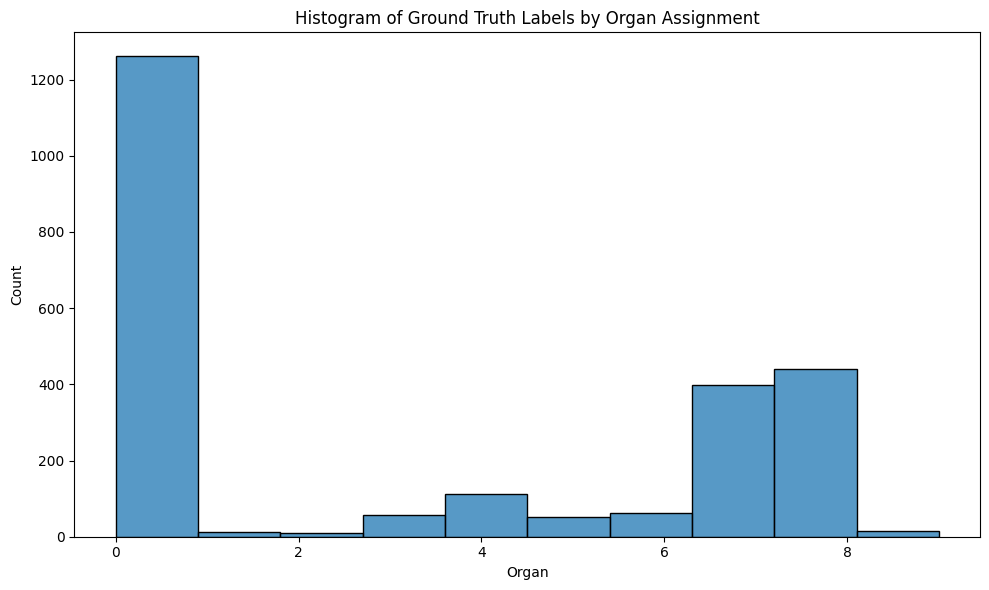

Clustering Algorithms:   0%|          | 0/1 [00:00<?, ?alg/s]


TypeError: cannot unpack non-iterable MiniBatchKMeans object

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot histogram of ground truth labels by organ assignment
plt.figure(figsize=(10, 6))
sns.histplot(labels, bins=len(reverse_organs_dict), kde=False)
plt.title("Histogram of Ground Truth Labels by Organ Assignment")
plt.xlabel("Organ")
plt.ylabel("Count")
# plt.xticks(ticks=list(reverse_organs_dict.values()), labels=list(reverse_organs_dict.keys()), rotation=45)
plt.tight_layout()
plt.show()


purity_results = calculate_purities(
    data=data,
    labels=labels,
    algorithms=[minibatchkmeans_38],
    plot=True  # Set to False if you don't want plots
)

# Plot histogram of points assigned in each cluster
cluster_assignments = purity_results['Cluster']

plt.figure(figsize=(10, 6))
sns.histplot(cluster_assignments, bins=len(cluster_assignments.unique()), kde=False)
plt.title("Histogram of Points Assigned in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Pancreas vs. Background Labels Purity

In [ ]:
pancreas_vs_background_labels = middle_binary_labels

## Full Data, Flattened

### KMeans for range(2, 100, 2) Clusters

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans#, Birch - too slow
import hdbscan  # Optional, if you decide to use HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 102, 2)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    # MiniBatchKMeans
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init=10  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=full_pca_data,
    labels=pancreas_vs_background_labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

In [ ]:
count_zeros = (pancreas_vs_background_labels == 0).sum().item()
count_ones = (pancreas_vs_background_labels == 1).sum().item()

print(count_zeros, count_ones)

print(count_zeros / len(pancreas_vs_background_labels), count_ones / len(pancreas_vs_background_labels))

### OPTICS

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import OPTICS

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'OPTICS_{n_clusters}'
    mbk = OPTICS(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors_full_pca,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

### HDBSCAN

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from hdbscan import HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'hdbscan_{n_clusters}'
    mbk = HDBSCAN(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors_full_pca,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

# Labels: Hounsfield Units Tissue Type

In [44]:
tissue_labels = {
        1: 'Air/Gas',
        2: 'Lung Tissue',
        3: 'Low-Density Tissue',
        4: 'Adipose Tissue (Fat)',
        5: 'Water/Fluids',
        6: 'Muscle',
        7: 'Soft Organ Parenchyma',
        8: 'Soft Tissue with Contrast',
        9: 'Blood Vessels/Contrast Agents',
        10: 'Cancellous Bone',
        11: 'Cortical Bone',
        12: 'Metal/Implants/High-Density'
    }


In [51]:
# Load hounsfield_density_labels.pt
hounsfield_density_labels = torch.load(base_path / 'hounsfield_density_labels.pt')

# Perform CLuster purity as usual

In [61]:
flat_enc_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_enc_cts)#.unsqueeze(0))#(0))[0]

data = raw_cubes_middle_vecs

In [53]:
flat_enc_hu_labels = flatten_features(hounsfield_density_labels)
hu_labels_middle_vecs, _ = extract_middle_vectors(flat_enc_hu_labels)#.unsqueeze(0))#(0))[0]

In [54]:
hu_labels_middle_vecs.shape

torch.Size([2365, 1])

In [55]:
labels = hu_labels_middle_vecs.flatten().numpy()

In [56]:
pd.DataFrame(labels).value_counts()

8.0     715
3.0     577
7.0     361
6.0     292
5.0     122
4.0     102
1.0      72
0.0      51
2.0      32
9.0      24
10.0     17
dtype: int64

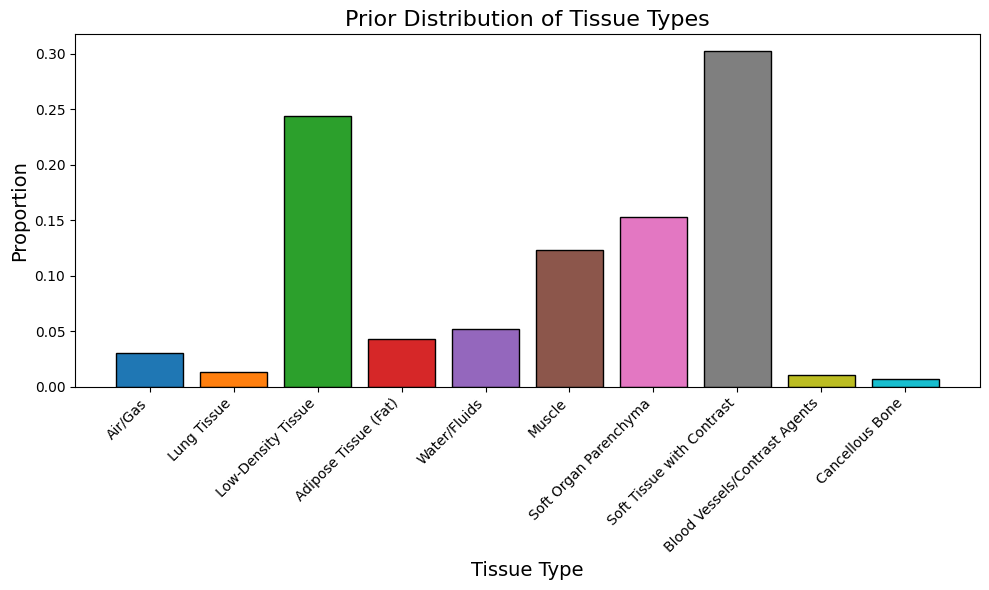

Clustering Algorithms: 100%|██████████| 25/25 [00:21<00:00,  1.18alg/s]


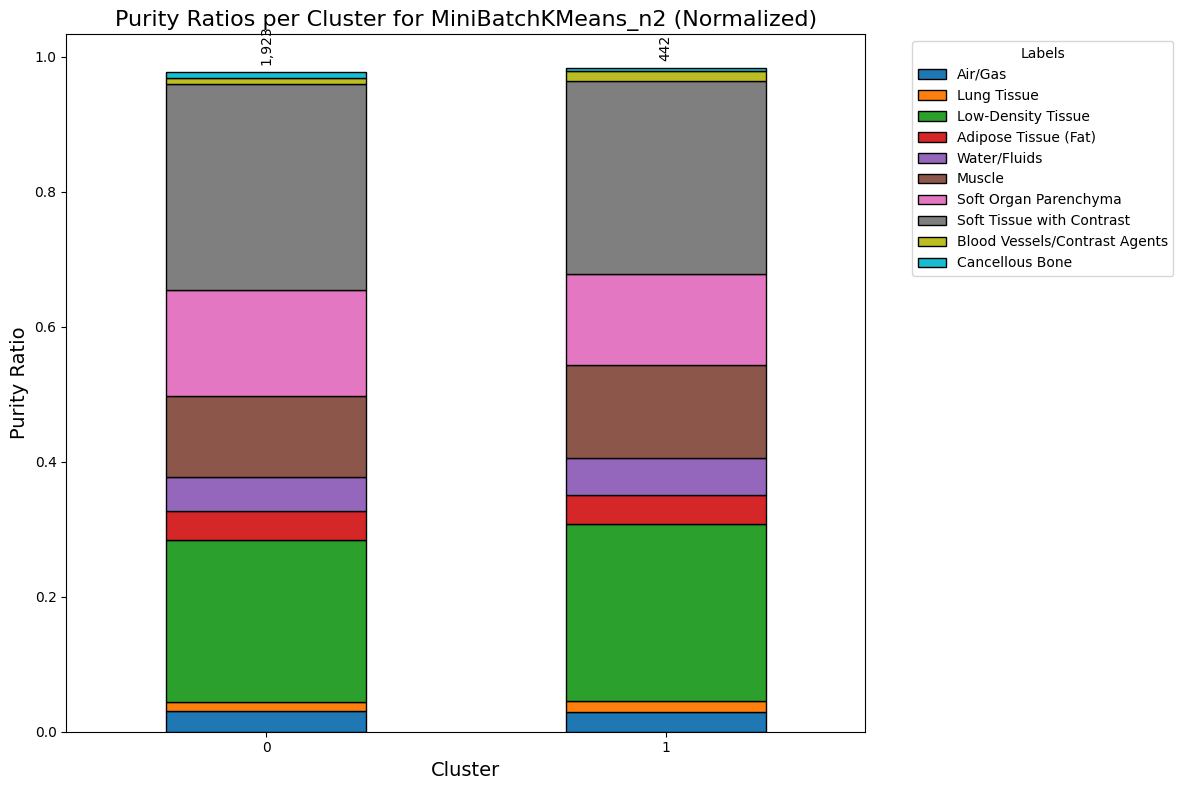

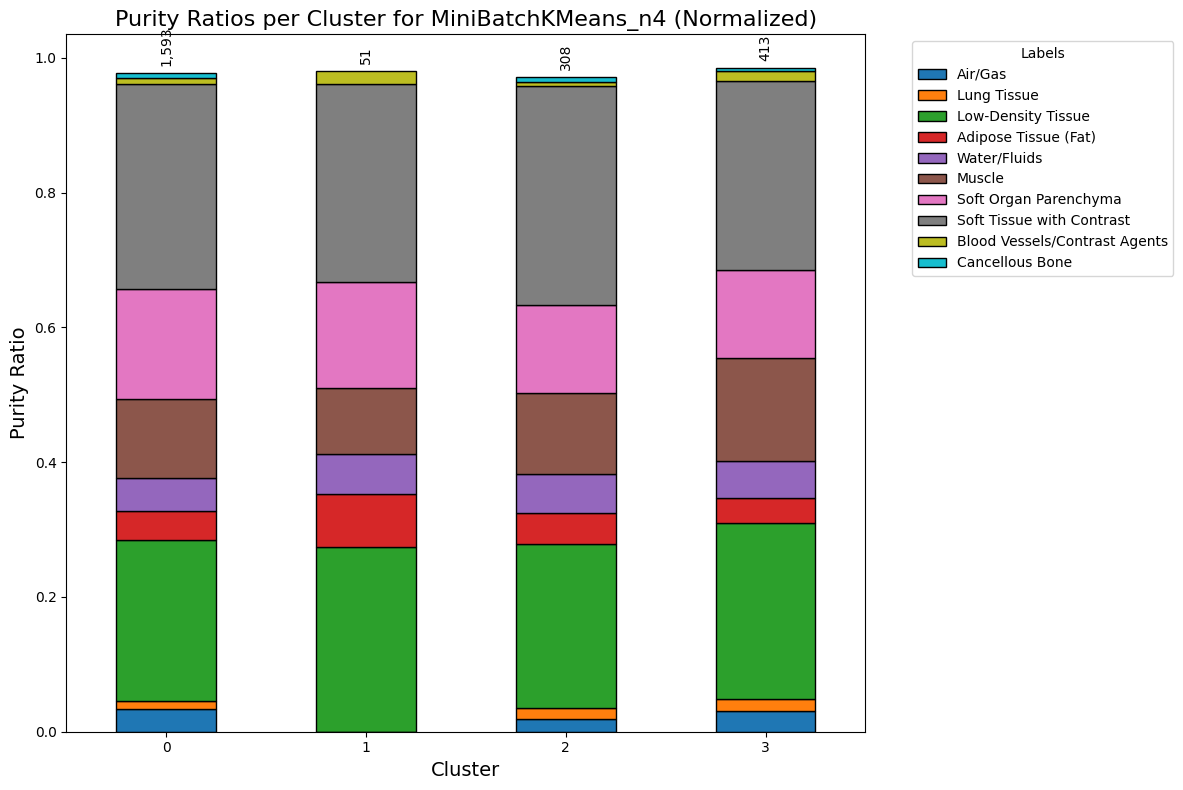

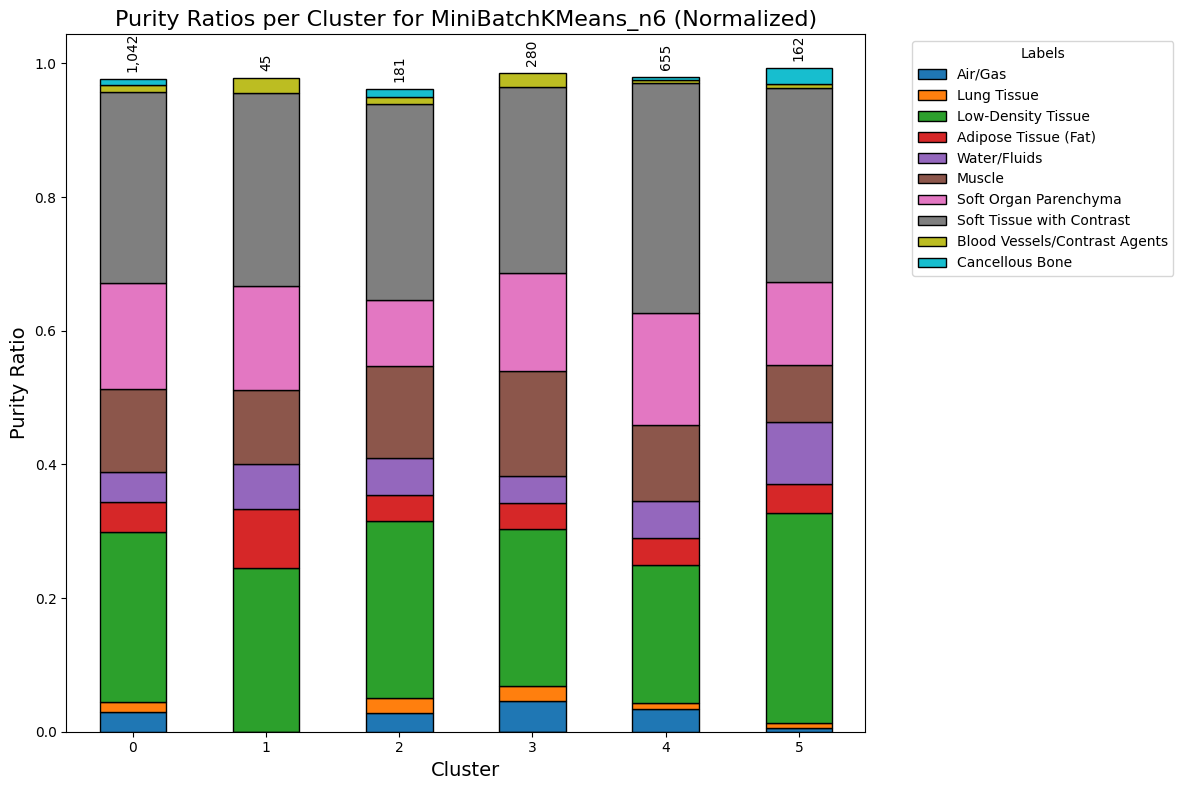

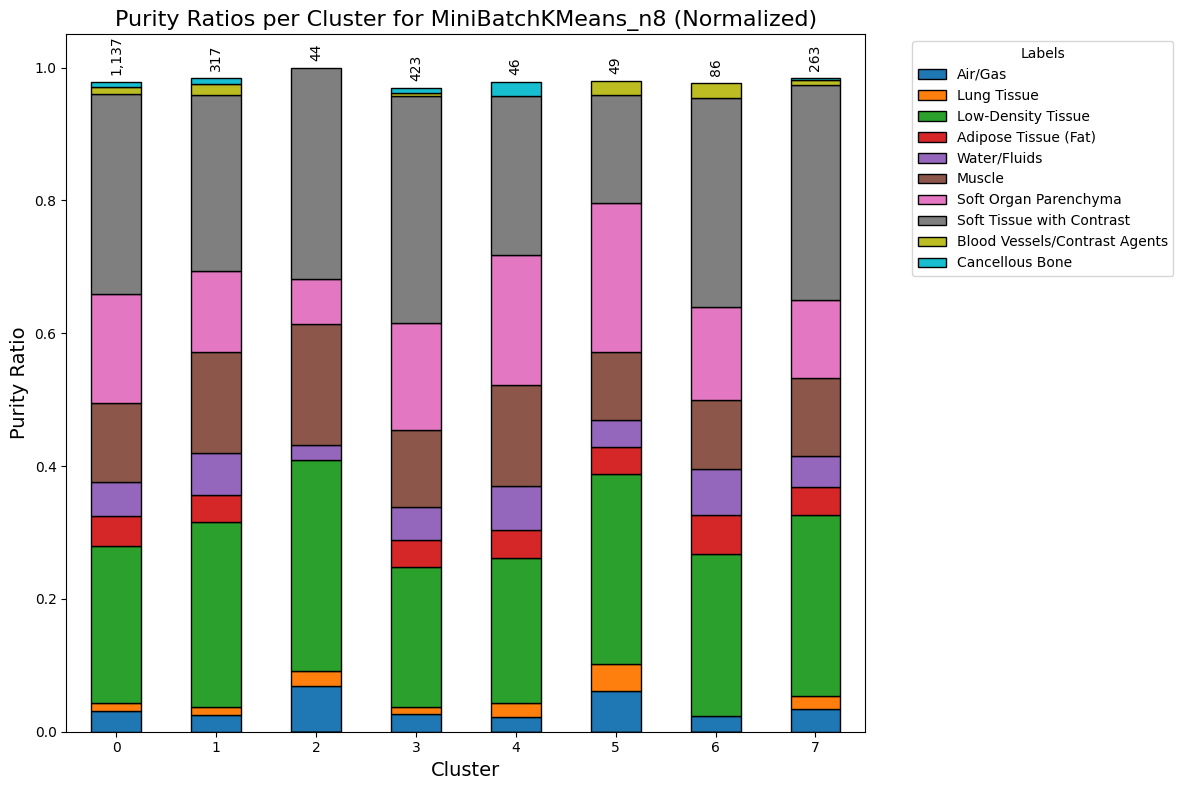

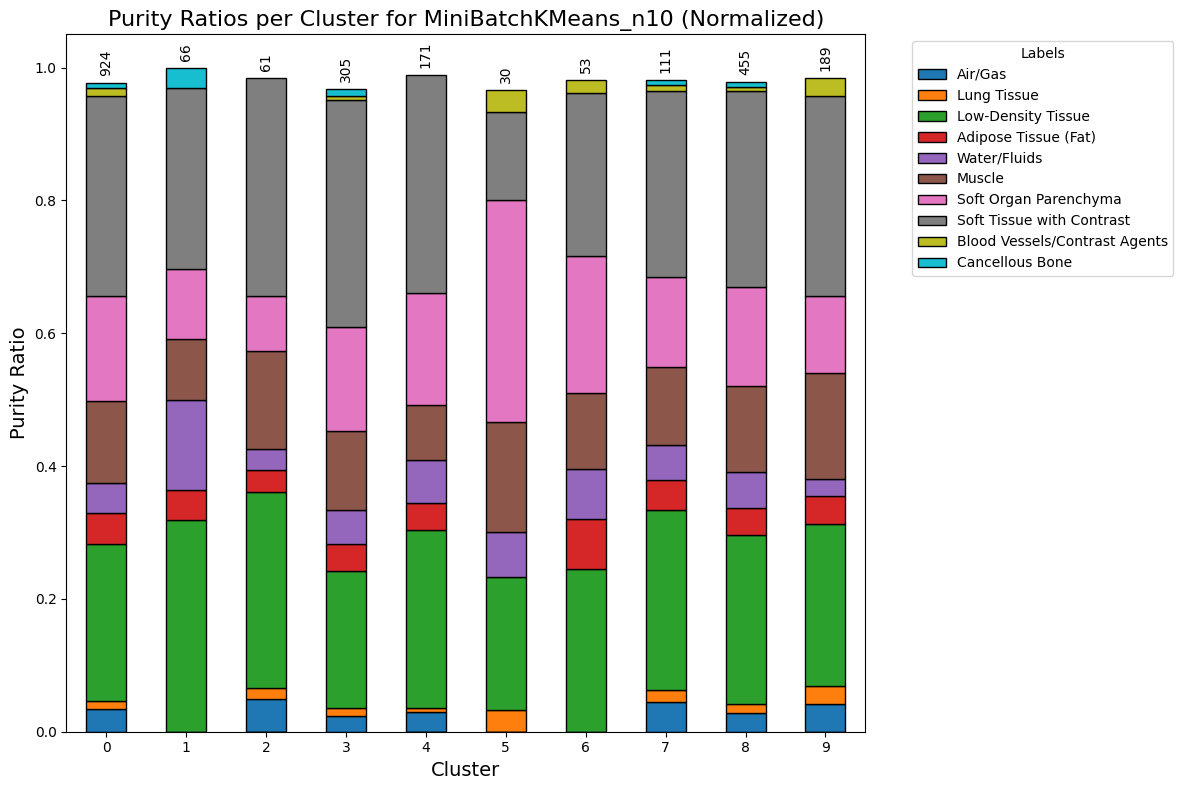

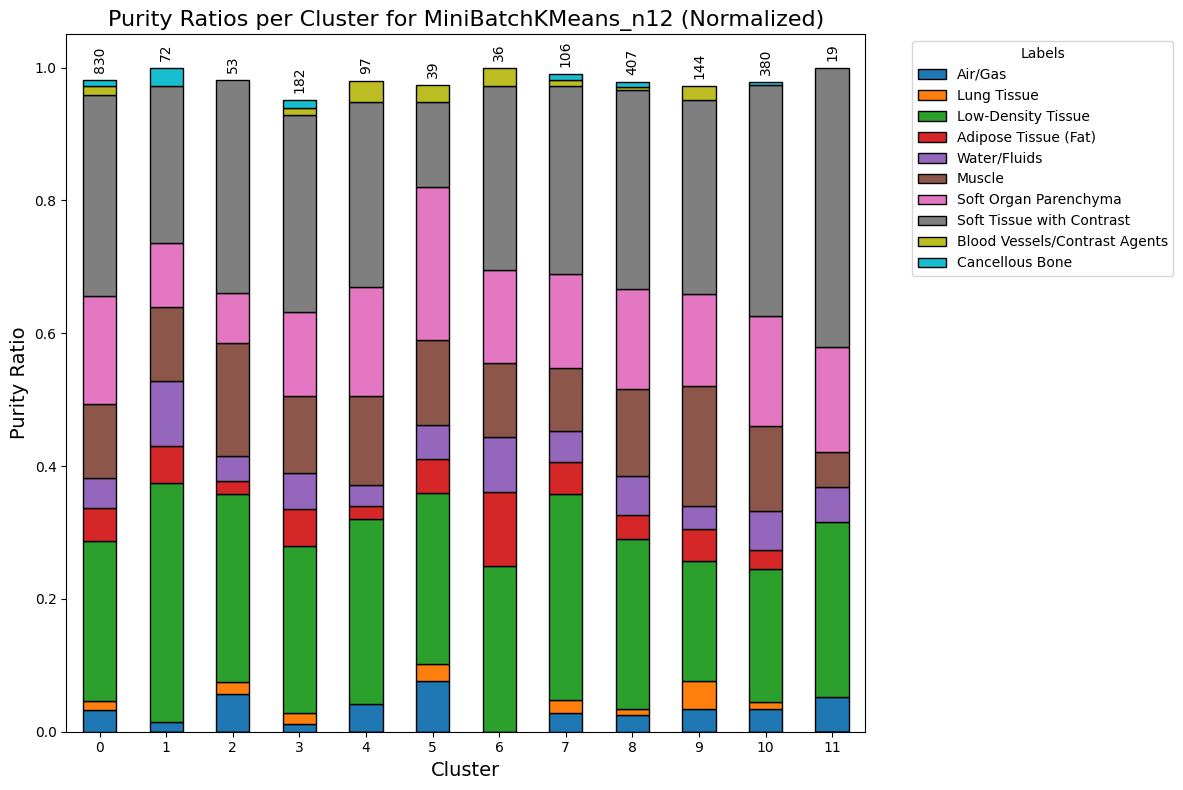

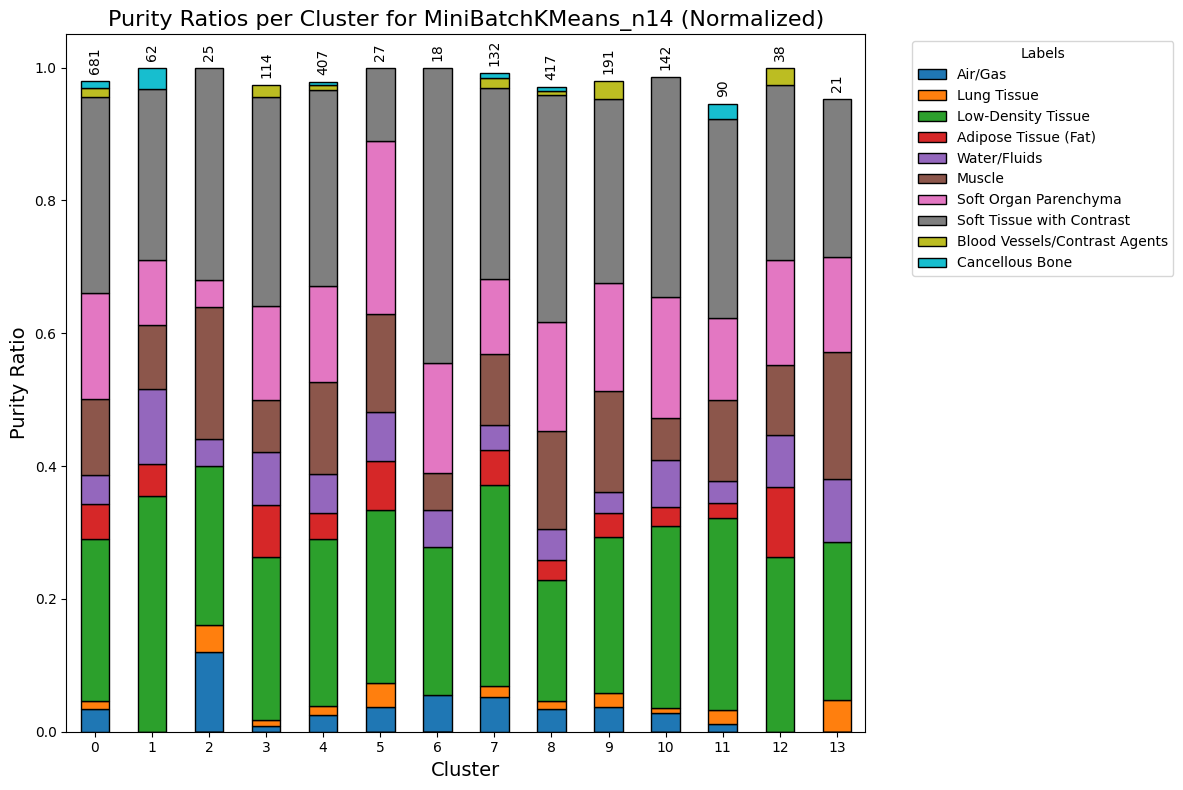

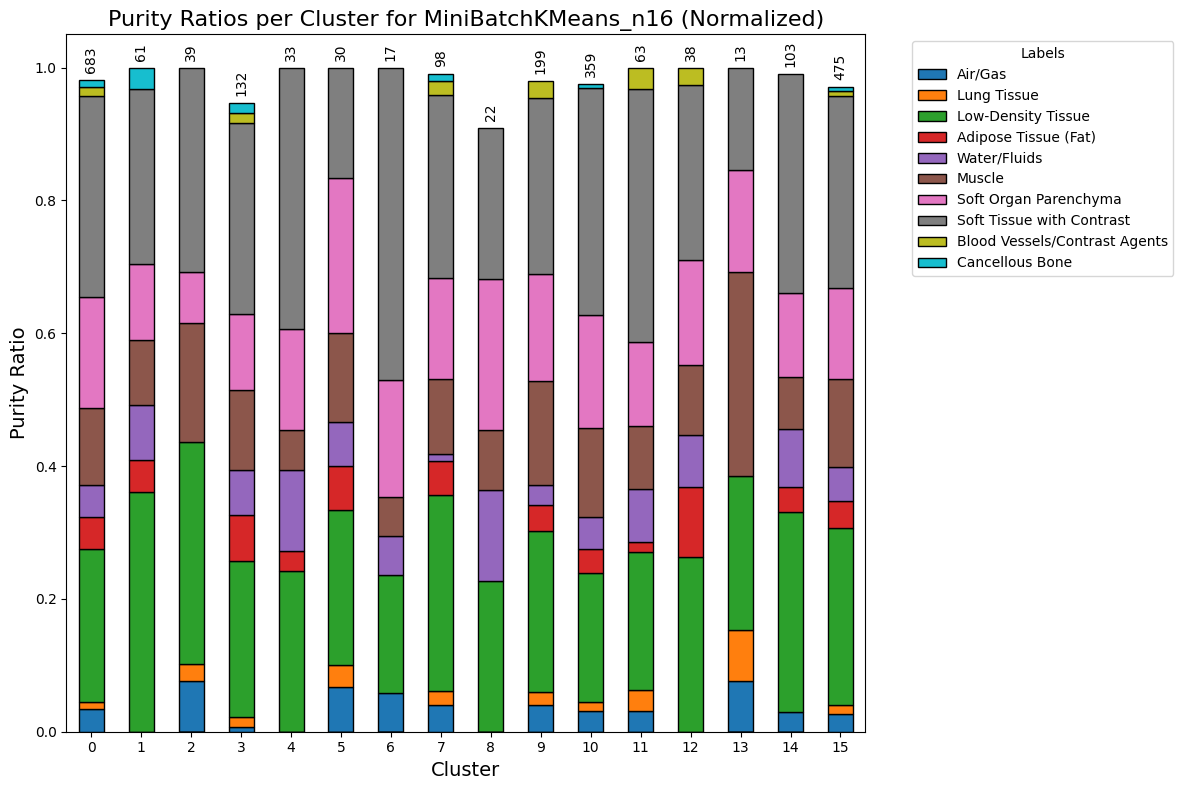

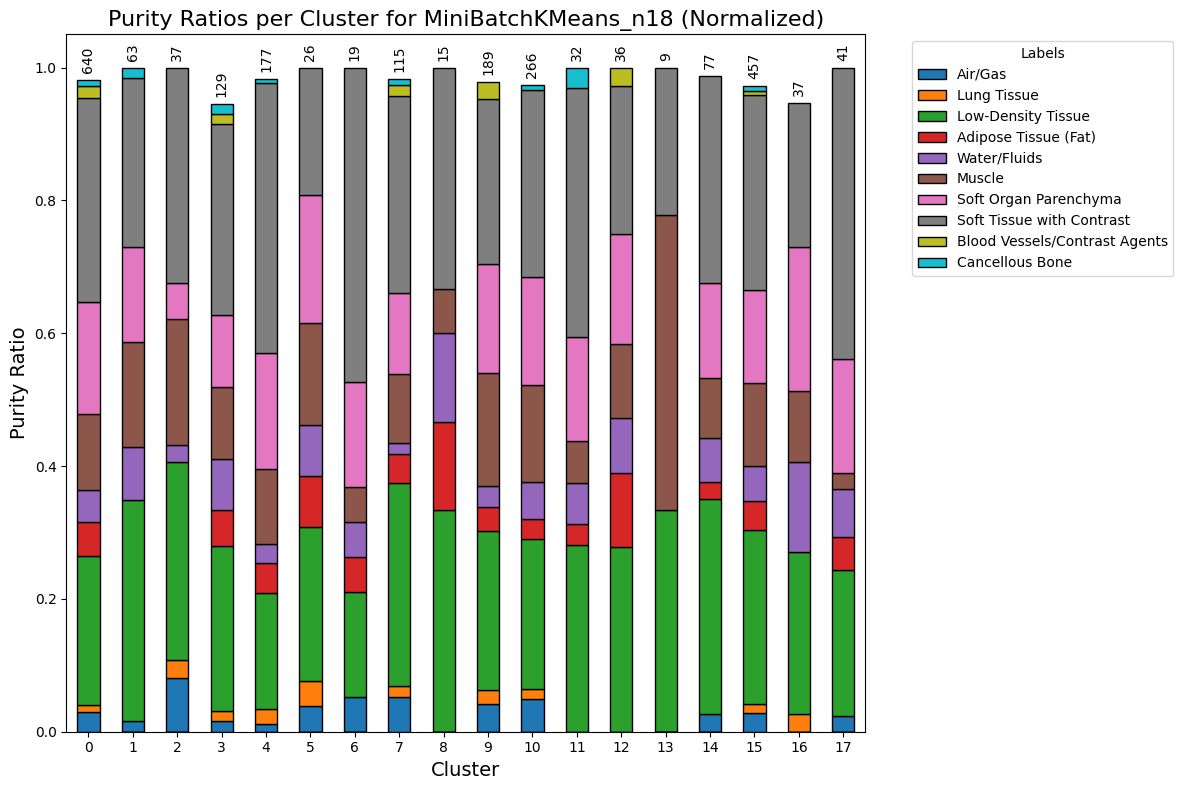

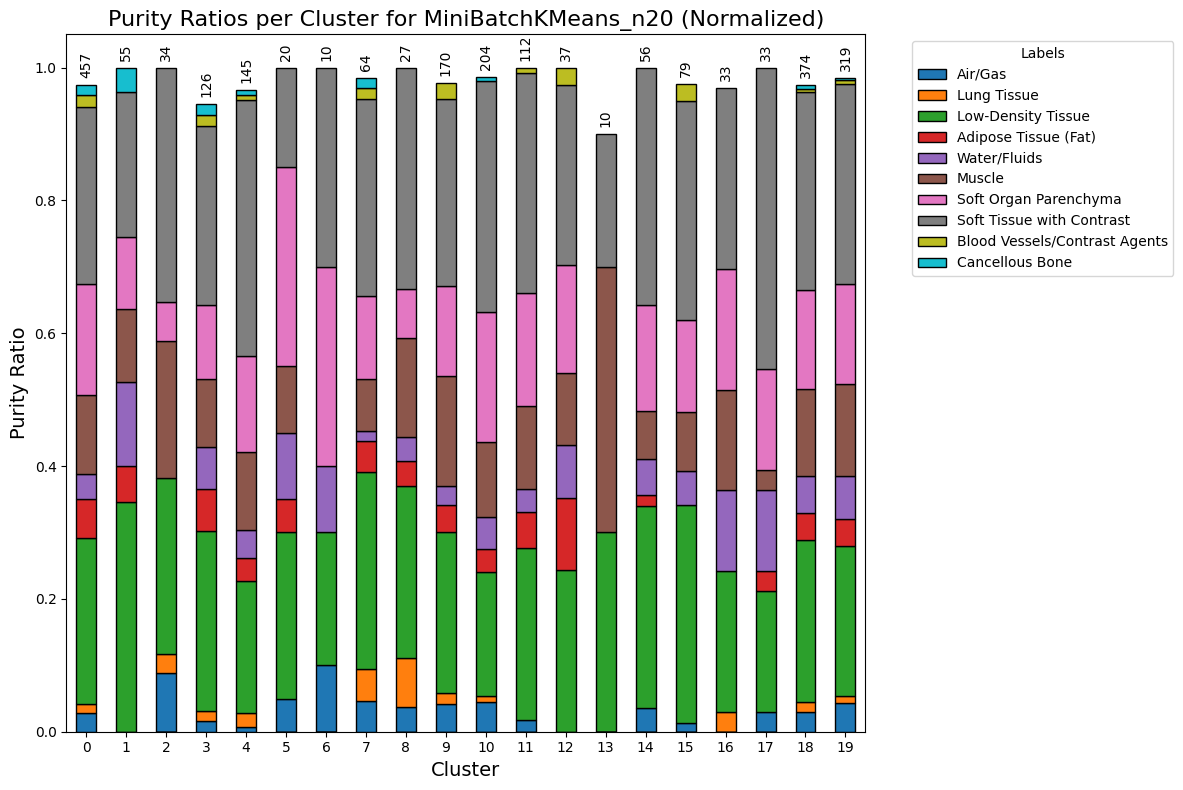

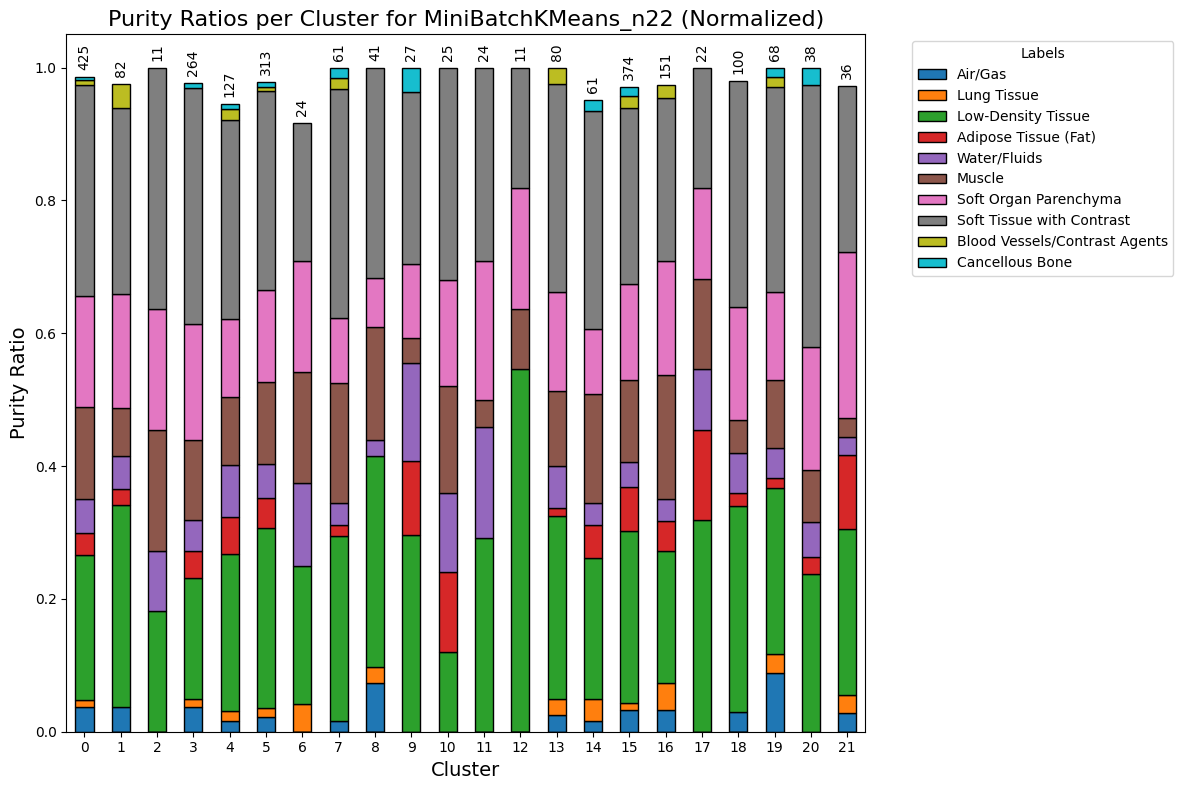

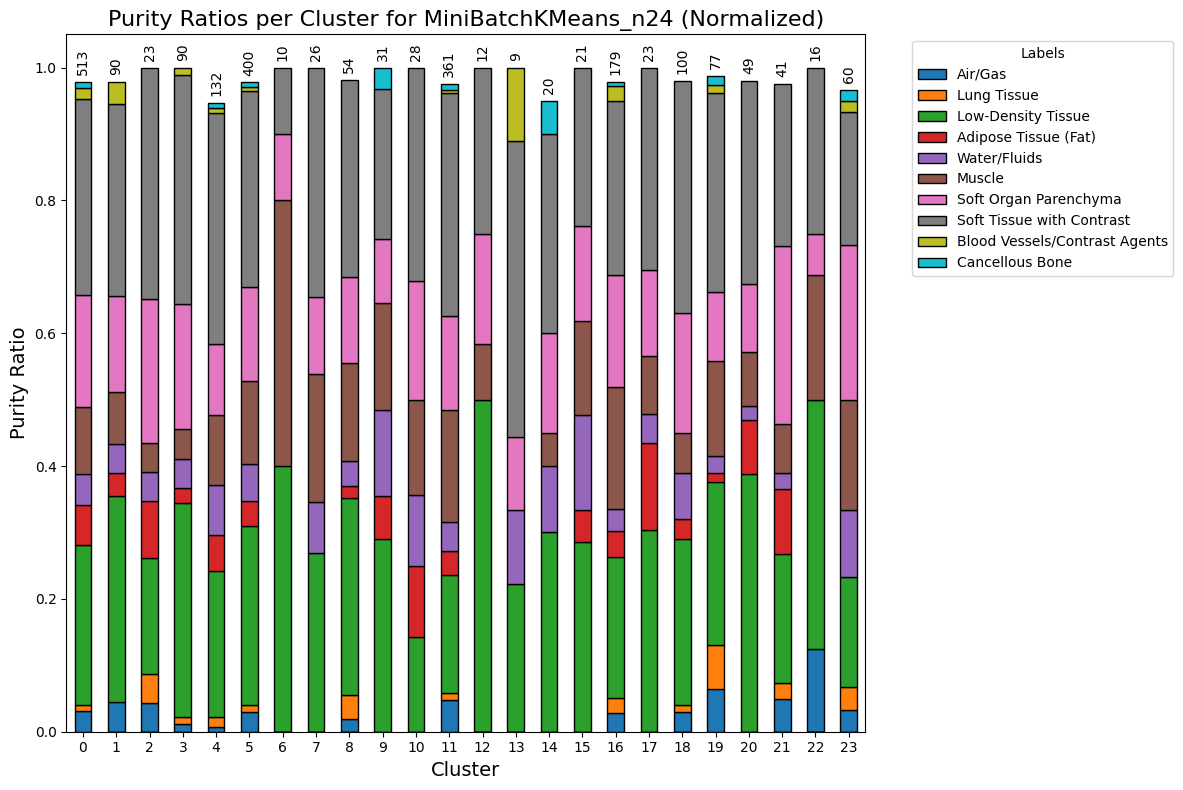

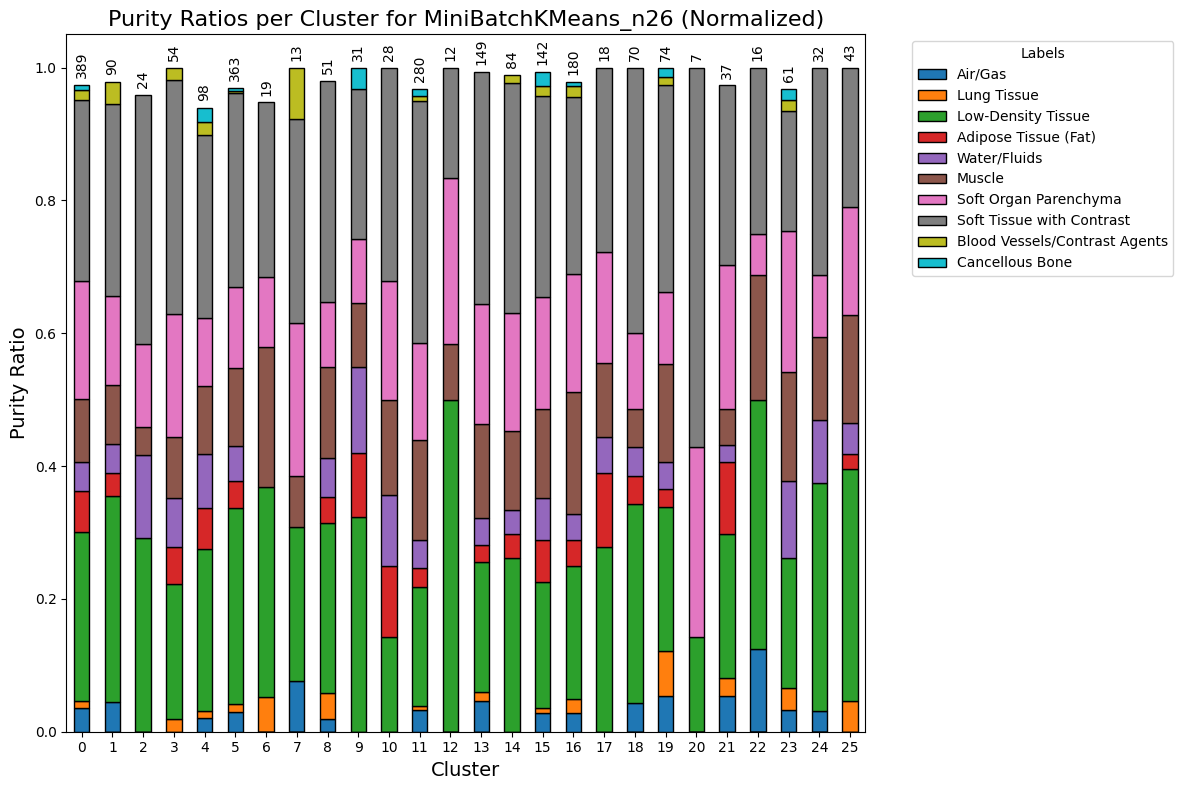

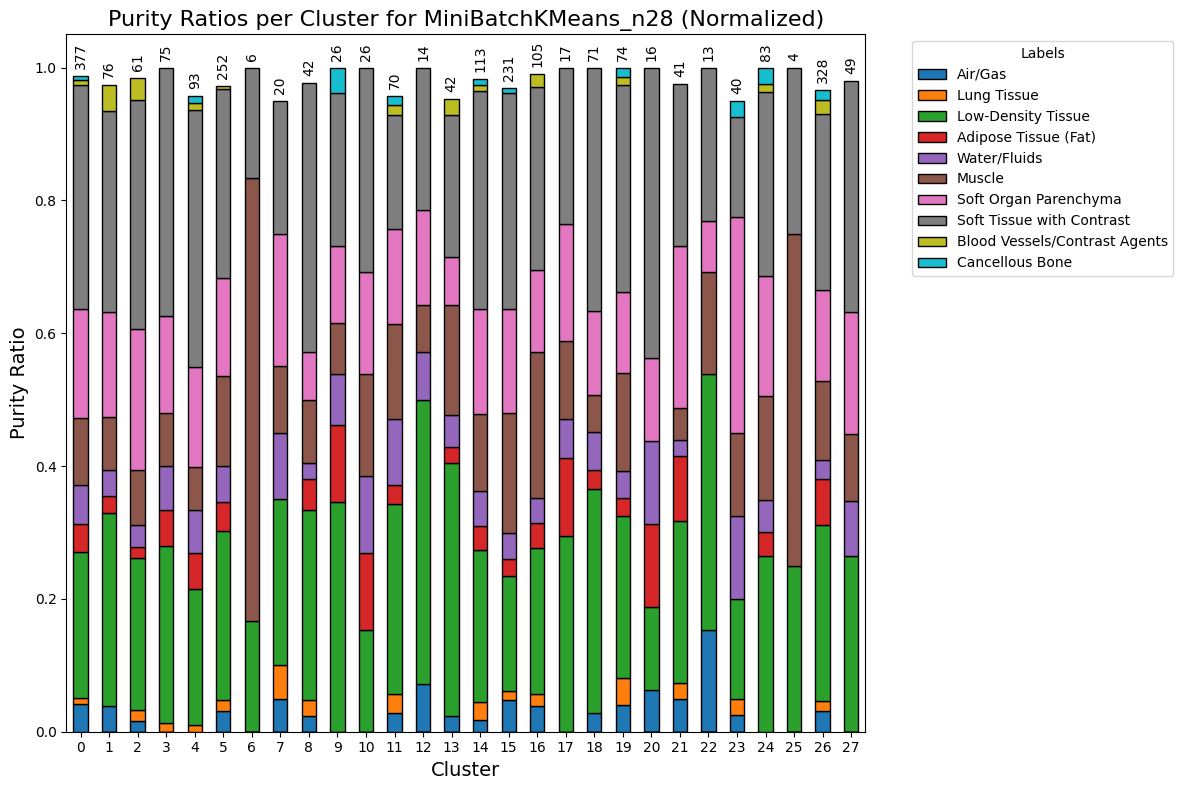

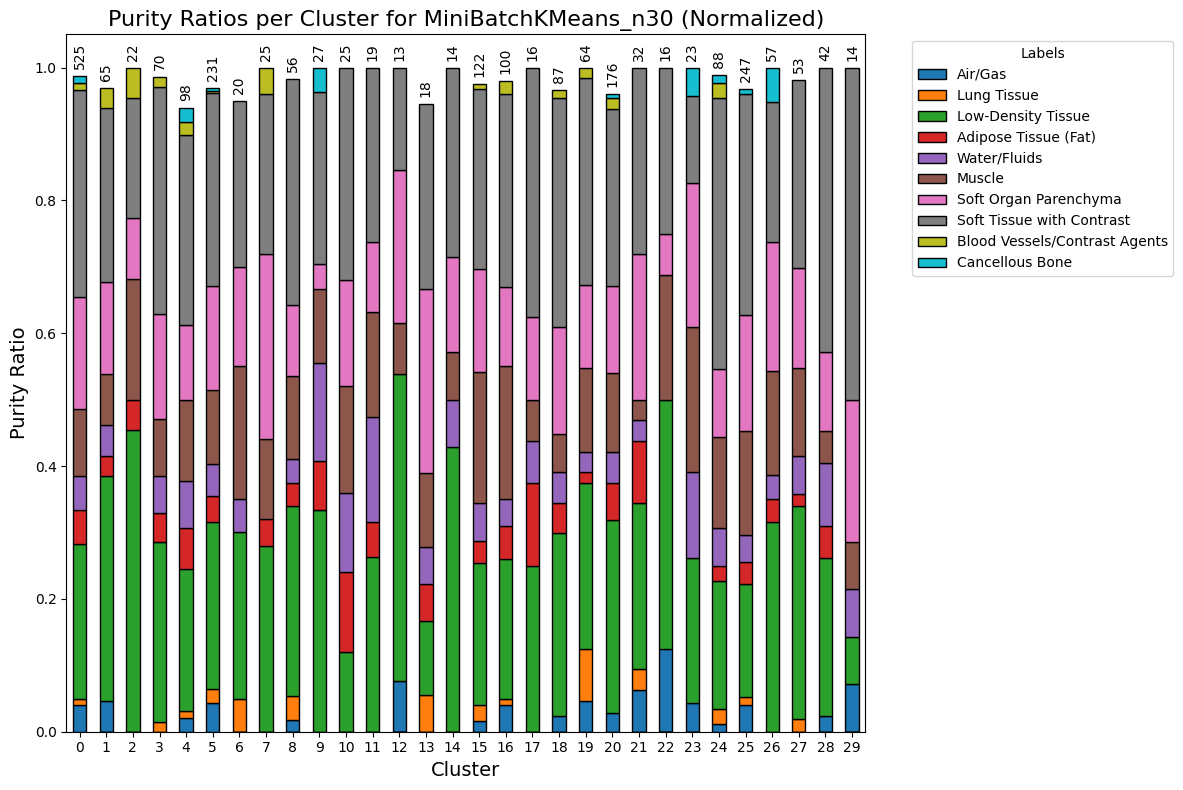

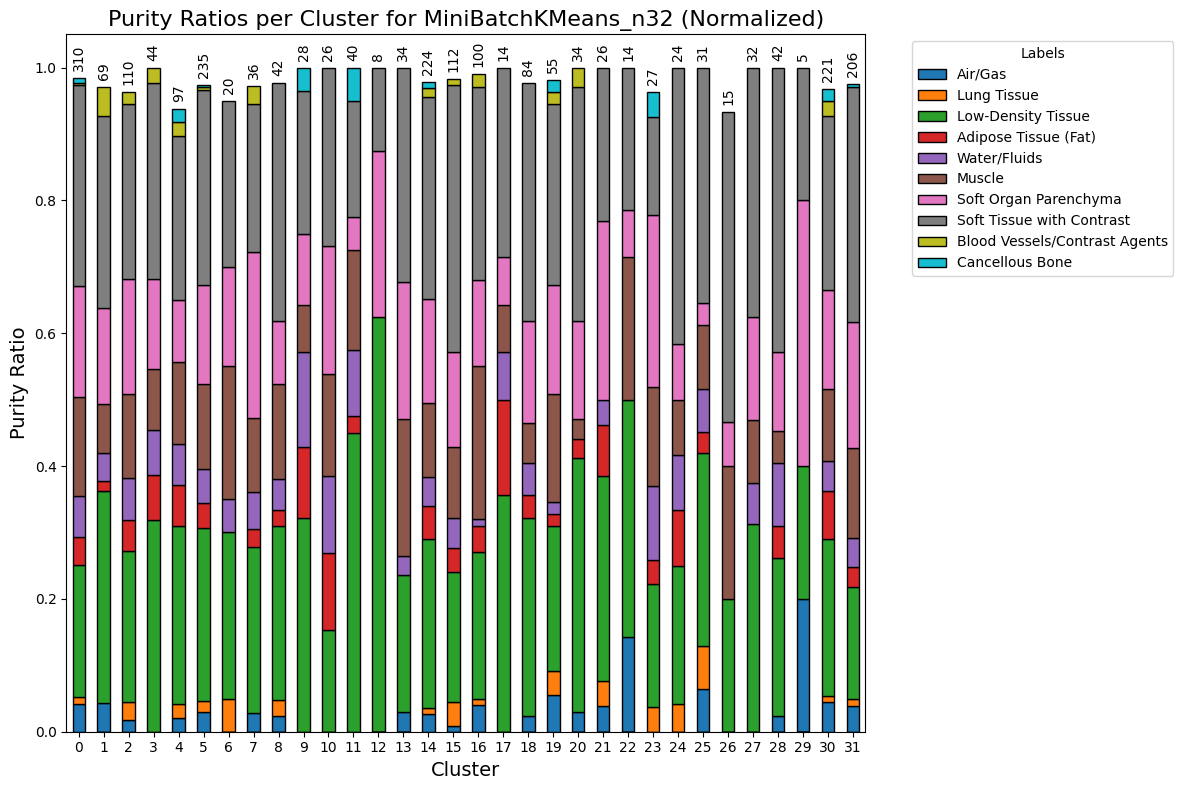

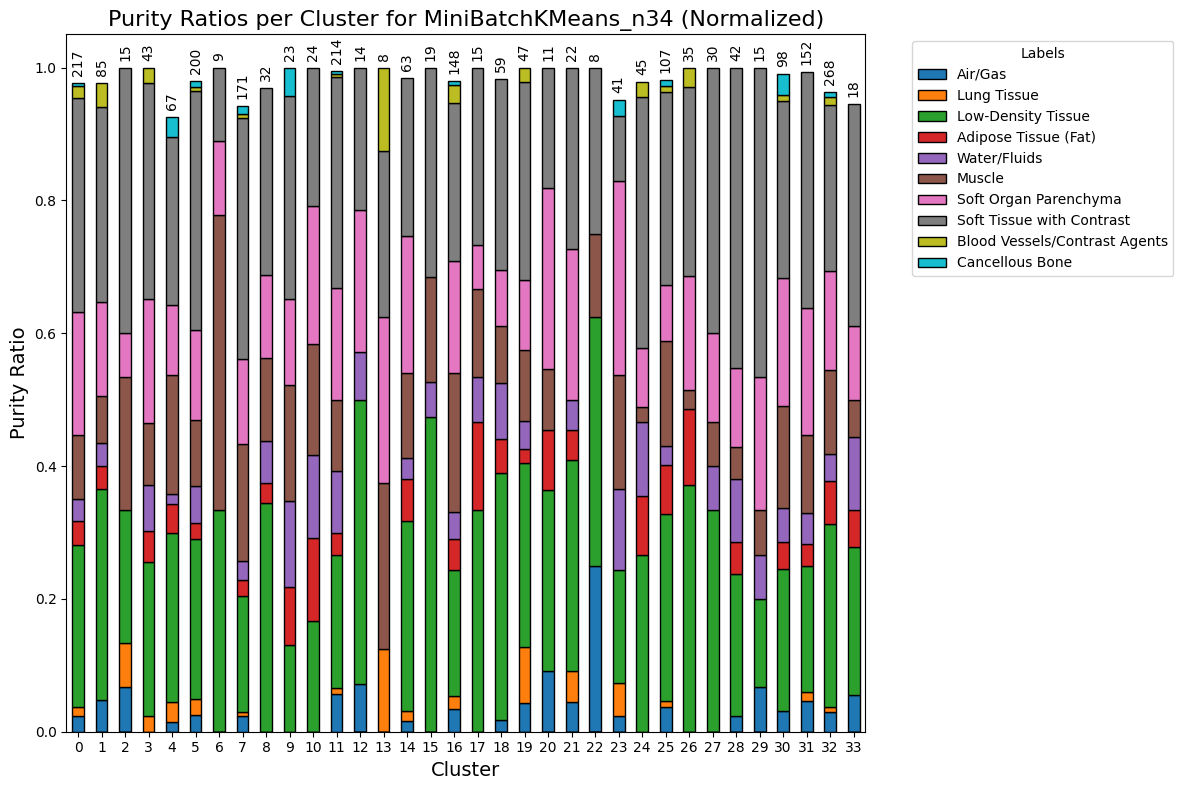

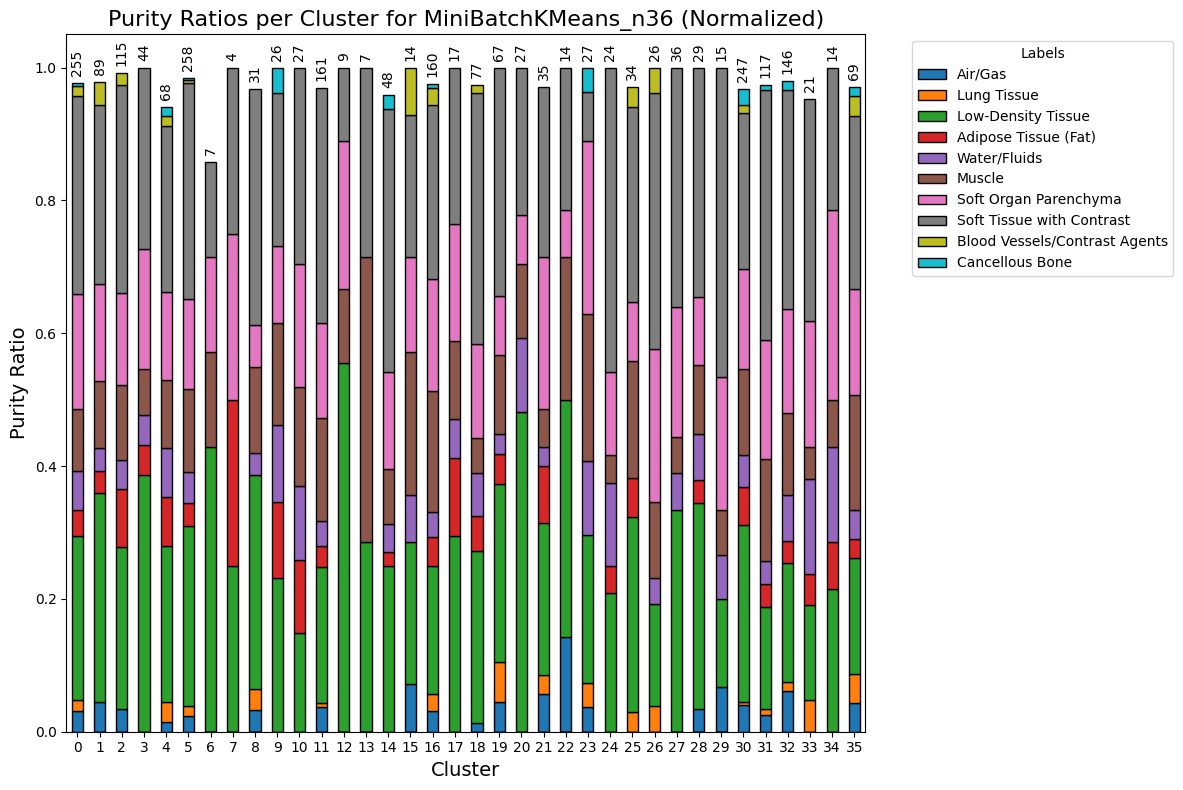

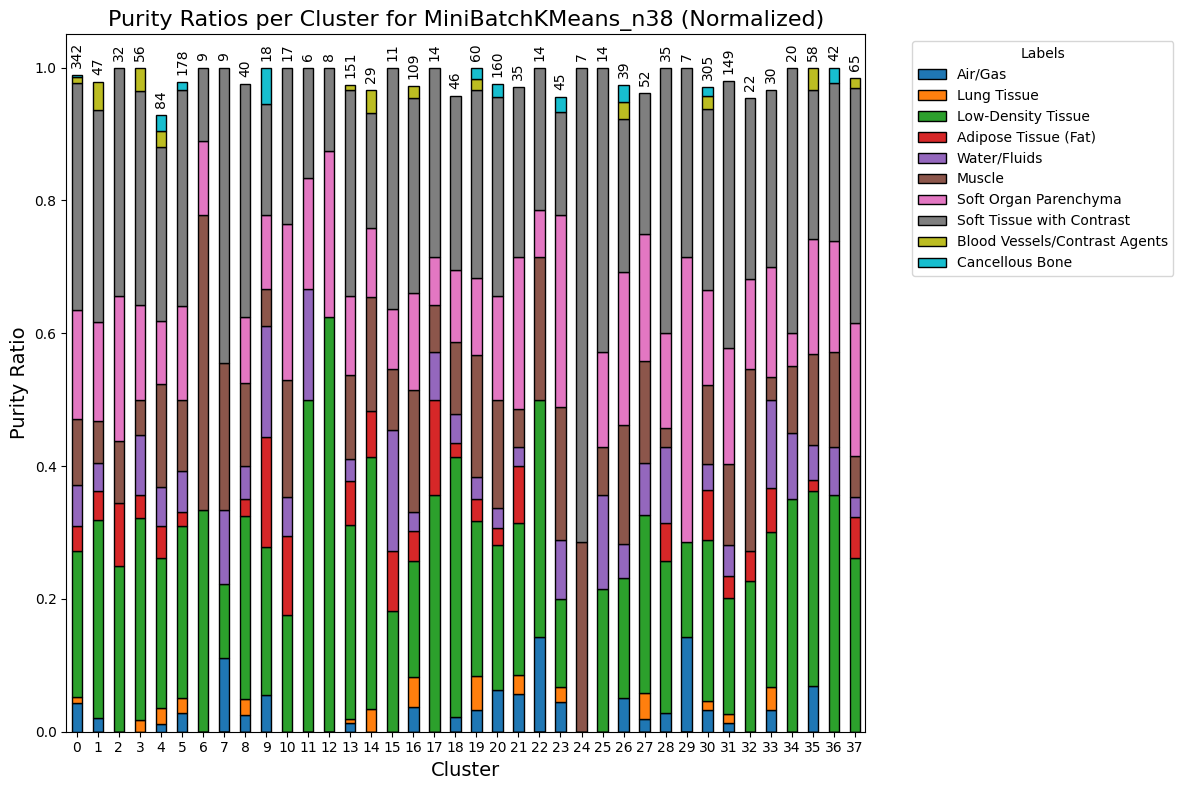

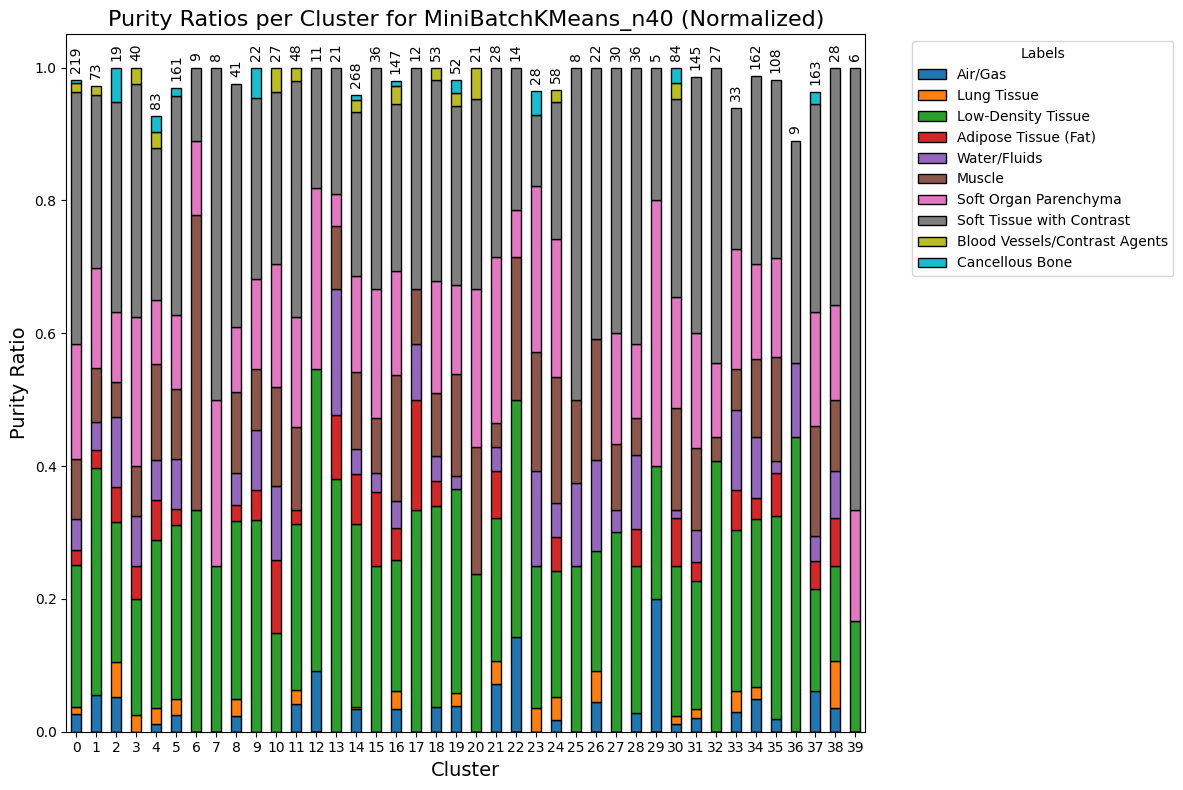

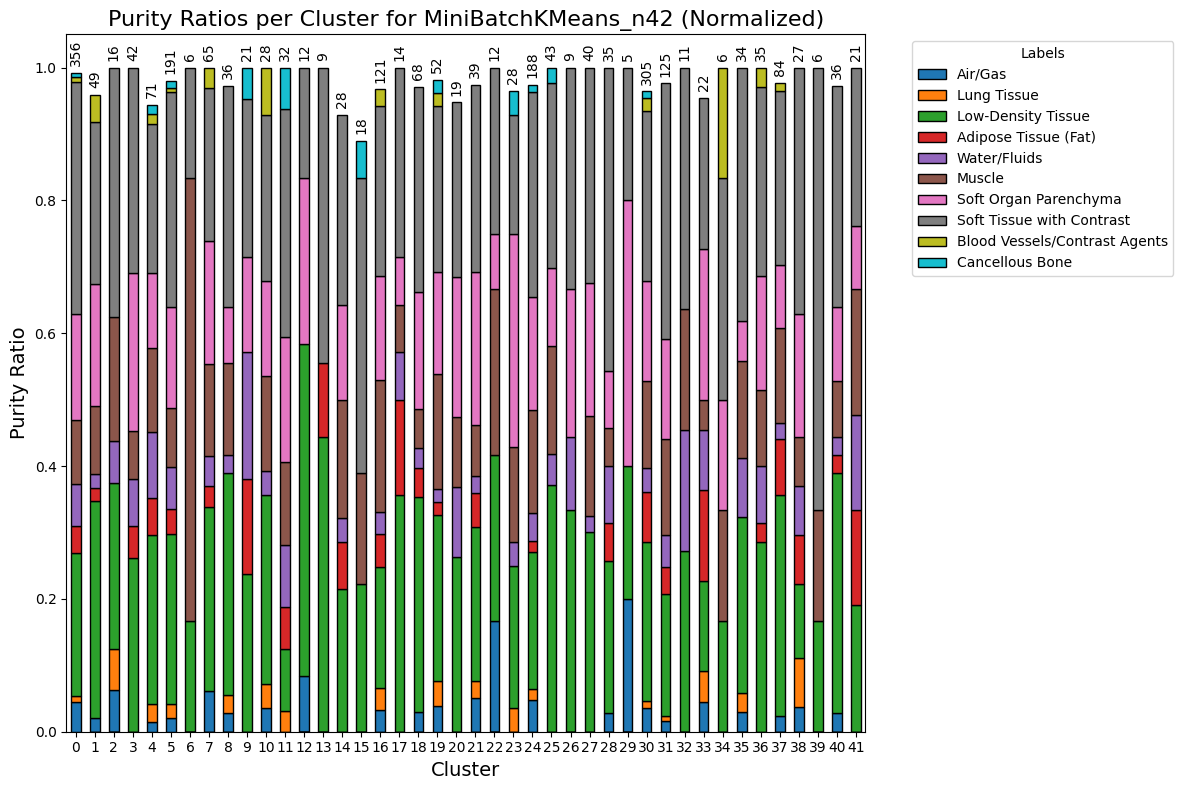

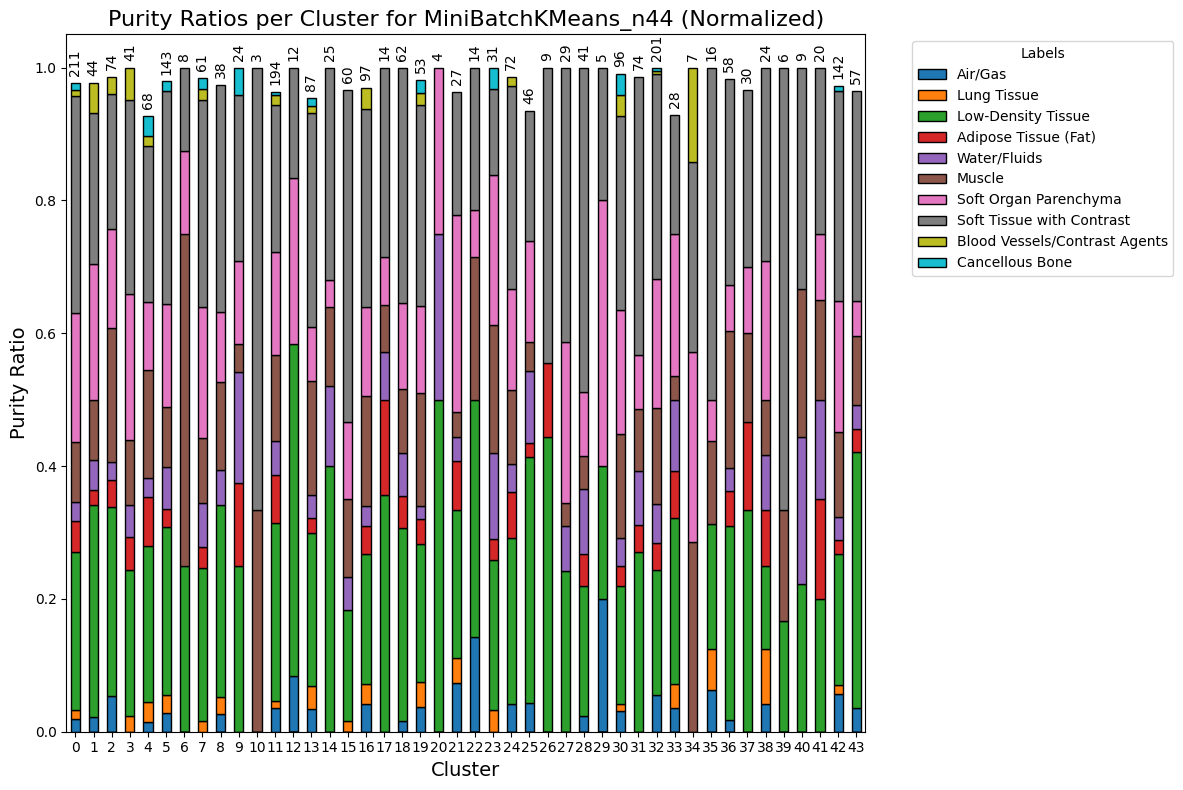

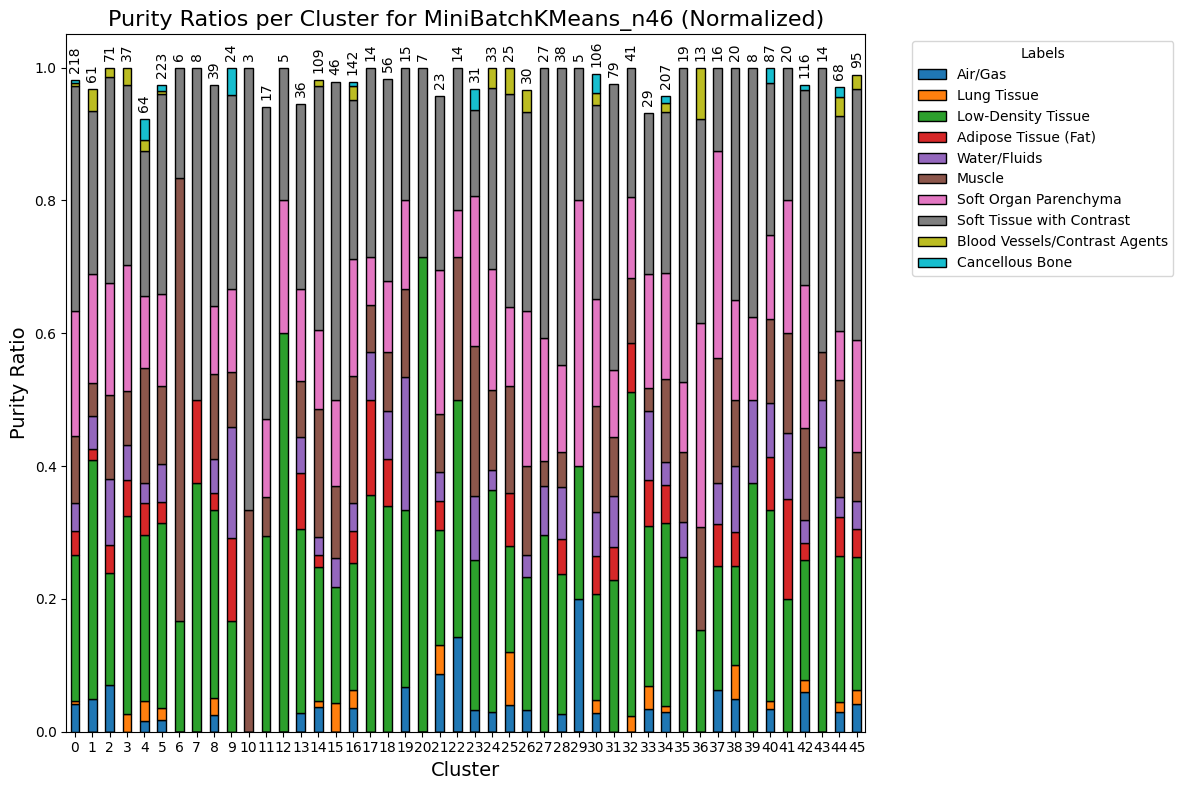

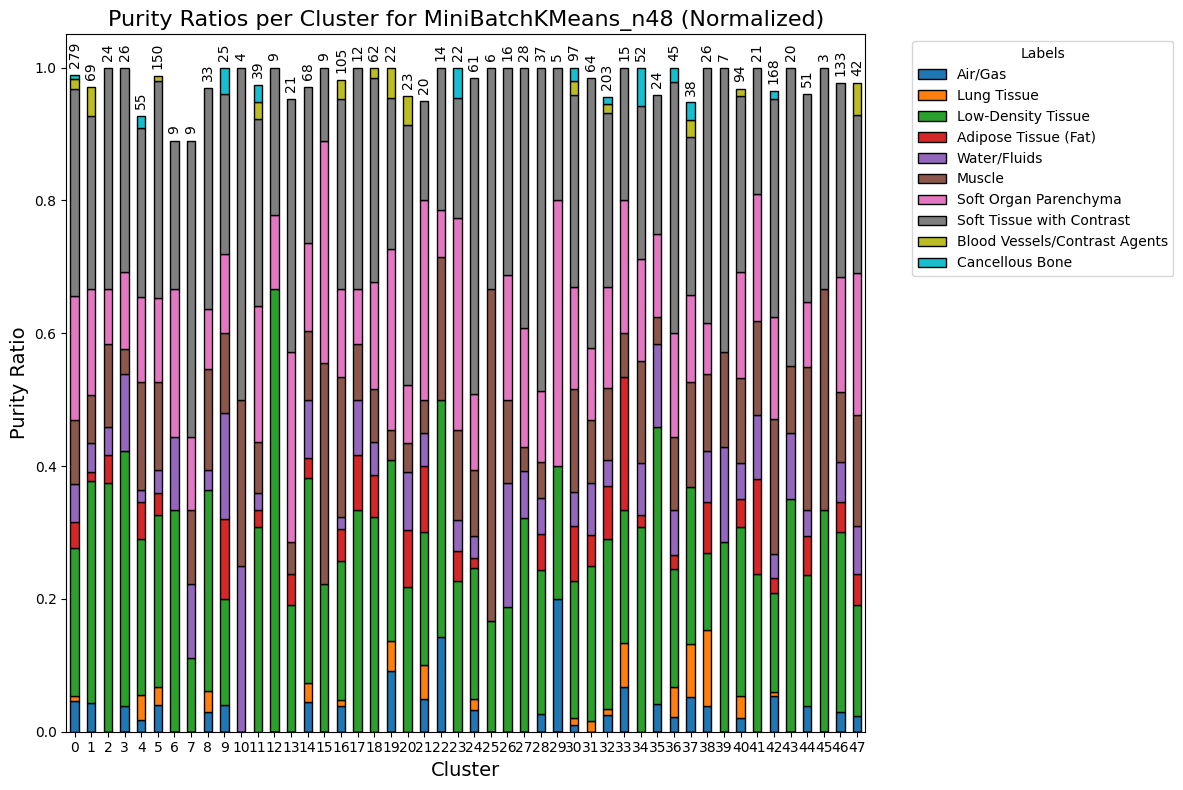

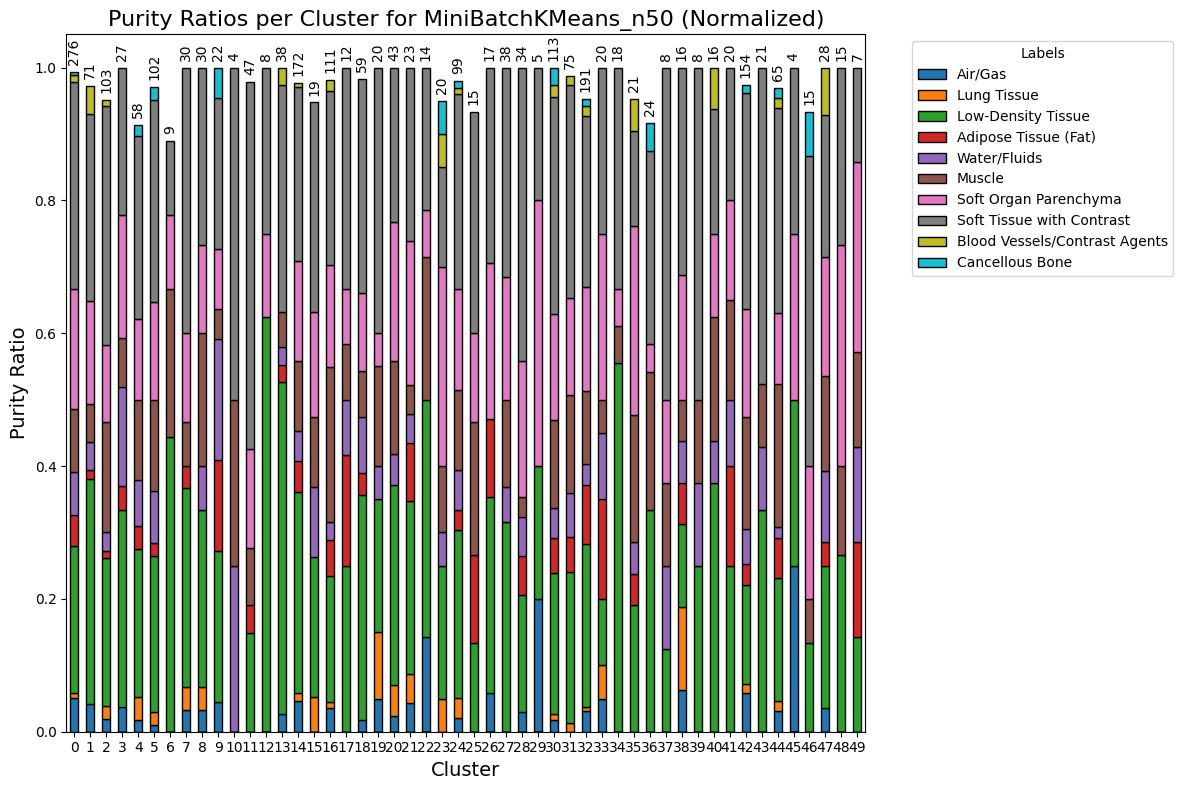

In [62]:
# Define a label order based on tissue labels
label_order = [tissue_labels[i] for i in sorted(tissue_labels.keys())]

# Plot the prior distribution of tissue types
plot_prior_distribution(
    labels=labels,
    label_mapping=tissue_labels,
    label_order=label_order
)

# Perform clustering and plot purities using tissue types
purity_results, algorithms = cluster_and_plot_purities(
    data=data,  # Replace with your actual data
    labels=labels,
    cluster_range=range(2, 51, 2),
    plot=True,
    random_state=42,
    normalize_bars=True,
    label_mapping=tissue_labels,
    label_order=label_order
)

In [ ]:
cluster_results, algorithms = cluster_and_plot_purities(raw_cubes_middle_vecs, labels)#, use_case='multi-class')